In [ ]:
!pip install 

In [1]:
from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream
import requests
TOKEN = "5964815651:AAFbuxVkduvd5Lm22b_zwh7k6zjl2lYvVzc"
chat_id = "1383158265"


lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        try:
            print(image.size[1], image.size[0])
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)
    
    name = image_path
    name.replace(".png",".mid")

    midi_stream.write('midi', 'composition.mid')


ModuleNotFoundError: No module named 'music21'

In [2]:
from music21 import converter, instrument, note, chord
import sys
import numpy as np
from imageio import imwrite

def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}


def midi2image(midi_path, max_repetitions = float("inf"), resolution = 0.25, lowerBoundNote = 21, upperBoundNote = 127, maxSongLength = 100):
    
    try:
        print(f'[!] Processing {midi_path}')
        mid = converter.parse(midi_path)

        instruments = instrument.partitionByInstrument(mid)

        data = {}

        try:
            i=0
            for instrument_i in instruments.parts:
                notes_to_parse = instrument_i.recurse()

                notes_data = get_notes(notes_to_parse)
                if len(notes_data["start"]) == 0:
                    continue

                if instrument_i.partName is None:
                    data["instrument_{}".format(i)] = notes_data
                    i+=1
                else:
                    data[instrument_i.partName] = notes_data

        except:
            notes_to_parse = mid.flat.notes
            data["instrument_0"] = get_notes(notes_to_parse)


        paths = []
        unique_ids = 0
        for instrument_name, values in data.items():
            # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems

            pitches = values["pitch"]
            durs = values["dur"]
            starts = values["start"]

            index = 0
            while index < max_repetitions:
                matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))


                for dur, start, pitch in zip(durs, starts, pitches):
                    dur = int(dur/resolution)
                    start = int(start/resolution)

                    if not start > index*(maxSongLength+1) or not dur+start < index*maxSongLength:
                        for j in range(start,start+dur):
                            if j - index*maxSongLength >= 0 and j - index*maxSongLength < maxSongLength:
                                matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255

                if matrix.any(): # If matrix contains no notes (only zeros) don't save it
                    out_path = os.path.join(midi_path.split('/')[0], 'images/', midi_path.split('/')[-1][:-4] + f'_{unique_ids}.png')

                    imwrite(os.path.join(out_path),matrix.astype(np.uint8))
                    index += 1
                    unique_ids+=1
                else:
                    break
                    
        print(f'[!] Finished {midi_path}')
        
    except Exception as e:
        print(e)
                

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from multiprocessing.pool import ThreadPool

midi_path = 'All/'

midis = [os.path.join(midi_path, 'mid/', i) for i in os.listdir(os.path.join(midi_path, 'mid/'))]
new_dir = os.path.join(midi_path, 'images/')


# Process
ThreadPool(12).map(midi2image, midis)

#for midi in tqdm(midis):
#    midi2image(os.path.join(midi_path, 'mid/', midi), os.path.join(new_dir, midi))


images = os.listdir(new_dir)

hsize = 106
basewidth = 106

for img in tqdm(images):
    img_path = os.path.join(new_dir, img)
    
    img = Image.open(img_path)
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    img.save(img_path)

[!] Processing All/mid/Sonatina in C major_ Op 36_ No 3 Spiritoso (Clementi).mid[!] Processing All/mid/Amor Vampiro.mid
[!] Processing All/mid/Custom Made.mid

[!] Processing All/mid/What If I Made A Mistake (Album Version).mid
[!] Processing All/mid/Prelude and Fugue in C minor.mid
[!] Processing All/mid/May Day Maching Song.mid
[!] Processing All/mid/Das Wohltemperierte Clavier I, Fuga XVI.mid
[!] Processing All/mid/Jimmy Jimmy.mid
[!] Processing All/mid/Ordinary Day.mid
[!] Processing All/mid/Your Love Stays With Me.mid
[!] Processing All/mid/Stand by Me.mid
[!] Processing All/mid/Monkey_Island_1_-_The_Secret_of_Monkey_Island_-_LeChuck_by_w3sp.mid
[!] Finished All/mid/Monkey_Island_1_-_The_Secret_of_Monkey_Island_-_LeChuck_by_w3sp.mid
[!] Processing All/mid/Horn Concerto No 4 in E flat K495 II Romance (Andante cantabile).mid
[!] Finished All/mid/Ordinary Day.mid
[!] Processing All/mid/Mega_Man_5_DarkmanStages.mid
[!] Finished All/mid/Custom Made.mid
[!] Processing All/mid/Adia.mid
[

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KH\xd4NG CO\xccN NH\xd5\xec NG\xdd\xd5\xccI Y\xcaU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Heart Shaped Bruise.mid
[!] Processing All/mid/Clowns Dance Op61, No5.mid
[!] Finished All/mid/Mega_Man_5_DarkmanStages.mid
[!] Processing All/mid/Baby One More Time.mid
[!] Finished All/mid/Adia.mid
[!] Processing All/mid/Faith Is The Light.mid
[!] Finished All/mid/27 Etudes Opp 10_ 25 and posth F_ Op 253.mid
[!] Processing All/mid/To Fall In Love Again.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH TH\xd5'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Clowns Dance Op61, No5.mid
[!] Processing All/mid/FFB.mid
[!] Finished All/mid/What Happened.mid
[!] Processing All/mid/Para Morir Iguales.mid
[!] Finished All/mid/Flight of the Bumble Bee.mid
[!] Processing All/mid/Una Mujer.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'KH\xd4NG CO\xccN NH\xd5\xec NG\xdd\xd5\xccI Y\xcaU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Satin Sheets.mid
[!] Processing All/mid/German Dance 3.mid
[!] Finished All/mid/Faith Is The Light.mid
[!] Processing All/mid/Dear Mama.mid
[!] Finished All/mid/German Dance 3.mid
[!] Processing All/mid/(Who) Keeps Changing Your Mind (Daniel Bovie  Roy Rox Dub Mix).mid
[!] Finished All/mid/Baby One More Time.mid
[!] Processing All/mid/You Only Live Twice.mid
[!] Finished All/mid/Una Mujer.mid
[!] Processing All/mid/In Fine  Ghost Finale.mid
[!] Finished All/mid/Body Scan Music (Album Version).mid
[!] Processing All/mid/Fantaisie-Impromptu in C-Sharp Minor_ Op 66.mid
[!] Finished All/mid/You Only Live Twice.mid
[!] Processing All/mid/Star Wars.mid
[!] Finished All/mid/To Fall In Love Again.mid
[!] Processing All/mid/Fugue in E flat major_ BWV 876.mid
[!] Finished All/mid/Para Morir Iguales.mid
[!] Processing All/mid/Schöner Rosengarten.mid
[!] Finished All/mid/(Who) Keeps Changing Your Mind (Daniel Bovie  Roy Rox Dub Mix).mid
[!] Processing All/mid/Regrets.mid
[!] F

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'A\xecNH TR\xc3NG X\xddA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/real time.mid
[!] Processing All/mid/The Wreath.mid
[!] Finished All/mid/Nocturne No 1 in B-flat minor.mid
[!] Processing All/mid/La Petite Réunion.mid
[!] Finished All/mid/Tu.mid
[!] Processing All/mid/Les feuilles mortes.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH KHU\xecC THI\xcaN THU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/La Petite Réunion.mid
[!] Processing All/mid/Modra.mid
[!] Finished All/mid/Sleigh Ride.mid
[!] Processing All/mid/Wanted Dead Or Alive.mid
[!] Finished All/mid/The Wreath.mid
[!] Processing All/mid/Satz-  330.mid
[!] Finished All/mid/Rondo.mid
[!] Processing All/mid/Harvest_Moon_Back_to_Nature_Spring.mid
[!] Finished All/mid/Wanted Dead Or Alive.mid
[!] Processing All/mid/Rock 2 House London 2 London Remix.mid
[!] Finished All/mid/Waltz in E-flat Major (Op 18).mid
[!] Processing All/mid/Tornerò.mid
[!] Finished All/mid/Not A Sinner Nor A Saint.mid
[!] Processing All/mid/Veni Vedi Vici.mid
[!] Finished All/mid/Fantaisie-Impromptu in C-Sharp Minor_ Op 66.mid
[!] Processing All/mid/Nocturnes No 19 in E minor Op 72 No 1 (posthumous).mid
[!] Finished All/mid/Harvest_Moon_Back_to_Nature_Spring.mid
[!] Processing All/mid/Masquerade.mid
[!] Finished All/mid/Rock 2 House London 2 London Remix.mid
[!] Processing All/mid/Elenore.mid
[!] Finished All/mid/Modra.mid[!] Finished

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'B\xdd\xecC TH\xdd TI\xccNH TH\xdd\xec HAI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Higher (Into Your Light).mid
[!] Processing All/mid/Gib dich zufrieden und sei stille.mid
[!] Finished All/mid/Hey Baby (Theyre Playin Our Song).mid
[!] Processing All/mid/Driving Home for Christmas.mid
[!] Finished All/mid/Gypsies_ Tramps And Thieves.mid
[!] Processing All/mid/BanjoTooie_CauldronKeep.mid
[!] Finished All/mid/Vrede.mid
[!] Processing All/mid/Tra Le Braccia Dellangelo.mid
[!] Finished All/mid/Gib dich zufrieden und sei stille.mid
[!] Processing All/mid/Throwing Stones At The Wind.mid
[!] Finished All/mid/Die Forelle.mid
[!] Processing All/mid/Christmas Day.mid
[!] Finished All/mid/Husbands And Wives.mid
[!] Processing All/mid/Something - Original.mid
[!] Finished All/mid/Princesa.mid
[!] Processing All/mid/De Ware Liefde.mid
[!] Finished All/mid/Driving Home for Christmas.mid
[!] Processing All/mid/They Dance Alone (Cueca Solo).mid
[!] Finished All/mid/De Ware Liefde.mid
[!] Processing All/mid/City_Connection_HitACat.mid
[!] Finished All/mid/City_Co

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'THA\xcc M\xd4\xf2T L\xc2\xccN \xd0AU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/La Terra Dei Cachi.mid
[!] Processing All/mid/HWV361-score-1.mid
[!] Finished All/mid/My Generation.mid
[!] Processing All/mid/I Can Do It.mid
[!] Finished All/mid/Jack  Diane.mid
[!] Processing All/mid/God Moving Over The Face Of The Waters (Album Version).mid
[!] Finished All/mid/Mi Naso.mid
[!] Processing All/mid/Sabbath Prayer.mid
[!] Finished All/mid/Cold Day In Hell (2002 Digital Remaster).mid
[!] Processing All/mid/Bring On The Night.mid
[!] Finished All/mid/Somebody To Love Me.mid
[!] Processing All/mid/Ma Baker.mid
[!] Finished All/mid/Brahms Horn Trio.mid
[!] Processing All/mid/Goodbye Yellow Brick Road.mid
[!] Finished All/mid/Sabbath Prayer.mid
[!] Processing All/mid/Dream Weaver (LP Version).mid
[!] Finished All/mid/HWV361-score-1.mid
[!] Processing All/mid/Thats All.mid
[!] Finished All/mid/Rhythm Of The Rain (LP Version).mid
[!] Processing All/mid/Final_Fantasy_5_Japan_AheadonourWay.mid
[!] Finished All/mid/Knuddelmaus.mid
[!] Processing All/mid/Prél

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'm\xe9lodie'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Animal.mid
[!] Processing All/mid/Minha Vida É Você.mid
[!] Finished All/mid/Oh My Darlin (I Love You).mid
[!] Processing All/mid/Piano Sonata No 2 in B Minor_ Op 35 - Funeral March III Marche Funebre Lento.mid
[!] Finished All/mid/Romance Medley No Me Platiques Más_ No Sé Tú_ La Puerta_ La Barca_ Inolvidable.mid
[!] Processing All/mid/Melody in F.mid
[!] Finished All/mid/Dímelo.mid
[!] Processing All/mid/Writing On The Wall.mid
[!] Finished All/mid/Karaoke - Under Pressure.mid
[!] Processing All/mid/Motorsoul.mid
[!] Finished All/mid/Baker Street.mid
[!] Processing All/mid/Moon Over Hawaii.mid
[!] Finished All/mid/Writing On The Wall.mid
[!] Processing All/mid/Sarah Jane.mid
[!] Finished All/mid/Les Valses De Vienne.mid
[!] Processing All/mid/Occasioni.mid
[!] Finished All/mid/Looking At You.mid
[!] Processing All/mid/Son Of God.mid
[!] Finished All/mid/Nutcracker Suite Op71A Dance Of The Sugar Plum Fairy.mid
[!] Processing All/mid/How Will I Know.mid
[!] Finished

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'EM \xd0A\xde TH\xc2\xecY MU\xccA XU\xc2N CH\xddA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Gyakorlatok - Studien.mid
[!] Processing All/mid/Karneval der Tiere - La coucou au fond des bois  Cukoo In The Hearth Of The Woods.mid
[!] Finished All/mid/Get Busy (Kid Massive Audio Damage re-work).mid
[!] Processing All/mid/Tell Me.mid
[!] Finished All/mid/Das Wohltemperierte Clavier I, Praeludium VI.mid
[!] Processing All/mid/Sonantina.mid
[!] Finished All/mid/Disco 2000.mid
[!] Processing All/mid/Xenogears_TheWoundedShallAdvanceIntotheLight.mid
[!] Finished All/mid/We Sing.mid
[!] Processing All/mid/What Becomes Of The Brokenhearted.mid
[!] Finished All/mid/My Friend The Wind.mid
[!] Processing All/mid/Endless Love.mid
[!] Finished All/mid/Lady Jane.mid
[!] Processing All/mid/Ugy-Tetszik.mid
[!] Finished All/mid/Karneval der Tiere - La coucou au fond des bois  Cukoo In The Hearth Of The Woods.mid
[!] Processing All/mid/Che Cosa Resterà Di Me.mid
[!] Finished All/mid/Heart (2001 Digital Remaster).mid
[!] Processing All/mid/Legata A Un Granello Di Sabbia.mid
[!]

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'GI\xc2\xecC M\xd5 BU\xd4\xccN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/I Cant Tell You Why (Live Version).mid
[!] Processing All/mid/Happy Already.mid
[!] Finished All/mid/Your Baby Never Looked Good In Blue.mid
[!] Processing All/mid/I Wish It Would Rain (In The Style Of The Temptations).mid
[!] Finished All/mid/Endless Love.mid
[!] Processing All/mid/Shes Got That Light (Orange-Mix).mid
[!] Finished All/mid/Warioware_Touched_RocktheMike.mid
[!] Processing All/mid/Echo Beach (2002 Digital Remaster).mid
[!] Finished All/mid/In The Year 2525.mid
[!] Processing All/mid/Schumann  Kinderszenen Op15  X Fast zu ernst.mid
[!] Finished All/mid/I Wish It Would Rain (In The Style Of The Temptations).mid
[!] Processing All/mid/Proud mary.mid
[!] Finished All/mid/Carne de Pescoço.mid
[!] Processing All/mid/Sonata No 1.mid
[!] Finished All/mid/Desert Rose.mid
[!] Processing All/mid/Yu I Chih Hsia.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xddA TUY\xca\xf2T VO\xf2NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Pass Me Not.mid
[!] Processing All/mid/Electric Fever (Acid Washeds Night Of Lights remix).mid
[!] Finished All/mid/Schumann  Kinderszenen Op15  X Fast zu ernst.mid
[!] Processing All/mid/Hey Tonight.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'M\xddA TUY\xca\xf2T VO\xf2NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Happy Already.mid
[!] Processing All/mid/La Traviata - N10 Finale del Atto II.mid
[!] Finished All/mid/Stoptime Rag.mid
[!] Processing All/mid/Knock Three Times.mid
[!] Finished All/mid/Jetstream (Sasha Remix).mid
[!] Processing All/mid/Alma E Coração.mid
[!] Finished All/mid/Sonata No 14 c-sharp minor op 272 Adagio sostenuto.mid
[!] Processing All/mid/Chrono_Cross_AnotherArniVillage.mid
[!] Finished All/mid/Hey Tonight.mid
[!] Processing All/mid/Circle of Life.mid
[!] Finished All/mid/Proud mary.mid
[!] Processing All/mid/La Pathetique  Piano Sonata No 8 in C minor_ Op 13.mid
[!] Finished All/mid/Electric Fever (Acid Washeds Night Of Lights remix).mid
[!] Processing All/mid/Dancing Queen.mid
[!] Finished All/mid/Shes Got That Light (Orange-Mix).mid
[!] Processing All/mid/Joy.mid
[!] Finished All/mid/Knock Three Times.mid[!] Finished All/mid/La Traviata - N10 Finale del Atto II.mid
[!] Processing All/mid/Closer.mid

[!] Processing All/mid/One Fine Day.mid
[!] Finis

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NU\xf2 H\xd4\xccNG H\xd5\xcc H\xdd\xdeNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Youre Only Lonely.mid
[!] Processing All/mid/Someone Loves You Honey.mid
[!] Finished All/mid/Joy.mid
[!] Processing All/mid/The Memory Of Trees (Instrumental).mid
[!] Finished All/mid/Sonata No 1.mid
[!] Processing All/mid/Total Eclipse Of the Heart 1994.mid
[!] Finished All/mid/Crossing the Hands.mid
[!] Processing All/mid/Entr Acte from Rosamunde.mid
[!] Finished All/mid/How Could An Angel Break My Heart.mid
[!] Processing All/mid/Gotta Pull Myself Together.mid
[!] Finished All/mid/Echo Beach (2002 Digital Remaster).mid
[!] Processing All/mid/Mega_Man_2_AirMansStage.mid
[!] Finished All/mid/Entr Acte from Rosamunde.mid
[!] Processing All/mid/Das Wohltemperierte Clavier I, Praeludium XX.mid
[!] Finished All/mid/Sweet Home Alabama.mid
[!] Processing All/mid/You Gave Me A Mountain.mid
[!] Finished All/mid/Sombreros et Mantilles.mid
[!] Processing All/mid/Concerto No 1 In B Flat Minor_ Op23 Third Movement - Allegro Con Fuoco.mid
[!] Finished All/mid/One Step Closer 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xc3\xecT BU\xd4\xccN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Besame.mid
[!] Processing All/mid/A Chi ( Hurt ).mid
[!] Finished All/mid/Everything Fades Away.mid
[!] Processing All/mid/A Gift of a Thistle.mid
[!] Finished All/mid/Fool To Cry (1993 Digital Remaster).mid
[!] Processing All/mid/The First Noël.mid
[!] Finished All/mid/Sidewalk Annie.mid[!] Finished All/mid/When Love Was Something Else (LP Version).mid
[!] Processing All/mid/Hes So Jolly.mid

[!] Processing All/mid/Theme, Sonata in C.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'M\xc3\xecT BU\xd4\xccN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Clair De Lune.mid
[!] Processing All/mid/Ballade in G Minor_ Op 118No 3.mid
[!] Finished All/mid/Con questi occhi.mid
[!] Processing All/mid/Quiero Perderme En Tu Cuerpo.mid
[!] Finished All/mid/I Think Im Falling In Love (Pop Uptempo Mix) (Pop Uptempo Mix).mid
[!] Processing All/mid/These Exiled Years.mid
[!] Finished All/mid/Twelve Thirty (Young Girls Are Coming To The Canyon).mid
[!] Processing All/mid/Go the Distance.mid
[!] Finished All/mid/Theme, Sonata in C.mid
[!] Processing All/mid/Aint That A Lot Of Love.mid
[!] Finished All/mid/A Chi ( Hurt ).mid
[!] Processing All/mid/Ma La Notte No (Live).mid
[!] Finished All/mid/A Gift of a Thistle.mid
[!] Processing All/mid/No Surrender.mid
[!] Finished All/mid/Clear Night For Love.mid
[!] Processing All/mid/Aimer La Vie (Soy Un Truhán Soy Un Señor).mid
[!] Finished All/mid/Go the Distance.mid
[!] Processing All/mid/Man In The Mirror.mid
[!] Finished All/mid/Hes So Jolly.mid
[!] Processing All/mid/Stockholm Syndrome.

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'DO\xccNG S\xd4NG B\xc3NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Wo Shin Dung Le.mid
[!] Processing All/mid/Es Hat Die Rose Sich Beklagt.mid
[!] Finished All/mid/Love Will Rise Again.mid
[!] Processing All/mid/Pintu Hatiku.mid
[!] Finished All/mid/Frozen Rivers.mid
[!] Processing All/mid/Jai retrouvé ma liberté.mid
[!] Finished All/mid/A Musical Joke.mid
[!] Processing All/mid/Voglio Solo Te.mid
[!] Finished All/mid/String Quartet No15.mid
[!] Processing All/mid/Pokemon_Red_Blue_Yellow_ShowMeAround.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'DO\xccNG S\xd4NG B\xc3NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Es Hat Die Rose Sich Beklagt.mid
[!] Processing All/mid/Laid So Low (Tears Roll Down).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'DO\xccNG S\xd4NG B\xc3NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/If You Can Touch Her At All.mid
[!] Processing All/mid/Auf dem Wasser zu singen_ S 558 No2 piano transcription after Schubert.mid
[!] Finished All/mid/Pintu Hatiku.mid
[!] Processing All/mid/Nie wieder Ballermann - nüchtern fürs Radio.mid
[!] Finished All/mid/Spring_ Summer_ Winter And Fall.mid
[!] Processing All/mid/Lied Ohne Worte - Opus 102, No 3.mid
[!] Finished All/mid/Pokemon_Red_Blue_Yellow_ShowMeAround.mid
[!] Processing All/mid/Bella Notte.mid
[!] Finished All/mid/Voglio Solo Te.mid
[!] Processing All/mid/Prologue(Little Shop Of Horrors).mid
[!] Finished All/mid/The Thrill Is Gone.mid
[!] Processing All/mid/BanjoTooie_SpiralMountain.mid
[!] Finished All/mid/Laid So Low (Tears Roll Down).mid
[!] Processing All/mid/You Dont Know My Name.mid
[!] Finished All/mid/Youve Got Me To Hold On to.mid
[!] Processing All/mid/Ein kleines Bettlerliedchen.mid
[!] Finished All/mid/Jai retrouvé ma liberté.mid
[!] Processing All/mid/Sara Come Il Tempo Vuole.mid
[!] Finished 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Ren\xe9'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Watch Out.mid
[!] Processing All/mid/Going To A Town.mid
[!] Finished All/mid/Intonatio gravis.mid
[!] Processing All/mid/Sexy Cinderella (CJ Remix).mid
[!] Finished All/mid/Prop Me Up Beside the Jukebox (If I Die).mid
[!] Processing All/mid/Speed Of Light.mid
[!] Finished All/mid/Speed Of Light.mid
[!] Processing All/mid/San Francisco (Be Sure To Wear Flowers In Your Hair).mid
[!] Finished All/mid/The Journey.mid
[!] Processing All/mid/My Bloody Valentine.mid
[!] Finished All/mid/I Know An Ending When It Comes (Remastered LP Version).mid
[!] Processing All/mid/Please Come To Boston.mid
[!] Finished All/mid/San Francisco (Be Sure To Wear Flowers In Your Hair).mid
[!] Processing All/mid/Ballet CCLXVIII (Terpsichore).mid
[!] Finished All/mid/Going To A Town.mid
[!] Processing All/mid/Mo-Monotonia.mid
[!] Finished All/mid/Sexy Cinderella (CJ Remix).mid
[!] Processing All/mid/Winners.mid
[!] Finished All/mid/Its Over.mid
[!] Processing All/mid/Rock And Roll Dreams Come

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'CHI\xd2 CO\xec EM TRONG TIM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Ballet CCLXVIII (Terpsichore).mid
[!] Processing All/mid/Chattanooga Choo-Choo.mid
[!] Finished All/mid/My Destiny.mid
[!] Processing All/mid/Semigod.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KY\xec TU\xecC XA\xec CHI\xca\xccU V\xc3\xecNG EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Please Come To Boston.mid
[!] Processing All/mid/Solfeggio.mid
[!] Finished All/mid/Final_Fantasy_10_AuronsTheme.mid
[!] Processing All/mid/Sirius.mid
[!] Finished All/mid/FarewellEnd Title.mid
[!] Processing All/mid/Learn To Be Still (In The Style of Eagles) - Karaoke.mid
[!] Finished All/mid/Rock And Roll Dreams Come Through.mid
[!] Processing All/mid/Too Far From Here.mid
[!] Finished All/mid/Mo-Monotonia.mid
[!] Processing All/mid/Lady Marmalade (98 Remix).mid
[!] Finished All/mid/Chattanooga Choo-Choo.mid
[!] Processing All/mid/Whats In A Word.mid
[!] Finished All/mid/All I Want For Christmas Is You.mid
[!] Processing All/mid/Man In The Moon.mid
[!] Finished All/mid/Winners.mid
[!] Processing All/mid/Better Be Home Soon (Live At Sydney Opera House) (2006 Digital Remaster).mid
[!] Finished All/mid/Learn To Be Still (In The Style of Eagles) - Karaoke.mid
[!] Processing All/mid/When I Need You.mid
[!] Finished All/mid/Sirius.mid
[!] Processing All/mid/Gimme Some 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'DU\xcc TA KH\xd4NG CO\xccN Y\xcaU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/If Weve Ever Needed You - High without background vocals.mid
[!] Processing All/mid/Roadside Rose.mid
[!] Finished All/mid/Here There and Everywhere.mid
[!] Processing All/mid/Party 2009.mid
[!] Finished All/mid/On My Own.mid
[!] Processing All/mid/Easy.mid
[!] Finished All/mid/All The Pretty Things.mid
[!] Processing All/mid/Always on My Mind.mid
[!] Finished All/mid/Funeral Procession.mid
[!] Processing All/mid/Das Wohltemperierte Clavier I, Fuga XVII.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'DU\xcc TA KH\xd4NG CO\xccN Y\xcaU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Semigod.mid
[!] Processing All/mid/Play The Game (Live In Montreal).mid
[!] Finished All/mid/Dont Ask My (To Be Lonely) (Live in Pittsburg).mid
[!] Processing All/mid/How Come_ How Long.mid
[!] Finished All/mid/Party 2009.mid
[!] Processing All/mid/Final_Fantasy_2_BattleMedley.mid
[!] Finished All/mid/Pokemon_Red_Blue_Yellow_WelcometotheWorldofPokemon.mid
[!] Processing All/mid/Something To Drink About (Album Version).mid
[!] Finished All/mid/Roadside Rose.mid
[!] Processing All/mid/Weekend In New England.mid
[!] Finished All/mid/Das Wohltemperierte Clavier I, Fuga XVII.mid
[!] Processing All/mid/Diz Que Me Ama.mid
[!] Finished All/mid/Je Marche Seul.mid
[!] Processing All/mid/Elämänura.mid
[!] Finished All/mid/Something To Drink About (Album Version).mid
[!] Processing All/mid/Nin-Com-Pop.mid
[!] Finished All/mid/Always on My Mind.mid
[!] Processing All/mid/The Crush Collision March.mid
[!] Finished All/mid/Easy.mid
[!] Processing All/mid/I Cant Bear.mid
[!] Finis

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'CO\xccN \xd0O\xec TRONG ANH N\xd4\xdeI MONG CH\xd5\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sinfonia 6.mid
[!] Processing All/mid/Do That to Me One More Time.mid
[!] Finished All/mid/Time After Time (Tommy Trash Extended Mix).mid
[!] Processing All/mid/High (Album Version).mid
[!] Finished All/mid/Donkey_Kong_LevelOne.mid
[!] Processing All/mid/No_ Man My Hands Are Dirty.mid
[!] Finished All/mid/Come Back.mid
[!] Processing All/mid/Keyboard Concerto in E BWV1053 III  Allegro.mid
[!] Finished All/mid/High (Album Version).mid
[!] Processing All/mid/Odin_Sphere_HopeFollowingtheToughBattleArranged.mid
[!] Finished All/mid/Ramba Samba.mid
[!] Processing All/mid/Pelo Interfone.mid
[!] Finished All/mid/Waiting Of Voices.mid
[!] Processing All/mid/Är du fortfarande arg.mid
[!] Finished All/mid/Fire All Your Guns.mid
[!] Processing All/mid/Quand le cow-boy va coucher.mid
[!] Finished All/mid/Junge Herzen.mid
[!] Processing All/mid/Dont You Ever Get Tired (Of Hurting Me).mid
[!] Finished All/mid/Pelo Interfone.mid
[!] Processing All/mid/Maniac.mid
[!] Finished All/

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NH\xd5\xec NHA TRANG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Super_Mario_64_Final_Bowser.mid[!] Finished All/mid/Dawn.mid
[!] Processing All/mid/Mountain Melody.mid

[!] Processing All/mid/Sucka For Love (Album Version).mid
[!] Finished All/mid/Synth On A Plinth.mid
[!] Processing All/mid/I Cross My Heart.mid
[!] Finished All/mid/Mega_Man_6_TomahawkmansStage.mid
[!] Processing All/mid/Philadelphia Lawyer.mid
[!] Finished All/mid/Little Ritual.mid
[!] Processing All/mid/Friends For Life (Album Version).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'CHI\xca\xccU R\xd5I'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/(Goodnight My Love) Pleasant Dreams.mid
[!] Processing All/mid/Battle_of_Olympus_OlympusNoTatakai.mid
[!] Finished All/mid/Show Me Your Love.mid
[!] Processing All/mid/Les roses d 19Ispahan.mid
[!] Finished All/mid/Philadelphia Lawyer.mid
[!] Processing All/mid/Hablando A Un Cristal.mid
[!] Finished All/mid/Mountain Melody.mid
[!] Processing All/mid/Float On.mid
[!] Finished All/mid/Är du fortfarande arg.mid
[!] Processing All/mid/Love Potion No 9.mid
[!] Finished All/mid/Champagne Supanova.mid
[!] Processing All/mid/Maneater.mid
[!] Finished All/mid/I Cross My Heart.mid
[!] Processing All/mid/Prelude Op 28, No 6.mid
[!] Finished All/mid/Maneater.mid
[!] Processing All/mid/He Aint HeavyHes My Brother.mid
[!] Finished All/mid/Prelude Op 28, No 6.mid
[!] Processing All/mid/Everlasting.mid
[!] Finished All/mid/Love Potion No 9.mid
[!] Processing All/mid/Im So Lonesome I Could Cry.mid
[!] Finished All/mid/Float On.mid
[!] Processing All/mid/Amiga mía (uplugged).mid
[!]

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Piano Melod\xeda.'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/2 D1 Coup.mid
[!] Processing All/mid/Final_Fantasy_8_BalambGarden.mid
[!] Finished All/mid/Footsteps With Spurs (Album Version).mid
[!] Processing All/mid/Exit Speaker.mid
[!] Finished All/mid/Metroid_KraidsLair.mid
[!] Processing All/mid/Madre De La Tierra.mid
[!] Finished All/mid/Sonate 15 - Andante.mid
[!] Processing All/mid/Pusher (Lifelike Remix).mid
[!] Finished All/mid/Across The Universe.mid
[!] Processing All/mid/Dont Look Back In Anger.mid
[!] Finished All/mid/Flood.mid
[!] Processing All/mid/Save The Robots.mid
[!] Finished All/mid/Poor Little Fool.mid
[!] Processing All/mid/Rêverie.mid
[!] Finished All/mid/Peter Pan-Follow the Leader.mid
[!] Processing All/mid/East Side,West Side.mid
[!] Finished All/mid/What Do You Say To That (Album Version).mid
[!] Processing All/mid/Leave It (Single Remix Version).mid
[!] Finished All/mid/Dont Look Back In Anger.mid
[!] Processing All/mid/Softly.mid
[!] Finished All/mid/Nocturne_ Op 27_ No 2 in D-Flat.mid
[!] Proces

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'BU\xf2I PH\xc2\xecN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Exit Speaker.mid
[!] Processing All/mid/Flame  (almeno Tu Nelluniverso).mid
[!] Finished All/mid/Backroads.mid
[!] Processing All/mid/Legend_of_Zelda_Spirit_Tracks_SpiritDuet.mid
[!] Finished All/mid/Softly.mid
[!] Processing All/mid/What Is Happening (Simmons  Christopher Remix).mid
[!] Finished All/mid/Save The Robots.mid
[!] Processing All/mid/Ho difeso il mio amore (Nights In White Satin) (live).mid
[!] Finished All/mid/OK (Bruised Mix).mid
[!] Processing All/mid/The Call Of The Sea.mid
[!] Finished All/mid/Everything Is Beautiful.mid
[!] Processing All/mid/Inside Of You.mid
[!] Finished All/mid/Karneval der Tiere -  HemiottesWild Asses.mid
[!] Processing All/mid/Yall Niggas Need to Know.mid
[!] Finished All/mid/Legend_of_Zelda_Spirit_Tracks_SpiritDuet.mid
[!] Processing All/mid/Just A Dream.mid
[!] Finished All/mid/JAttendais.mid
[!] Processing All/mid/Song of the Duke.mid
[!] Finished All/mid/What Is Happening (Simmons  Christopher Remix).mid
[!] Processing A

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NA\xccNG XU\xc2N'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/La Traviata - N16 Coro baccanale.mid
[!] Processing All/mid/No (featuring Gustavo Cerati).mid
[!] Finished All/mid/Mi amor es para ti.mid
[!] Processing All/mid/Beauty And The Beast.mid
[!] Finished All/mid/On My Own Les Misérables.mid
[!] Processing All/mid/Burn Down The Mission.mid
[!] Finished All/mid/Super_Mario_Bros_3_Boss.mid[!] Finished All/mid/Im A Hog For You Baby.mid
[!] Processing All/mid/Né En 17 A Leidenstadt.mid

[!] Processing All/mid/Mi Manchi.mid
[!] Finished All/mid/No (featuring Gustavo Cerati).mid
[!] Processing All/mid/For Your Eyes Only.mid
[!] Finished All/mid/This Ones For You.mid
[!] Processing All/mid/Super_Mario_Bros_MainTheme2.mid
[!] Finished All/mid/Daze Of Nothing.mid
[!] Processing All/mid/Holy Land (Album).mid
[!] Finished All/mid/Suspicious Minds.mid
[!] Processing All/mid/Fantaisie-Impromptu_ Op 66.mid
[!] Finished All/mid/Mi Manchi.mid
[!] Processing All/mid/New Years Resolution.mid
[!] Finished All/mid/For Your Eyes Only.mid
[!]

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'XIN MA\xdeI Y\xcaU EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Le Café Des Trois Colombes.mid
[!] Processing All/mid/War Machine.mid
[!] Finished All/mid/If I Could Turn Back Time.mid
[!] Processing All/mid/Solace_ a Mexican Serenade.mid
[!] Finished All/mid/Ancient Arms.mid
[!] Processing All/mid/Zeigt her eure Füße.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Mp F\x81\x9ee '>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/En skimrande minut.mid
[!] Processing All/mid/Wuthering Heights.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Mp F\x81\x9ee '>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/A Day At Docs.mid
[!] Processing All/mid/The World To Come.mid
[!] Finished All/mid/I Cant Quit Her.mid
[!] Processing All/mid/Fugue in E major_ BWV 878.mid
[!] Finished All/mid/Zeigt her eure Füße.mid
[!] Processing All/mid/In Forest Daydream.mid
[!] Finished All/mid/The World To Come.mid
[!] Processing All/mid/Ghost_n_Goblins_MainTheme.mid
[!] Finished All/mid/Through The Eyes Of Love.mid
[!] Processing All/mid/New Years Day.mid
[!] Finished All/mid/Do Ya Think Im Sexy (Album Version).mid
[!] Processing All/mid/Unchained Melody (Senza Catene).mid
[!] Finished All/mid/The Last Waltz.mid
[!] Processing All/mid/I Still Believe.mid
[!] Finished All/mid/Toccata in C Major_ Op 7.mid
[!] Processing All/mid/Step One Two (Laurent Wolf Club Mix).mid
[!] Finished All/mid/In Forest Daydream.mid
[!] Processing All/mid/Cant Help Falling In Love.mid
[!] Finished All/mid/War Machine.mid
[!] Processing All/mid/The Return.mid
[!] Finished All/mid/Ghost_n_Goblins_MainTheme.mid
[!] 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'XIN MA\xdeI Y\xcaU EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Keep It Real.mid
[!] Processing All/mid/Blue Eyes.mid
[!] Finished All/mid/Unchained Melody (Senza Catene).mid
[!] Processing All/mid/Sheltered In The Arms of God (Dottie Rambo with the Homecoming Friends Version).mid
[!] Finished All/mid/The Return.mid
[!] Processing All/mid/Pokemon_Silver_Gold_Crystal_Champion_Battle_by_ALF.mid
[!] Finished All/mid/The Beat.mid
[!] Processing All/mid/Harvest_Moon_64_Summer.mid
[!] Finished All/mid/I Still Believe.mid
[!] Processing All/mid/I Can Almost Hear Her Wings (Album Version).mid
[!] Finished All/mid/Overcomerture.mid
[!] Processing All/mid/The Gladiator.mid
[!] Finished All/mid/Cant Help Falling In Love.mid
[!] Processing All/mid/Be Your Own Girl.mid
[!] Finished All/mid/Wuthering Heights.mid
[!] Processing All/mid/Broadway Rag-A Classic.mid
[!] Finished All/mid/I Can Almost Hear Her Wings (Album Version).mid
[!] Processing All/mid/Non Son Degno Di Te.mid
[!] Finished All/mid/Pokemon_Silver_Gold_Crystal_Champion_Battle_by

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HAI NG\xdd\xd5\xccI CU\xccNG CA\xd2NH NG\xd4\xf2'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Niki D (Album Version).mid
[!] Processing All/mid/Strut.mid
[!] Finished All/mid/Locuras.mid
[!] Processing All/mid/There Youll Be (Album Version).mid
[!] Finished All/mid/School of Easy Classics.mid
[!] Processing All/mid/Why Didnt You Call Me.mid
[!] Finished All/mid/Strut.mid
[!] Processing All/mid/Red Dirt Road.mid
[!] Finished All/mid/Lamour est un oiseau rebelle (Havanaise).mid
[!] Processing All/mid/Jesu_ joy of mans desiring.mid
[!] Finished All/mid/I Will Wait for You.mid
[!] Processing All/mid/Once Bitten Twice Shy (2001 Digital Remaster).mid
[!] Finished All/mid/Even The Nights Are Better.mid
[!] Processing All/mid/Magi_Nation_BossBattle.mid
[!] Finished All/mid/New Shoes (Album Version).mid
[!] Processing All/mid/Children Of The Night.mid
[!] Finished All/mid/Feels Like Flying (Radio Edit).mid
[!] Processing All/mid/Perfect Moment.mid
[!] Finished All/mid/Why Didnt You Call Me.mid
[!] Processing All/mid/Men In Black (From the film Men in Black).mid
[!] 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'B\xd5\xd2I VI\xcc SAO'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Phantasictuck.mid[!] Finished All/mid/Be Quiet And Drive (Far Away) (Remastered Acoustic).mid
[!] Processing All/mid/Schaeffers Jig (LP Version).mid

[!] Processing All/mid/Rhinestone Cowboy.mid
[!] Finished All/mid/Concerto No 14 in E-flat Major for Piano and Orchestra_ K 449I Allegro vivace.mid
[!] Processing All/mid/Entrer Dans La Présence.mid
[!] Finished All/mid/Its My Life Album Version Instrumental.mid
[!] Processing All/mid/Only One Road.mid
[!] Finished All/mid/All Out Of Love (Live).mid
[!] Processing All/mid/Surrounded (Live at the The Marquee Club_ London_ April 23_1993).mid
[!] Finished All/mid/Dance Me To The End Of Love.mid
[!] Processing All/mid/The Wonder Of You.mid
[!] Finished All/mid/I Want To Tell You (Live) (2004 Digital Remaster).mid
[!] Processing All/mid/Sinceramente.mid
[!] Finished All/mid/TVUMDB.mid
[!] Processing All/mid/Love Song (LP Version).mid
[!] Finished All/mid/Schaeffers Jig (LP Version).mid
[!] Processing All/mid/Swanheart.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'\x8ay\x8a\xed2'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Final_Fantasy_9_CleyraDanceEternalHarvest.mid
[!] Processing All/mid/The Day We Fell In Love.mid
[!] Finished All/mid/Its Your Love.mid[!] Finished All/mid/Super_Mario_Galaxy_Gusty_Garden_Galaxy.mid
[!] Processing All/mid/Island Of Dreams.mid

[!] Processing All/mid/Down To My Last Broken Heart.mid
[!] Finished All/mid/Zombies_Ate_My_Neighbors_ZombiePanic.mid
[!] Processing All/mid/I Dont Wanna Fight.mid
[!] Finished All/mid/I Only Want To Be With You.mid
[!] Processing All/mid/Mil Lagrimas.mid
[!] Finished All/mid/Memory - Sound-a-like Cover.mid
[!] Processing All/mid/Sunshine On My Shoulder.mid
[!] Finished All/mid/Cant Take My Eyes of You.mid
[!] Processing All/mid/Dont Take Away The Music.mid
[!] Finished All/mid/Caso Serio.mid[!] Finished All/mid/One More Time.mid
[!] Processing All/mid/Underneath Your Clothes.mid

[!] Processing All/mid/Rhiannon (Remastered Single Version).mid
[!] Finished All/mid/Island Of Dreams.mid
[!] Processing All/mid/Pour Que Tu MAimes

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd0I\xecNH \xdd\xd5\xecC'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Out of Time (Clock Tower BGM).mid
[!] Processing All/mid/Uniting Nations Funky Guitar Sample.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xffGaenogada Pin.'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Youll Lose A Good Thing.mid
[!] Processing All/mid/Heart Of Glass (LP Version).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b"\xffET's E.P.">; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Way We Were.mid
[!] Processing All/mid/So Many Times.mid
[!] Finished All/mid/Dussek Op46 2-1.mid
[!] Processing All/mid/Ever-Changing Woman (LP Version).mid
[!] Finished All/mid/Love Is In The Air.mid
[!] Processing All/mid/Seasons In The Sun.mid
[!] Finished All/mid/Uniting Nations Funky Guitar Sample.mid
[!] Processing All/mid/Kirby_Super_Star_GreenGreens.mid
[!] Finished All/mid/She Even Woke Me Up to Say Good Bye.mid
[!] Processing All/mid/Clowns.mid
[!] Finished All/mid/Ever-Changing Woman (LP Version).mid
[!] Processing All/mid/Lagt Kort Ligger.mid
[!] Finished All/mid/Heart Of Glass (LP Version).mid[!] Finished All/mid/Clowns.mid
[!] Processing All/mid/ -start ID-.mid

[!] Processing All/mid/FChopinPrelude_ Op28 23 (F major).mid
[!] Finished All/mid/Sunny Canon 2009.mid
[!] Processing All/mid/Its Your Love (Album Version).mid
[!] Finished All/mid/TN a las 7 HS.mid
[!] Processing All/mid/How To Save a Life.mid
[!] Finished All/mid/Kirby_Super_Star_GreenG

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'GIA\xd2I THOA\xecT'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/How To Save a Life.mid
[!] Processing All/mid/Invisible Touch.mid
[!] Finished All/mid/Orange Coloured Sky.mid
[!] Processing All/mid/Nothing Compares to You.mid
[!] Finished All/mid/Pennies From Heaven.mid
[!] Processing All/mid/Que Manera Tan Estupida De Amar.mid
[!] Finished All/mid/Wassail_ Wassail.mid
[!] Processing All/mid/Bounce.mid
[!] Finished All/mid/So Many Times.mid
[!] Processing All/mid/Something I Can Never Have.mid
[!] Finished All/mid/Bounce.mid
[!] Processing All/mid/Insomnia Donaeo Remix.mid
[!] Finished All/mid/No 1 Swartskalle.mid
[!] Processing All/mid/Our Town (Album Version).mid
140144163434800
[!] Processing All/mid/Luv Me (Til It Hurts) (Original Radio Edit).mid
[!] Finished All/mid/Hem igen.mid
[!] Processing All/mid/The Portrait of a Lady - Schubert Inpromptu In A Flat_ D 899_ No 4.mid
[!] Finished All/mid/Nothing Compares to You.mid
[!] Processing All/mid/Your Latest Trick.mid
[!] Finished All/mid/Keyboard Partita in B-Flat Major_ BWV 8

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'EM V\xc2\xdeN Y\xcaU TRONG \xd0\xd5\xf2I CH\xd5\xcc'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'B\xca\xecN S\xd4NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Que Manera Tan Estupida De Amar.mid
[!] Processing All/mid/Born To Hand Jive.mid
[!] Finished All/mid/Insomnia Donaeo Remix.mid
[!] Processing All/mid/Dussek Op46 3.mid
[!] Finished All/mid/Chrono_Trigger_ChronoTrigger.mid
[!] Processing All/mid/Mary.mid
[!] Finished All/mid/Something I Can Never Have.mid
[!] Processing All/mid/Ojitos Verdes.mid
[!] Finished All/mid/Ena Hadi.mid
[!] Processing All/mid/This Could Be The Dawning of That Day.mid
[!] Finished All/mid/Your Latest Trick.mid
[!] Processing All/mid/Bleed (LP Version).mid
[!] Finished All/mid/This Could Be The Dawning of That Day.mid
[!] Processing All/mid/I Wanna Be The Only One.mid
[!] Finished All/mid/Invisible Touch.mid
[!] Processing All/mid/World Of Miracles (Album Version).mid
[!] Finished All/mid/Love Story.mid
[!] Processing All/mid/LIsola Di Wight.mid
[!] Finished All/mid/Dussek Op46 3.mid
[!] Processing All/mid/Lepanto.mid
[!] Finished All/mid/Luv Me (Til It Hurts) (Original Radio Edit).mid
[!] P

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xddA VA\xcc N\xd4\xdeI NH\xd5\xec'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/World Of Miracles (Album Version).mid
[!] Processing All/mid/Mind Games (Album Version).mid
[!] Finished All/mid/Sunday 1AM.mid
[!] Processing All/mid/Cant Take My Eyes off You.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'M\xddA VA\xcc N\xd4\xdeI NH\xd5\xec'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'VA\xcc C\xd5N M\xddA T\xd5\xecI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Aqua.mid
[!] Processing All/mid/Around My Dream.mid
[!] Finished All/mid/LIsola Di Wight.mid
[!] Processing All/mid/Beauty Of England.mid
[!] Finished All/mid/Whatever It May Take.mid
[!] Processing All/mid/Sunrise, Sunset.mid
[!] Finished All/mid/Irish Tune From County Derry.mid
[!] Processing All/mid/Mi alma grita.mid
[!] Finished All/mid/Around My Dream.mid
[!] Processing All/mid/Meditation from Thais.mid
[!] Finished All/mid/Cant Take My Eyes off You.mid
[!] Processing All/mid/You Get What You Give.mid
[!] Finished All/mid/Sunshine Day.mid
[!] Processing All/mid/Sample Track 11.mid
[!] Finished All/mid/Lepanto.mid
[!] Processing All/mid/Just One Day (Original Version).mid
[!] Finished All/mid/Meditation from Thais.mid
[!] Processing All/mid/N Kerstkaart (Il Mundo).mid
[!] Finished All/mid/Ghost In My Bed.mid
[!] Processing All/mid/Etude.mid
[!] Finished All/mid/Sunrise, Sunset.mid
[!] Processing All/mid/I cant Sleep.mid
[!] Finished All/mid/The Portrait of a La

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Envole-moi G\xe9n\xe9ration Goldman'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Russian Folk Song.mid
[!] Processing All/mid/Teach Your Children Well.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Envole-moi G\xe9n\xe9ration Goldman'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sinfonia 8.mid
[!] Processing All/mid/A Love So Beautiful.mid
[!] Finished All/mid/BMD.mid
[!] Processing All/mid/9 Etudes-tableaux Op 33 No 6 in C sharp minor (originally No 9).mid
[!] Finished All/mid/Emergencia De Amor.mid
[!] Processing All/mid/Shenmue_II_YouCouldHaveKnocked.mid
[!] Finished All/mid/Ballade No 2_ Op 38.mid
[!] Processing All/mid/Look At Me (Digitally Remastered).mid
[!] Finished All/mid/Killing Me Softly.mid
[!] Processing All/mid/Im Outta Time.mid
[!] Finished All/mid/A Love So Beautiful.mid
[!] Processing All/mid/Chopin Piano Sonata No 3 in B minor_ Op 58.mid
[!] Finished All/mid/Buffalo Soldier.mid
[!] Processing All/mid/Vente.mid
[!] Finished All/mid/Envole-moi (Rendu célèbre par Jean-Jacques Goldman) Version karaoké.mid
[!] Processing All/mid/Red White Blue.mid
[!] Finished All/mid/Shenmue_II_YouCouldHaveKnocked.mid
[!] Processing All/mid/I Could Not Ask For More (LP Version).mid
[!] Finished All/mid/Final_Fantasy_8_ShuffleorBoogie.mid
[!]

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'[A-04] \x83s\x83A\x83m'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/I Will Survive.mid
[!] Processing All/mid/Viajando Sem Rumo.mid
[!] Finished All/mid/Christmas Is (feat Jim Brickman).mid
[!] Processing All/mid/Ode To A Superhero (Parody of Piano Man by Billy Joel).mid
[!] Finished All/mid/October.mid
[!] Processing All/mid/Small Carnival.mid
[!] Finished All/mid/If.mid
[!] Processing All/mid/Tetris_MusicABossRemix.mid
[!] Finished All/mid/Doctor Wu.mid
[!] Processing All/mid/All Of My Heart.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'[A-04] \x83s\x83A\x83m'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'[A-07] \x8a\xd4\x91t & ETC.'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'[A-07] \x8a\xd4\x91t & ETC.'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Recovery.mid
[!] Processing All/mid/Air.mid
[!] Finished All/mid/Keyboard Concerto in G minor BWV1058 I   Allegro.mid
[!] Processing All/mid/Walking In The Air.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'[A-13] \x83I\x81[\x83P\x83X\x83g\x83\x89\x81E\x83q\x83b\x83g\x82\xcc\x95\xe2\x8f\x95 & ETC.'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Promise Me.mid
[!] Processing All/mid/Un Amor En El Olvido.mid
[!] Finished All/mid/Air.mid
[!] Processing All/mid/Reelin In The Years.mid
[!] Finished All/mid/Relivin Life.mid
[!] Processing All/mid/The Moldau.mid
[!] Finished All/mid/Sonata No 14 in C-sharp minor for Piano_ Op 27_ No 2 MoonlightIII Presto agitato.mid
[!] Processing All/mid/I Believe I Can Fly.mid
[!] Finished All/mid/Viajando Sem Rumo.mid
[!] Processing All/mid/Pulaski Heights.mid
[!] Finished All/mid/Tudo Igual (Memê Vocal Club Anthem-Short Mix).mid
[!] Processing All/mid/One Mans Dream.mid
[!] Finished All/mid/Small Carnival.mid
[!] Processing All/mid/Sterne über den Bergen.mid
[!] Finished All/mid/The Moldau.mid
[!] Processing All/mid/Concerto No 1 in G minor for Piano and Orchestra_ Op 25III Presto -  Molto allegro e vivace.mid
[!] Finished All/mid/I Believe I Can Fly.mid
[!] Processing All/mid/A Line Allows Progress_ a Circle Does Not.mid
[!] Finished All/mid/Walking In The Air.mid
[!] Proce

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Pour Aliz\xe9e\x00'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Lualåt (The Mountaineers Song).mid
[!] Processing All/mid/Liù.mid
[!] Finished All/mid/Second Love (LP Version).mid
[!] Processing All/mid/Arms (Aaron Spectre remix).mid
[!] Finished All/mid/Youre What I Look For.mid
[!] Processing All/mid/Somebody Elses Money.mid
[!] Finished All/mid/Somewhere In My Broken Heart (Album Version).mid
[!] Processing All/mid/Rivers Flow in You.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TRA\xecI TIM AN BI\xccNH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Desperate Road (Album Version).mid
[!] Processing All/mid/I Have Nothing.mid
[!] Finished All/mid/Concerto No 1 in G minor for Piano and Orchestra_ Op 25III Presto -  Molto allegro e vivace.mid
[!] Processing All/mid/The Shoop Shoop Song (Its In His Kiss).mid
[!] Finished All/mid/Where The Wild Roses Grow (Live) (1998 Digital Remaster).mid
[!] Processing All/mid/Lieder ohne Worte_ Op 19_ No 1.mid
[!] Finished All/mid/Once in Royal Davids City.mid
[!] Processing All/mid/Together DJ BoBo  ATC Instrumental.mid
[!] Finished All/mid/Liù.mid
[!] Processing All/mid/Tupac Tribute Medley.mid
[!] Finished All/mid/The Shoop Shoop Song (Its In His Kiss).mid
[!] Processing All/mid/Silent Night (Karaoke Version).mid
[!] Finished All/mid/Rivers Flow in You.mid
[!] Processing All/mid/For No One.mid
[!] Finished All/mid/Two For The Price Of One.mid
[!] Processing All/mid/The Forests of Bohemia.mid
[!] Finished All/mid/Mega_Man_2_DrWilyStage1.mid
[!] Processing All/mid/Hymn To Her (

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Piano el\xe8ctric'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Tears On My Pillow.mid
[!] Processing All/mid/Sonatina.mid
[!] Finished All/mid/Arms (Aaron Spectre remix).mid
[!] Processing All/mid/No One.mid
[!] Finished All/mid/I Have Nothing.mid
[!] Processing All/mid/Dancing in the Moonlight.mid
[!] Finished All/mid/Together DJ BoBo  ATC Instrumental.mid
[!] Processing All/mid/Me Implica.mid
[!] Finished All/mid/Roman.mid
[!] Processing All/mid/Put That Thing On The Back Burner.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Piano el\xe8ctric'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Mega_Man_Battle_Network_4_ACDCTown.mid
[!] Processing All/mid/Todo Mi Amor Eres Tu (I Just Cant Stop Loving You).mid
[!] Finished All/mid/For No One.mid
[!] Processing All/mid/Etude in C sharp minor_ Op 2 No 1.mid
[!] Finished All/mid/DonT Blame It On That Girl.mid
[!] Processing All/mid/Escluso Il Cane.mid
[!] Finished All/mid/La Lambada.mid
[!] Processing All/mid/Black Man Ray.mid
[!] Finished All/mid/Somebody Elses Money.mid
[!] Processing All/mid/Winnie the Pooh.mid
[!] Finished All/mid/No One.mid
[!] Processing All/mid/Silent Running.mid
[!] Finished All/mid/Hymn To Her (Re-mastered for Pirate Radio).mid
[!] Processing All/mid/Spirit in My Life (Richard Earnshaw Remix).mid
[!] Finished All/mid/Escluso Il Cane.mid
[!] Processing All/mid/Never My Love (Single Edit Version_ overdub mix).mid
[!] Finished All/mid/Todo Mi Amor Eres Tu (I Just Cant Stop Loving You).mid
[!] Processing All/mid/Variations sur un thème de Chopin Thème - Andantino.mid
[!] Finished All/mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'XIN M\xd4\xf2T NGA\xccY MAI CO\xec NHAU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Never My Love (Single Edit Version_ overdub mix).mid
[!] Processing All/mid/Colpa Del Whisky (Andrea Paci Radio Edit).mid
[!] Finished All/mid/U Know Whats Up.mid
[!] Processing All/mid/Nocturne No 1 in F Major_ Op15 Andante cantabile - Con fuoco - Tempo I.mid
[!] Finished All/mid/Silent Running.mid
[!] Processing All/mid/Nutcracker Suite Op71A Russian Dance.mid
[!] Finished All/mid/Colpa Del Whisky (Andrea Paci Radio Edit).mid
[!] Processing All/mid/Rotterdam.mid
[!] Finished All/mid/This Is How It Goes (Kaskades Grand Club Edit).mid
[!] Processing All/mid/Högt över havet.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TH\xc2\xccY C\xd4 CHO EM MU\xccA XU\xc2N'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Quiero Pedirte (Album Version).mid
[!] Processing All/mid/Heaven Knows (Amarti Si).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'TH\xc2\xccY C\xd4 CHO EM MU\xccA XU\xc2N'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Imán.mid
[!] Processing All/mid/Donatella.mid
[!] Finished All/mid/Allegro No3 From Sept Pieces.mid
[!] Processing All/mid/Volare.mid
[!] Finished All/mid/Rotterdam.mid
[!] Processing All/mid/Tutta Mia La Città.mid
[!] Finished All/mid/Nutcracker Suite Op71A Russian Dance.mid
[!] Processing All/mid/Recuerdos.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NGO\xf2C LAN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Heaven Knows (Amarti Si).mid
[!] Processing All/mid/Howards Way.mid
[!] Finished All/mid/Kein Gefuehl (Affentheatersession).mid
[!] Processing All/mid/22.mid
[!] Finished All/mid/Stronger.mid
[!] Processing All/mid/Polka by Kohler.mid
[!] Finished All/mid/Polka by Kohler.mid
[!] Processing All/mid/Oynf Pripetchik.mid
[!] Finished All/mid/Volare.mid
[!] Processing All/mid/Piano Sonata No11.mid
[!] Finished All/mid/Tell Him (Duet with Celine Dion).mid
[!] Processing All/mid/Tonight Tonight (Album Version).mid
[!] Finished All/mid/Der Brief.mid
[!] Processing All/mid/Riders On The Storm (LP Version).mid
[!] Finished All/mid/Howards Way.mid
[!] Processing All/mid/When We Are Together.mid
[!] Finished All/mid/Piano Sonata No11.mid
[!] Processing All/mid/March From the Nutcracker Suite.mid
[!] Finished All/mid/Högt över havet.mid
[!] Processing All/mid/Amaranth.mid
[!] Finished All/mid/Tutta Mia La Città.mid
[!] Processing All/mid/Ahora Que Soy Libre.mid
[!] Finished All

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Remix\xe9'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Tuesday Afternoon.mid
[!] Processing All/mid/One Phone Call (Live Version).mid
[!] Finished All/mid/Midnight Blue.mid
[!] Processing All/mid/Paradox.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Remix\xe9'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Passionate Kisses.mid
[!] Processing All/mid/Det bor en ängel i min själ.mid
[!] Finished All/mid/Mystical_Ninja_Starring_Goemon_GhostToysCastle.mid
[!] Processing All/mid/Old Deuteronomy.mid
[!] Finished All/mid/This Groove Original Mix Edit.mid
[!] Processing All/mid/Magic Works.mid
[!] Finished All/mid/Im Eighteen (Album Version).mid
[!] Processing All/mid/Paris bord de Marne.mid
[!] Finished All/mid/Paradox.mid
[!] Processing All/mid/Borderline.mid
[!] Finished All/mid/Det bor en ängel i min själ.mid
[!] Processing All/mid/Ill Keep On Trying.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'Remix\xe9'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Magic Works.mid
[!] Processing All/mid/Lost Love.mid
[!] Finished All/mid/Old Deuteronomy.mid
[!] Processing All/mid/Pickup Man.mid
[!] Finished All/mid/Cheyenne Anthem.mid
[!] Processing All/mid/La Traviata - N2 Brindisi.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Remix\xe9'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Lluvia.mid
[!] Processing All/mid/He Was Just Leaving.mid
[!] Finished All/mid/Borderline.mid
[!] Processing All/mid/Final_Fantasy_9_SkiesOverAlexandra.mid
[!] Finished All/mid/Ill Keep On Trying.mid
[!] Processing All/mid/Bagatelle In A Minor - Fur Elise.mid
[!] Finished All/mid/Oynf Pripetchik.mid
[!] Processing All/mid/Walk Between Raindrops (Album Version).mid
[!] Finished All/mid/Final_Fantasy_9_SkiesOverAlexandra.mid
[!] Processing All/mid/Super_Mario_64_Haunted_Merry_Go_Round.mid
[!] Finished All/mid/Bagatelle In A Minor - Fur Elise.mid
[!] Processing All/mid/Kirby_Triple_Deluxe_BossBattle.mid
[!] Finished All/mid/Paris bord de Marne.mid
[!] Processing All/mid/Purple Nightfall.mid
[!] Finished All/mid/Pickup Man.mid
[!] Processing All/mid/Kis Mese-Kleines Marchen.mid
[!] Finished All/mid/One Phone Call (Live Version).mid
[!] Processing All/mid/Venetian Gondelier Song.mid
[!] Finished All/mid/He Was Just Leaving.mid
[!] Processing All/mid/Le Tue Mani Su Di Me

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NG\xdd\xd5\xccI TI\xccNH Y\xcaU D\xc2\xecU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Kirby_Triple_Deluxe_BossBattle.mid
[!] Processing All/mid/I Can See Clearly Now.mid
[!] Finished All/mid/Onderweg Naar Morgen (Live).mid
[!] Processing All/mid/Brasil.mid
[!] Finished All/mid/Hook.mid
[!] Processing All/mid/Hook Me Up Tommy Trash Remix.mid
[!] Finished All/mid/Make You Feel My Love.mid
[!] Processing All/mid/Mirrors Of Yesterday.mid
[!] Finished All/mid/Pastoral Song.mid
[!] Processing All/mid/Ti Yan(OT Goodbye).mid
[!] Finished All/mid/Purple Nightfall.mid
[!] Processing All/mid/Good Girls Go Bad Frank E Remix feat Flo Rida.mid
[!] Finished All/mid/Hook Me Up Tommy Trash Remix.mid
[!] Processing All/mid/Swallows.mid
[!] Finished All/mid/Raccontami Di Te.mid
[!] Processing All/mid/It Matters To Me (Remastered Album Version).mid
[!] Finished All/mid/Sunday.mid
[!] Processing All/mid/Lèche-Bottes Blues.mid
[!] Finished All/mid/We Had This Time.mid
[!] Processing All/mid/Atelier_Iris_Eternal_Mana_EternalManaThemeWhiteNightImagination.mid
[!] Finished 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KHI NG\xdd\xd5\xccI \xd0A\xccN \xd4NG KHO\xecC'>; getting generic Instrument
  warnings.warn(



[!] Processing All/mid/Floris flinke Finger.mid
[!] Finished All/mid/Price To Pay (Album Version).mid
[!] Processing All/mid/Im Sorry (In The Style of John Denver) - Karaoke.mid
[!] Finished All/mid/I Hope You Dance (with Sons Of The Desert).mid
[!] Processing All/mid/Dyfrdwy.mid
[!] Finished All/mid/Intro.mid
[!] Processing All/mid/Ave Maria-Bach.mid
[!] Finished All/mid/Dyfrdwy.mid
[!] Processing All/mid/The Nutcracker Op71-atto 1 - Marche.mid
[!] Finished All/mid/Never Knew Love Like This (Album Version).mid
[!] Processing All/mid/Villanelle.mid
[!] Finished All/mid/The Beautiful Ones (Featuring Dru Hill).mid
[!] Processing All/mid/Soñarás.mid
[!] Finished All/mid/Badinere (from Suite No 2 in B minor BWV 1067).mid
[!] Processing All/mid/No Stopping Us.mid
[!] Finished All/mid/Slave To Love (7 Version) (2009 Digital Remaster).mid
[!] Processing All/mid/Bailar Pegados.mid
[!] Finished All/mid/No Stopping Us.mid
[!] Processing All/mid/Nimm mich mit 2000 (Album Version).mid
[!] Finishe

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'You\xb4re Gorgeous : : :'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Shy.mid
[!] Processing All/mid/Sonic_and_Knuckles_-_Doomsday_Zone_by_Shazomei.mid
[!] Finished All/mid/Living Inside Myself.mid
[!] Processing All/mid/Oh Jane.mid
[!] Finished All/mid/Music Instantaneous.mid
[!] Processing All/mid/Pictures Of Matchstick Men  Ice In The Sun.mid
[!] Finished All/mid/If Not Us Who_ If Not Now When.mid
[!] Processing All/mid/The Oh Of Pleasure.mid
[!] Finished All/mid/Nimm mich mit 2000 (Album Version).mid
[!] Processing All/mid/Help Me Rhonda.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'pv\xe5bvp\xe5bpb\xe5vbp\xe5vbp\xe5vbp\xe5vbpv\xe5'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Country Boy And City Girl (Album Version).mid
[!] Processing All/mid/Heaven In My Heart featuring Ladysmith Black Mambazo.mid
[!] Finished All/mid/Sonic_and_Knuckles_-_Doomsday_Zone_by_Shazomei.mid
[!] Processing All/mid/Sweet Home Alabama (Album Version).mid
[!] Finished All/mid/Piano Quartet KV 478.mid
[!] Processing All/mid/Starcraft_-_Terran_Theme_1_by_Gori_Fater.mid
[!] Finished All/mid/Remolino.mid
[!] Processing All/mid/How It Feels To Fly.mid
[!] Finished All/mid/Villanelle.mid
[!] Processing All/mid/Gotten (featuring Adam Levine).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'EM \xd5\xd2 \xd0\xc2U'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Starcraft_-_Terran_Theme_1_by_Gori_Fater.mid
[!] Processing All/mid/I Will Survive (Extended Mix).mid
[!] Finished All/mid/I Go Crazy.mid
[!] Processing All/mid/Midnite Hour.mid
[!] Finished All/mid/Pictures Of Matchstick Men  Ice In The Sun.mid
[!] Processing All/mid/Ya No Quiero Tu Carino.mid
[!] Finished All/mid/Carry On Wayward Son.mid
[!] Processing All/mid/Dragon_Warrior_Final_Battle.mid
[!] Finished All/mid/I Will Survive (Extended Mix).mid
[!] Processing All/mid/You Must Love Me.mid
[!] Finished All/mid/Oh Jane.mid
[!] Processing All/mid/Only A Lonely Heart Knows.mid
[!] Finished All/mid/Sweet Home Alabama (Album Version).mid
[!] Processing All/mid/Amigos Para Siempre (Friends For Life).mid
[!] Finished All/mid/Dragon_Warrior_Final_Battle.mid
[!] Processing All/mid/Talkshow (Underscore).mid
[!] Finished All/mid/Heaven In My Heart featuring Ladysmith Black Mambazo.mid
[!] Processing All/mid/Arabesque.mid
[!] Finished All/mid/Help Me Rhonda.mid
[!] Processing

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b"L\xe2\xe2m QUE L'AMOUR NOUS GARDE">; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Ya No Quiero Tu Carino.mid
[!] Processing All/mid/And Love Her.mid
[!] Finished All/mid/Talkshow (Underscore).mid
[!] Processing All/mid/On Bended Knees.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b"L\xe2\xe2m QUE L'AMOUR NOUS GARDE">; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/You Must Love Me.mid
[!] Processing All/mid/One Touch Press (Ultimate Collection Version).mid
[!] Finished All/mid/Arabesque.mid
[!] Processing All/mid/The chevy chase EubieBlake (1914).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xd5 M\xd4\xf2T HA\xf2NH PHU\xecC'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/How It Feels To Fly.mid
[!] Processing All/mid/Vocalise.mid
[!] Finished All/mid/Gotten (featuring Adam Levine).mid
[!] Processing All/mid/The Hippy Hippy Shake.mid
[!] Finished All/mid/And Love Her.mid
[!] Processing All/mid/Slipping Through My Fingers.mid
[!] Finished All/mid/On Bended Knees.mid
[!] Processing All/mid/Alive (Extended Mix).mid
[!] Finished All/mid/Du erinnerst mich an Liebe.mid
[!] Processing All/mid/Danser seule 2.mid
[!] Finished All/mid/Crazy For This Girl.mid
[!] Processing All/mid/St Elmos Fire.mid
[!] Finished All/mid/Cant Stop Jose Nunez Dub.mid
[!] Processing All/mid/Breaking Up Is Hard To Do.mid
140144421548240
[!] Processing All/mid/Melodische Übungsstücke (No 28).mid
[!] Finished All/mid/Only A Lonely Heart Knows.mid
[!] Processing All/mid/Donkey_Kong_Land_Cloud.mid
[!] Finished All/mid/Hold On (Live In Japan) (Digitally Remastered 00).mid
[!] Processing All/mid/On Top Of Old Smokey.mid
[!] Finished All/mid/Slipping Through My Fingers.m

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH TH\xc3\xecM DUY\xcaN QU\xca (A)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Main Theme The Pink Panther.mid
[!] Processing All/mid/Horn Concerto No 2 in E flat K417 (2008 Digital Remaster) I   Allegro maestoso.mid
[!] Finished All/mid/Para Siempre.mid
[!] Processing All/mid/2 Become 1 (Orchestral Version).mid
[!] Finished All/mid/La Puerta De Alcala (Con Victor Manuel).mid
[!] Processing All/mid/Stairway To Heaven (Live Album Version).mid
[!] Finished All/mid/Karma Chameleon.mid
[!] Processing All/mid/Sextet.mid
[!] Finished All/mid/Nobody Knows You When Youre Down And Out.mid
[!] Processing All/mid/Sonic_the_Hedgehog_-_Sound_Effects_by_Gori_Fater.mid
[!] Finished All/mid/Dance Dance Dance (Intro) - Live.mid
[!] Processing All/mid/Quando LAmore Se Ne Va.mid
[!] Finished All/mid/Nunca Mais.mid
[!] Processing All/mid/Niemandsland.mid
[!] Finished All/mid/I Heard It Through The Grapevine.mid
[!] Processing All/mid/Till The End Of Time.mid
[!] Finished All/mid/Sextet.mid
[!] Processing All/mid/Dont Cry for Me Argentina (Evita).mid
[!] Finished

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Sandy & J\xfanior'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Cold Day In July.mid
[!] Processing All/mid/Un chico loco.mid
[!] Finished All/mid/Morgen.mid
[!] Processing All/mid/Bad Girl (Album Version).mid
[!] Finished All/mid/Vivir sin aire En vivo.mid
[!] Processing All/mid/Prime Time.mid
[!] Finished All/mid/Horn Concerto No 2 in E flat K417 (2008 Digital Remaster) I   Allegro maestoso.mid
[!] Processing All/mid/Heaven Is A Place On Earth (Heavenly Version).mid
[!] Finished All/mid/Mother-In-Law.mid
[!] Processing All/mid/Super_Mario_Bros_3_IcedLand.mid
[!] Finished All/mid/Dont Cry for Me Argentina (Evita).mid
[!] Processing All/mid/The Old Playground.mid
[!] Finished All/mid/Youre Still My Baby  (Lp Version).mid
[!] Processing All/mid/Christmas In The Country.mid
[!] Finished All/mid/Super_Mario_Bros_3_IcedLand.mid
[!] Processing All/mid/Carmen - Prelude.mid
[!] Finished All/mid/Like An Angel.mid
[!] Processing All/mid/Maximum Joy.mid
[!] Finished All/mid/Maximum Joy.mid[!] Finished All/mid/Christmas In The Country.mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'MI\xccNH EM V\xd5\xecI EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Bouree.mid
[!] Processing All/mid/You Win Again.mid
[!] Finished All/mid/Todo va a cambiar.mid
[!] Processing All/mid/I Walk Alone (Album Version).mid
[!] Finished All/mid/Thank You (How Great Thou Art Album Version).mid
[!] Processing All/mid/Das Wohltemperierte Clavier I, Praeludium I.mid
[!] Finished All/mid/14 ValsesWaltzes (2005 Digital Remaster) No12 in F minor Op70 No2.mid
[!] Processing All/mid/Start Forever Over Again (Album Version).mid
[!] Finished All/mid/Blue.mid
[!] Processing All/mid/O Mio Babibino Caro.mid
[!] Finished All/mid/Surviving Emily.mid
[!] Processing All/mid/The Song of the Soldiers.mid
[!] Finished All/mid/Prime Time.mid
[!] Processing All/mid/When She Loved Me.mid
[!] Finished All/mid/I Walk Alone (Album Version).mid
[!] Processing All/mid/Sonata No14 In Cm (Moonlight Sonata) (2006 Digital Remaster).mid
[!] Finished All/mid/Das Wohltemperierte Clavier I, Praeludium I.mid
[!] Processing All/mid/Bist du dabei.mid
[!] Finished All/mid/Take

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Melod\xeda'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Maputo (Edit Version).mid
[!] Processing All/mid/I Wouldnt Have Missed It For The World.mid
[!] Finished All/mid/Eeuwig Jong.mid
[!] Processing All/mid/Morning Mood from Peer Gynt Suite No1_ Op46.mid
[!] Finished All/mid/Daffodil Lament.mid
[!] Processing All/mid/Dentro questa musica.mid
[!] Finished All/mid/Sandy.mid
[!] Processing All/mid/Mega_Man_2_FlashMansStage.mid
[!] Finished All/mid/Quando Una Lei Va Via.mid
[!] Processing All/mid/Ouvertüre.mid
[!] Finished All/mid/You Cant Hurry Love.mid
[!] Processing All/mid/Kingdom_Hearts_TraverseTown.mid
[!] Finished All/mid/Beautiful.mid
[!] Processing All/mid/PreludeAngry Young Man.mid
[!] Finished All/mid/Dentro questa musica.mid
[!] Processing All/mid/Fable.mid
[!] Finished All/mid/A Loccasion Tu Souris.mid
[!] Processing All/mid/Fire_Emblem_WindsacrossthePlains.mid
[!] Finished All/mid/Ouvertüre.mid
[!] Processing All/mid/Trumpet Voluntary.mid
[!] Finished All/mid/Mega_Man_2_FlashMansStage.mid
[!] Processing All/m

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH NA\xccO PHAI D\xc2\xecU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Tonight.mid
[!] Processing All/mid/Love Is a Stranger (album cut).mid
[!] Finished All/mid/Tu Me Estas Volviendo Loco.mid
[!] Processing All/mid/Through The Fire (Album Version).mid
[!] Finished All/mid/Melodische Übungsstücke (No 18).mid
[!] Processing All/mid/Christmas Time.mid
[!] Finished All/mid/Secret_of_Mana_RoseandGhost.mid
[!] Processing All/mid/Summer of Love (COX Club Mix).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TA\xf2I SAO'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Daddys Home.mid
[!] Processing All/mid/Ethiopia Rag.mid
[!] Finished All/mid/Love Is a Stranger (album cut).mid
[!] Processing All/mid/Touch Me Accapella.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NH\xc2\xdeN CO\xd2 CHO EM (B)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Everything.mid
[!] Processing All/mid/Minuet in G.mid
[!] Finished All/mid/I Dont Want to Miss a Thing.mid
[!] Processing All/mid/Theme Symphony No40.mid
[!] Finished All/mid/The Liberty Bell March.mid
[!] Processing All/mid/Come and Get It.mid
[!] Finished All/mid/Christmas Time.mid
[!] Processing All/mid/Count Me In.mid
[!] Finished All/mid/Minuet in G.mid
[!] Processing All/mid/Get It Together (Bill Hamel Remix).mid
[!] Finished All/mid/Through The Fire (Album Version).mid
[!] Processing All/mid/So Far Away.mid
[!] Finished All/mid/Mary Jane Shoes.mid
[!] Processing All/mid/Nkosi Sikelel iAfrica (God Bless Africa).mid
[!] Finished All/mid/Theme Symphony No40.mid
[!] Processing All/mid/One Moment In Time.mid
[!] Finished All/mid/Touch Me Accapella.mid
[!] Processing All/mid/Millionaire.mid
[!] Finished All/mid/Singing To Heaven.mid
[!] Processing All/mid/Take Me Home_ Country Roads.mid
[!] Finished All/mid/Nkosi Sikelel iAfrica (God Bless Africa).mid
[!] Processi

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NH\xd5\xec THA\xccNH PH\xd4\xec HOA \xd0A\xccO'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Jugendfreuden - Sechs Sonatinen 3.mid
[!] Processing All/mid/Life_ Lust  Liberty.mid
[!] Finished All/mid/Open Road.mid
[!] Processing All/mid/Sonata for Piano with Horn, Op 17.mid
[!] Finished All/mid/Wont Go Home Without You.mid
[!] Processing All/mid/XLI Let us break their bonds asunder (Chorus).mid
[!] Finished All/mid/Touching Shoulders.mid
[!] Processing All/mid/Popotitos.mid
[!] Finished All/mid/(Day Dream) Prayer.mid
[!] Processing All/mid/Desperado.mid
[!] Finished All/mid/Spirit (Wanna Stay Here Forever) (Aaron McClelland Mix).mid
[!] Processing All/mid/I Wonder Why.mid
[!] Finished All/mid/(Im A) Stand By My Woman Man.mid
[!] Processing All/mid/Shes An Exception.mid
[!] Finished All/mid/Dont Let The Sun Go Down On Me.mid
[!] Processing All/mid/O Sonho (Mr Beatnicks Cosmic Bounce Remix).mid
[!] Finished All/mid/Jessie.mid
[!] Processing All/mid/In The Winter.mid
[!] Finished All/mid/Everybodys free (2009 Rework).mid
[!] Processing All/mid/Hope.mid
[!] Fin

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'L\xd5\xccI CU\xd2A TRA\xecI TIM'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'L\xd5\xccI CU\xd2A TRA\xecI TIM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Freiheit (Remastered).mid
[!] Processing All/mid/Chaos (Album).mid
[!] Finished All/mid/You Help Me Write This Song.mid
[!] Processing All/mid/Show You How.mid
[!] Finished All/mid/Waltz_ Op 39No 15_ in A-Flat.mid
[!] Processing All/mid/Boys  Girls (Chris Lord-Alge Mix).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'L\xd5\xccI H\xdd\xecA CHO TI\xccNH Y\xcaU'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'L\xd5\xccI H\xdd\xecA CHO TI\xccNH Y\xcaU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Broken-Hearted Girl.mid
[!] Processing All/mid/Mega_Man_5_GravityMansStage.mid
[!] Finished All/mid/Mir Stanke Le (Harvest Chant From Thrace) (solostefka Sabotinova).mid
[!] Processing All/mid/Spooks.mid
[!] Finished All/mid/Chaos (Album).mid
[!] Processing All/mid/Take A Bow (Album Version).mid
[!] Finished All/mid/Jai tant besoin de toi.mid
[!] Processing All/mid/Chrono_Cross_HeSangofFeeling.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'L\xd5\xccI CU\xd2A TRA\xecI TIM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Puff the Magic Dragon.mid
[!] Processing All/mid/Wouldnt It Be Loverly.mid
[!] Finished All/mid/Spooks.mid
[!] Processing All/mid/For Your Love.mid
[!] Finished All/mid/Boys  Girls (Chris Lord-Alge Mix).mid
[!] Processing All/mid/Trio in E-flat Major KV 498 1.mid
[!] Finished All/mid/Chrono_Cross_HeSangofFeeling.mid
[!] Processing All/mid/The First Cut Is The Deepest.mid
[!] Finished All/mid/Take A Bow (Album Version).mid
[!] Processing All/mid/Bicycle Race (Album Version).mid
[!] Finished All/mid/Show You How.mid
[!] Processing All/mid/The Bluest Blues.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'XIN V\xc2\xdeY TAY CHA\xccO'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Piano Sonata No 14 in C-Sharp Minor_ Op 27_2 I Adagio Sostenuto.mid
[!] Processing All/mid/You Spin Me Round (Like A Record).mid
[!] Finished All/mid/Unchained Melody (Live).mid
[!] Processing All/mid/Gonna Keep On.mid
[!] Finished All/mid/Wouldnt It Be Loverly.mid
[!] Processing All/mid/Xenogears_BondsofSeaandFire.mid
[!] Finished All/mid/Trio in E-flat Major KV 498 1.mid
[!] Processing All/mid/Invention 15.mid
[!] Finished All/mid/For Your Love.mid
[!] Processing All/mid/I Try.mid
[!] Finished All/mid/You Spin Me Round (Like A Record).mid
[!] Processing All/mid/In The Morning Light.mid
[!] Finished All/mid/Xenogears_BondsofSeaandFire.mid
[!] Processing All/mid/Alegria De Vivir.mid
[!] Finished All/mid/My Old School.mid
[!] Processing All/mid/Superwoman.mid
[!] Finished All/mid/Mega_Man_5_GravityMansStage.mid
[!] Processing All/mid/Since I Dont Have You (Studio).mid
[!] Finished All/mid/Invention 15.mid
[!] Processing All/mid/Préludes opus 16 - 4.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'XIN V\xc2\xdeY TAY CHA\xccO'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/I Try.mid
[!] Processing All/mid/Genie In A Bottle.mid
[!] Finished All/mid/Préludes opus 16 - 4.mid
[!] Processing All/mid/Love Hurts.mid
[!] Finished All/mid/Sonata for Piano with Horn, Op 17.mid
[!] Processing All/mid/Look Around.mid
[!] Finished All/mid/Keyboard Concerto in F BWV1057 III  Allegro assai.mid
[!] Processing All/mid/Praeludium 2.mid
140144284358688
[!] Processing All/mid/Eccentricity.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xddA QUA PH\xd4\xec V\xc3\xecNG (A)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The First Cut Is The Deepest.mid
[!] Processing All/mid/Rondeau.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'M\xddA QUA PH\xd4\xec V\xc3\xecNG (A)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Genie In A Bottle.mid
[!] Processing All/mid/Rocky Mountain Way.mid
[!] Finished All/mid/Gonna Keep On.mid
[!] Processing All/mid/52nd Street.mid
[!] Finished All/mid/Praeludium 2.mid
[!] Processing All/mid/Ill Put You Together Again.mid
[!] Finished All/mid/Superwoman.mid
[!] Processing All/mid/Three PreludesII Andante.mid
[!] Finished All/mid/Bicycle Race (Album Version).mid
[!] Processing All/mid/Anyone Of Us (Stupid Mistake).mid
[!] Finished All/mid/Look Around.mid
[!] Processing All/mid/To Be With You Live at Koseinenkin Hall_ Tokyo_ October 29_ 1993.mid
[!] Finished All/mid/Since I Dont Have You (Studio).mid
[!] Processing All/mid/Words - Re-Recording.mid
[!] Finished All/mid/Love Hurts.mid
[!] Processing All/mid/Basket Case.mid
[!] Finished All/mid/Rondeau.mid
[!] Processing All/mid/Firefly.mid
[!] Finished All/mid/Eccentricity.mid
[!] Processing All/mid/Air in C.mid
[!] Finished All/mid/52nd Street.mid
[!] Processing All/mid/She.mid
[!] Finished All/mid/Fir

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'CA\xccF\xca \xd0\xc3\xecNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Mania De Voce.mid
[!] Processing All/mid/Transformation - Sound-a-like Cover.mid
[!] Finished All/mid/SOS.mid
[!] Processing All/mid/Et maintenant (What now my love).mid
[!] Finished All/mid/Sonic_the_Hedgehog_3_LaunchBaseZoneAct1.mid
[!] Processing All/mid/Musikalisches Opfer, Ricercare a 6 2.mid
[!] Finished All/mid/Cranford En Fete.mid
[!] Processing All/mid/Alt wie ein Baum.mid
[!] Finished All/mid/Dont Treat Me Like A Child (1997 Digital Remaster).mid
[!] Processing All/mid/TQM.mid
[!] Finished All/mid/Encore Un Matin (Remixé).mid
[!] Processing All/mid/Dream Lover.mid
[!] Finished All/mid/Bend  Break - Lamacq Live.mid
[!] Processing All/mid/Walk On.mid
[!] Finished All/mid/Et maintenant (What now my love).mid
[!] Processing All/mid/Mom  Dads Waltz.mid
[!] Finished All/mid/Alt wie ein Baum.mid
[!] Processing All/mid/Exercises In Free Love (1992 Digital Remaster).mid
[!] Finished All/mid/TQM.mid
[!] Processing All/mid/All Dead All Dead (1993 Digital Remaster).m

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'ABSDRAKT \xa9'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Jos rakastat mua vielä.mid
[!] Processing All/mid/Metal_Gear_OuterHeaven1FThemeOfTara.mid
[!] Finished All/mid/Un Okupa En Tu Corazón.mid
[!] Processing All/mid/Thank You (MAW 12 Mix).mid
[!] Finished All/mid/Past Tense.mid
[!] Processing All/mid/Pokemon_Diamond_Pearl_DialgaandPalkiaBattle.mid
[!] Finished All/mid/Song of the Star.mid
[!] Processing All/mid/Set It Off.mid
[!] Finished All/mid/He Aint Heavy Hes My Brother.mid
[!] Processing All/mid/Legend_of_Zelda_Links_Awakening_CreditsDuet.mid
[!] Finished All/mid/Suite Francese N2 In Do Maggiore_ BWV 813 Allemande.mid
[!] Processing All/mid/Sie vergaß zu verzeihn.mid
[!] Finished All/mid/Danube Waves.mid
[!] Processing All/mid/Doesnt Everybody Want To Fall In Love.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Pok\xe9mon - Dialga and Palkia Battle'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Siempre Puedes Olvidar.mid
[!] Processing All/mid/12Le Père Fouettard.mid
[!] Finished All/mid/Sie vergaß zu verzeihn.mid
[!] Processing All/mid/Etüde c-moll Opus 10 No 12.mid
[!] Finished All/mid/Pegue Ai.mid
[!] Processing All/mid/I Believe I can Fly.mid
[!] Finished All/mid/3 in G major.mid
[!] Processing All/mid/Mese-Marchen.mid
[!] Finished All/mid/Love And Happiness.mid
[!] Processing All/mid/Shading The Sun.mid
[!] Finished All/mid/Mom  Dads Waltz.mid
[!] Processing All/mid/Someone Elses Dream (Album Version).mid
[!] Finished All/mid/Set It Off.mid
[!] Processing All/mid/Embrace Me - Tony Marinos Radio Edit	.mid
[!] Finished All/mid/Mese-Marchen.mid
[!] Processing All/mid/La negra flor.mid
[!] Finished All/mid/I Believe I can Fly.mid
[!] Processing All/mid/Touch Me (I Want Your Body) 09.mid
[!] Finished All/mid/Metal_Gear_OuterHeaven1FThemeOfTara.mid
[!] Processing All/mid/A World Without Money.mid
[!] Finished All/mid/Legend_of_Zelda_Links_Awakening_Credits

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'E-Fl\x81gel'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xff'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Doesnt Everybody Want To Fall In Love.mid
[!] Processing All/mid/Turn Turn Turn (to Everything There Is a Season).mid
[!] Finished All/mid/Invention.mid
[!] Processing All/mid/We Go Together.mid
[!] Finished All/mid/A World Without Money.mid
[!] Processing All/mid/You Know Me.mid
[!] Finished All/mid/Touch Me (I Want Your Body) 09.mid
[!] Processing All/mid/Serves You Right.mid
[!] Finished All/mid/Someone Elses Dream (Album Version).mid
[!] Processing All/mid/Les Preniers Sourires de Vanessa.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'\xff'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Model.mid
[!] Processing All/mid/Holding Back The Years.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'\xff'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Embrace Me - Tony Marinos Radio Edit	.mid
[!] Processing All/mid/Dream of Love Op62, No3.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'\xff'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dream of Love Op62, No3.mid
[!] Processing All/mid/Real Love (Album Version).mid
[!] Finished All/mid/Turn Turn Turn (to Everything There Is a Season).mid[!] Finished All/mid/Serves You Right.mid
[!] Processing All/mid/Heaven can wait.mid

[!] Processing All/mid/Jigsaw Puzzle Blues.mid
[!] Finished All/mid/Les Preniers Sourires de Vanessa.mid
[!] Processing All/mid/Give a Little Time to Your Love.mid
[!] Finished All/mid/Holding Back The Years.mid
[!] Processing All/mid/Youve Got A Friend (Single Version).mid
[!] Finished All/mid/1979.mid
[!] Processing All/mid/Matador.mid
[!] Finished All/mid/You Know Me.mid
[!] Processing All/mid/Paredes-meias.mid
[!] Finished All/mid/We Go Together.mid
[!] Processing All/mid/Arabesque 1.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'ANH V\xc2\xdeN BI\xca\xecT (3)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/La negra flor.mid
[!] Processing All/mid/Kinderszenen (Scenes from Childhood) Op 15 13 Der Dichter spricht (The Poet Speaks).mid
[!] Finished All/mid/Jigsaw Puzzle Blues.mid
[!] Processing All/mid/Joyful Chinese.mid
[!] Finished All/mid/Real Love (Album Version).mid
[!] Processing All/mid/Shovel_Knight_OfDeviousMachinationsClockworkTower.mid
[!] Finished All/mid/Vete De Mi.mid
[!] Processing All/mid/Spread Your Wings (Queen cover) (Remastered).mid
[!] Finished All/mid/Thank You (MAW 12 Mix).mid
[!] Processing All/mid/Nur fia di.mid
[!] Finished All/mid/Kinderszenen (Scenes from Childhood) Op 15 13 Der Dichter spricht (The Poet Speaks).mid
[!] Processing All/mid/Impulse.mid
[!] Finished All/mid/Bring It On.mid
[!] Processing All/mid/The Ragtime Oriole.mid
[!] Finished All/mid/Joyful Chinese.mid
[!] Processing All/mid/Looking For The Light.mid
[!] Finished All/mid/Give a Little Time to Your Love.mid
[!] Processing All/mid/Easy Lover.mid
[!] Finished All/mid/Heaven ca

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'PHU\xecT BI\xca\xf2T LY'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Un Attimo Ancora.mid
[!] Processing All/mid/Myth.mid
[!] Finished All/mid/Automatic.mid
[!] Processing All/mid/Hoplessly Devoted To You.mid
[!] Finished All/mid/La Llamada Vers2.mid
[!] Processing All/mid/Hopelessly Addicted ( LP Version ).mid
[!] Finished All/mid/Kneel At The Cross.mid
[!] Processing All/mid/Ett minne som står still (Id Do It All Again).mid
[!] Finished All/mid/Ill Be There For You (Alternate Mix).mid
[!] Processing All/mid/Human (2003 Digital Remaster).mid
[!] Finished All/mid/Think Ill Go Somewhere And Cry Myself To Sleep.mid
[!] Processing All/mid/Sealed With A Kiss (Digitally Remastered).mid
[!] Finished All/mid/Myth.mid
[!] Processing All/mid/Just The Way You Are.mid
[!] Finished All/mid/Nur fia di.mid
[!] Processing All/mid/Dolly Suite Op 56 (orch Rabaud) (2007 Digital Remaster) 6 Le Pas espagnol.mid
[!] Finished All/mid/SheS Not There.mid
[!] Processing All/mid/California Dreamin.mid
[!] Finished All/mid/Just The Way You Are.mid
[!] Process

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HO\xd2I \xd0A\xec CO\xec BU\xd4\xccN KH\xd4NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Hopelessly Addicted ( LP Version ).mid
[!] Processing All/mid/Si je men sors.mid
[!] Finished All/mid/Round Here.mid
[!] Processing All/mid/Heart Of Lothian Wide BoyCurtain Call (1998 Digital Remaster).mid
[!] Finished All/mid/California Dreamin.mid
[!] Processing All/mid/Para Todas Las Chicas (To All The Girls Ive Loved Before).mid
[!] Finished All/mid/Ett minne som står still (Id Do It All Again).mid
[!] Processing All/mid/William Tell Overture Theme.mid
[!] Finished All/mid/Sealed With A Kiss (Digitally Remastered).mid
[!] Processing All/mid/Solo In Te.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'HO\xd2I \xd0A\xec CO\xec BU\xd4\xccN KH\xd4NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Human (2003 Digital Remaster).mid
[!] Processing All/mid/A La Folie.mid
[!] Finished All/mid/Hoplessly Devoted To You.mid[!] Finished All/mid/Rearrange (Single Version).mid
[!] Processing All/mid/Pancho And Lefty.mid

[!] Processing All/mid/Piccola Stella Senza Cielo.mid
[!] Finished All/mid/(Happy).mid
[!] Processing All/mid/Babylon Sisters.mid
[!] Finished All/mid/William Tell Overture Theme.mid
[!] Processing All/mid/Intermezzo in B-Flat Minor_ Op 117No 2.mid
[!] Finished All/mid/Pancho And Lefty.mid
[!] Processing All/mid/Interlude (Album Version).mid
[!] Finished All/mid/Piccola Stella Senza Cielo.mid
[!] Processing All/mid/In Church.mid
[!] Finished All/mid/Heart Of Lothian Wide BoyCurtain Call (1998 Digital Remaster).mid
[!] Processing All/mid/Modern Love - (Tribute to David Bowie).mid
[!] Finished All/mid/Interlude (Album Version).mid
[!] Processing All/mid/To Go Beyond (II).mid
[!] Finished All/mid/Si je men sors.mid
[!] Processing All/mid/Ca Ou Rien.mid
[

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'MU\xccA CHIM E\xecN BAY'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Andante and Variations in G for four hands K501.mid
[!] Processing All/mid/Nur Liebe zählt.mid
[!] Finished All/mid/Lookin Out My Back Door.mid
[!] Processing All/mid/Das Wohltemperierte Clavier I, Praeludium V.mid
[!] Finished All/mid/All I Wanna Do.mid
[!] Processing All/mid/My Joy (Harry Choo Choo Romero Remix).mid
[!] Finished All/mid/Le Tambourin.mid
[!] Processing All/mid/The Good Stuff.mid
[!] Finished All/mid/Mega_Man_2_WoodMansStage.mid
[!] Processing All/mid/This Guys In Love With You (2009 Remastered).mid
[!] Finished All/mid/Lessons In Love.mid
[!] Processing All/mid/Untitled (Domestic Album Version).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'BU\xd4\xccN \xd5I CHA\xccO MI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Skating.mid
[!] Processing All/mid/Torn.mid
[!] Finished All/mid/Aladdin_-_Rug_Ride_by_Gori_Fater.mid
[!] Processing All/mid/Leader Of The Pack.mid
[!] Finished All/mid/Das Wohltemperierte Clavier I, Praeludium V.mid
[!] Processing All/mid/All Out Of Love.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'BU\xd4\xccN \xd5I CHA\xccO MI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Good Stuff.mid
[!] Processing All/mid/The Nutcracker - Coffee (Arabian Dance).mid
[!] Finished All/mid/Nur Liebe zählt.mid
[!] Processing All/mid/La Traviata - N6 Scena ed aria.mid
[!] Finished All/mid/E La Vita La Vita.mid
[!] Processing All/mid/Song For Guy.mid
[!] Finished All/mid/This Guys In Love With You (2009 Remastered).mid
[!] Processing All/mid/I Am Not a Robot.mid
[!] Finished All/mid/Leader Of The Pack.mid
[!] Processing All/mid/Change The World.mid
[!] Finished All/mid/Torn.mid[!] Finished All/mid/My Joy (Harry Choo Choo Romero Remix).mid
[!] Processing All/mid/The Night Chicago Died.mid

[!] Processing All/mid/Downtown.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'EM M\xd5 GA\xccP BA\xecC H\xd4\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Song For Guy.mid
[!] Processing All/mid/Doctor Gradus ad Parnassum from Childrens Corner.mid
[!] Finished All/mid/Embraced.mid
[!] Processing All/mid/You Are Everything.mid
[!] Finished All/mid/Change The World.mid
[!] Processing All/mid/All My Exs Live In Texas.mid
[!] Finished All/mid/Impromptu in As-dur.mid
[!] Processing All/mid/Fantasiestucke Op 12Traumes-Wirren.mid
[!] Finished All/mid/A Whiter Shade Of Pale (LP Version).mid
[!] Processing All/mid/Legend_of_Mana_MakersGallop.mid
[!] Finished All/mid/Untitled (Domestic Album Version).mid
[!] Processing All/mid/You Saw Me.mid
[!] Finished All/mid/Legend_of_Mana_MakersGallop.mid
[!] Processing All/mid/Red Rubber Ball.mid
[!] Finished All/mid/You Are Everything.mid
[!] Processing All/mid/Prelude And Fugue In E Minor BWV 533  Fugue.mid
[!] Finished All/mid/Downtown.mid[!] Finished All/mid/The Night Chicago Died.mid
[!] Processing All/mid/Helicopter (Original Mix).mid

[!] Processing All/mid/O Come All Ye Faithful.

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'CO\xccN LA\xf2I N\xd4\xdeI C\xd4 \xd0\xd5N'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Falling (Death Of A Tree).mid
[!] Processing All/mid/Yesterday When I Was Young.mid
[!] Finished All/mid/Little Saint Nick (Album Version).mid
[!] Processing All/mid/Bad Love.mid
[!] Finished All/mid/Mercyful Fate (Album).mid
[!] Processing All/mid/Creepy Things.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'ANH V\xc2\xdeN CH\xd5\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Fugue sur le nom de Bach.mid
[!] Processing All/mid/Metal_Gear_Solid_2_Sons_of_Liberty_WhoAmIReally.mid
[!] Finished All/mid/Desafinado.mid
[!] Processing All/mid/Song For You Far Away.mid
[!] Finished All/mid/Bad Love.mid
[!] Processing All/mid/T N a las 19.mid
[!] Finished All/mid/All I Ever Need Is You.mid
[!] Processing All/mid/Asphyxiate.mid
[!] Finished All/mid/While My Guitar Gently Weeps (Live) (2004 Digital Remaster).mid
[!] Processing All/mid/Nobody Knows.mid
[!] Finished All/mid/Estacion del silencio.mid
[!] Processing All/mid/Jungle Sunset Glowing.mid
[!] Finished All/mid/Metal_Gear_Solid_2_Sons_of_Liberty_WhoAmIReally.mid
[!] Processing All/mid/Final_Fantasy_Battle.mid
[!] Finished All/mid/Jungle Sunset Glowing.mid
[!] Processing All/mid/Blue Hotel (Remastered Album Version).mid
[!] Finished All/mid/Song For You Far Away.mid
[!] Processing All/mid/Weve Got The Power (edit).mid
[!] Finished All/mid/The Boy From Ipanema.mid
[!] Processing All/mid/Chorale

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KH\xd4NG TH\xca\xd2 KHO\xecC TR\xdd\xd5\xecC MA\xccT EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Mario_Kart_Double_Dash_MenuTheme.mid[!] Finished All/mid/Silent Night (LP Version).mid
[!] Processing All/mid/Midnight At The Oasis.mid

[!] Processing All/mid/Sinfonia 1, BWV 787.mid
[!] Finished All/mid/Ive Been Thinking Of You (club Version).mid
[!] Processing All/mid/Bad Days.mid
[!] Finished All/mid/Progression (Acid Mix).mid
[!] Processing All/mid/Oh Girl.mid
[!] Finished All/mid/Get Here.mid
[!] Processing All/mid/This Look I Love.mid
[!] Finished All/mid/Sinfonia 1, BWV 787.mid
[!] Processing All/mid/All we like sheep have gone astray.mid
[!] Finished All/mid/Friendly Fire.mid
[!] Processing All/mid/Long Distance Runaround.mid
[!] Finished All/mid/Beauty and the Beast.mid
[!] Processing All/mid/I Just Called To Say I Love You.mid
[!] Finished All/mid/Midnight At The Oasis.mid
[!] Processing All/mid/La lontananza.mid
[!] Finished All/mid/Fins.mid
[!] Processing All/mid/Islands In The Stream.mid
[!] Finished All/mid/Je Ne Suis Pas Un Héros.mid
[!] Processing 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xddA XU\xd4\xecNG \xd0\xd5\xccI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Silly Boy (She Doesnt Love You) (1991 Digital Remaster).mid
[!] Processing All/mid/Puhu hiljaa rakkaudesta.mid
[!] Finished All/mid/Goodbye To Love.mid
[!] Processing All/mid/Terima Kasih.mid
[!] Finished All/mid/Bad Days.mid
[!] Processing All/mid/MessiahPart the SecondNo 44 Chorus Hallelujah.mid
[!] Finished All/mid/All At Once.mid
[!] Processing All/mid/Village Playing.mid
[!] Finished All/mid/Main Title.mid
[!] Processing All/mid/Hands Across the Sea.mid
[!] Finished All/mid/Baby Phifes Return.mid
[!] Processing All/mid/Lights And Virtues  (LP Version).mid
[!] Finished All/mid/Get Back.mid
[!] Processing All/mid/Legend_of_Zelda_Ocarina_of_Time_Kakariko_Village_by_BlueSCD.mid
[!] Finished All/mid/Puhu hiljaa rakkaudesta.mid
[!] Processing All/mid/Mega_Man_BombMansStage.mid
[!] Finished All/mid/Village Playing.mid
[!] Processing All/mid/Legend_Of_Zelda_The_The_Wind_Waker_ForsakenFortress.mid
[!] Finished All/mid/End Of August.mid
[!] Processing All/mid/Finale.mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TH\xd4I ANH C\xdd\xec \xd0I \xd0I'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Wall Street Rag.mid
[!] Processing All/mid/Silver Bells.mid
[!] Finished All/mid/Immensamente.mid
[!] Processing All/mid/Tu Eterno Enamorado.mid
[!] Finished All/mid/Too Close.mid
[!] Processing All/mid/Holy_ Holy.mid
[!] Finished All/mid/Looking At A Picture.mid
[!] Processing All/mid/Joyful Blacksmith.mid
[!] Finished All/mid/Boogie Woogie Santa.mid
[!] Processing All/mid/Narcissus.mid
[!] Finished All/mid/Mega_Man_4_DrCossacksCitadelStages34.mid
[!] Processing All/mid/Clair de lune in D flat major - Andante très expressif.mid
[!] Finished All/mid/Joyful Blacksmith.mid
[!] Processing All/mid/Shout.mid
[!] Finished All/mid/Music (An Echo Deep Inside) (On Air Mix).mid
[!] Processing All/mid/Lothlorien.mid
[!] Finished All/mid/Narcissus.mid
[!] Processing All/mid/The Queens Funeral March.mid
[!] Finished All/mid/Tô Ligado Em Você (Youre The One That I Want).mid
[!] Processing All/mid/Um Ponto Oito.mid
[!] Finished All/mid/Silver Bells.mid
[!] Processing All/mid/Tear

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH PHI\xcaU LA\xdeNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Mega_Man_X2_XHunterStages12.mid
[!] Processing All/mid/Bethena.mid
[!] Finished All/mid/Auf Wiedersehn.mid
[!] Processing All/mid/Ich Liebe Dich.mid
[!] Finished All/mid/Slap That Bitch.mid
[!] Processing All/mid/Electric Music.mid
[!] Finished All/mid/Tu Eterno Enamorado.mid
[!] Processing All/mid/Cumbia Medley (Live At Houston Astrodome).mid
[!] Finished All/mid/Hon tror på mej (She Believes In Me).mid
[!] Processing All/mid/LEsclave.mid
[!] Finished All/mid/From A Jack To A King.mid
[!] Processing All/mid/Quit Playing Games (With My Heart).mid
[!] Finished All/mid/Ich Liebe Dich.mid
[!] Processing All/mid/25 Menuett-Menuett.mid
[!] Finished All/mid/Cumbia Medley (Live At Houston Astrodome).mid
[!] Processing All/mid/Power Over Me.mid
[!] Finished All/mid/25 Menuett-Menuett.mid
[!] Processing All/mid/Strings Of Fire.mid
[!] Finished All/mid/Those Shoes.mid
[!] Processing All/mid/Lass mich in deine Träume.mid
[!] Finished All/mid/Final_Fantasy_8_DontBeAfraid.mid
[

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'TI\xccNH PHI\xcaU LA\xdeNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Soul Provider.mid
[!] Processing All/mid/Io Vagabondo (Che Non Sono Altro ) Live.mid
[!] Finished All/mid/Lass mich in deine Träume.mid
[!] Processing All/mid/God Is Dead.mid
[!] Finished All/mid/Nur bei Dir.mid
[!] Processing All/mid/The Gate of Eternity.mid
[!] Finished All/mid/Bethena.mid
[!] Processing All/mid/Quidah.mid
[!] Finished All/mid/Tico Tico.mid
[!] Processing All/mid/Sonic_the_Hedgehog_-_1_Up_by_Gori_Fater.mid
[!] Finished All/mid/Around The World (Ourworld Master 7 Inch).mid
[!] Processing All/mid/Right_Wrong.mid
[!] Finished All/mid/Sonic_the_Hedgehog_-_1_Up_by_Gori_Fater.mid
[!] Processing All/mid/StarTropics_SubC.mid
[!] Finished All/mid/Power Over Me.mid
[!] Processing All/mid/Cheat Death.mid
[!] Finished All/mid/Tanta Ciudad.mid
[!] Processing All/mid/LAdieu.mid
[!] Finished All/mid/Scherzo Nr 3 C Minor Opus 39.mid
[!] Processing All/mid/I Cant Get Next To You.mid
[!] Finished All/mid/The Gate of Eternity.mid
[!] Processing All/mid/Satin Doll.m

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'ABSDRAKT \xa9 - 2002'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sonic_the_Hedgehog_-_Marble_Zone_by_Gori_Fater.mid
[!] Processing All/mid/Heroes_of_Might_and_Magic_3_MainMenu.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'ABSDRAKT \xa9 - 2002'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Il Negozio Di Antiquariato.mid
[!] Processing All/mid/Cantaloop (Flip Fantasia).mid
[!] Finished All/mid/Heroes_of_Might_and_Magic_3_MainMenu.mid
[!] Processing All/mid/Au Revoir.mid
[!] Finished All/mid/Es Geht Mir Wie Dir (Remastered).mid
[!] Processing All/mid/Feed Me (Git It).mid
[!] Finished All/mid/Food Glorious Food.mid
[!] Processing All/mid/Im Like A Bird.mid
[!] Finished All/mid/Sonatine Mouvement de menuet.mid
[!] Processing All/mid/Sittin Here In Silence (On My Own).mid
[!] Finished All/mid/Forever Young.mid
[!] Processing All/mid/Walhalla (Hybrids Matrix Dub).mid
[!] Finished All/mid/Walhalla (Hybrids Matrix Dub).mid
[!] Processing All/mid/Kirbys_Dreamland_3_SandCanyon3.mid
[!] Finished All/mid/I Do (Album Version).mid
[!] Processing All/mid/Summer Sunshine (Album Version).mid
[!] Finished All/mid/Madman Across The Water.mid
[!] Processing All/mid/Piano Sonata No 14 in C sharp minor Op 27 No 2 Moonlight (1999 Digital Remaster) First movement Adagio sos

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TH\xc2\xf2T KHO\xec NO\xecI L\xd5\xccI CHIA TAY'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Ill Stand by You.mid
[!] Processing All/mid/Gone Country.mid
[!] Finished All/mid/Personality.mid
[!] Processing All/mid/I Want Your love.mid
[!] Finished All/mid/Merry Christmas Everyone.mid
[!] Processing All/mid/Amazed.mid
[!] Finished All/mid/Anyway (2008 Digital Remaster).mid
[!] Processing All/mid/Hello Again.mid
[!] Finished All/mid/As Time Goes By.mid
[!] Processing All/mid/Wisdom.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'TH\xc2\xf2T KHO\xec NO\xecI L\xd5\xccI CHIA TAY'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Hello Again.mid
[!] Processing All/mid/Nocturnes No 15 in F minor Op 55 No 1.mid
[!] Finished All/mid/I Want Your love.mid
[!] Processing All/mid/Love Me Do.mid
[!] Finished All/mid/Amazed.mid
[!] Processing All/mid/Penelope.mid
[!] Finished All/mid/Sleepy Dragon.mid
[!] Processing All/mid/Someday (Im Coming Back).mid
[!] Finished All/mid/Someone Fuckin With My Money.mid
[!] Processing All/mid/Not Fair (Style Of Eye Remix).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH \xd0\xd5N PH\xdd\xd5NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Giulia.mid
[!] Processing All/mid/II Äußerst rasch und mit Bravour Noveletten op 21 (Robert Schumann).mid
[!] Finished All/mid/Gone Country.mid
[!] Processing All/mid/Shes Always A Woman.mid
[!] Finished All/mid/Love Me Do.mid
[!] Processing All/mid/Invention in B flat.mid
[!] Finished All/mid/In the Still of the Night (from In Hi-Fi).mid
[!] Processing All/mid/Yi Qian Ge Shang Xin De Li You.mid
[!] Finished All/mid/Wrestle Awhile (Album Version).mid
[!] Processing All/mid/Op30 No6.mid
[!] Finished All/mid/Someday (Im Coming Back).mid
[!] Processing All/mid/Circus.mid
[!] Finished All/mid/Wisdom.mid
[!] Processing All/mid/I Wouldnt Want To Be Like You.mid
[!] Finished All/mid/Invention in B flat.mid
[!] Processing All/mid/Somewhere I Belong (Live in Texas).mid
[!] Finished All/mid/Op30 No6.mid
[!] Processing All/mid/You Got To Jack.mid
[!] Finished All/mid/Attention.mid
[!] Processing All/mid/Me Miras Y Te Miro.mid
[!] Finished All/mid/Shes Always A Woman.mid
[!] P

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'BI\xca\xecT EM CO\xccN CHU\xecT D\xd4\xdeI H\xd5\xccN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Prélude in C sharp minor_ Op3_ No2.mid
[!] Processing All/mid/Horny.mid
[!] Finished All/mid/Shine On.mid
[!] Processing All/mid/ActRaiser_NorthWall.mid
[!] Finished All/mid/Legend_Of_Zelda_The_The_Wind_Waker_WindTemple.mid
[!] Processing All/mid/Des Vies.mid
[!] Finished All/mid/Setting Me Up (Album Version).mid
[!] Processing All/mid/The Concept.mid
[!] Finished All/mid/Horny.mid
[!] Processing All/mid/80s Ladies.mid
[!] Finished All/mid/Love Foolosophy.mid
[!] Processing All/mid/(hospital vespers).mid
[!] Finished All/mid/HOLD ON TIGHT.mid
[!] Processing All/mid/Final_Fantasy_9_BlackWaltz.mid
[!] Finished All/mid/Find Me An Angel.mid
[!] Processing All/mid/Perfect Day.mid
[!] Finished All/mid/MessiahPart the SecondNo 26 Chorus All we like sheep have gone astry.mid
[!] Processing All/mid/Whiskey In The Jar.mid
[!] Finished All/mid/ActRaiser_NorthWall.mid
[!] Processing All/mid/Seaside Rendezvous (1993 Digital Remaster).mid
[!] Finished All/mid/Final_Fantasy_9_Bla

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'BAY VA\xccO NGA\xccY XANH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Theme(from Unfinished Symphony).mid
[!] Processing All/mid/Day Tripper.mid
[!] Finished All/mid/Hello America.mid
[!] Processing All/mid/25 Minutes (2002 Digital Remaster).mid
[!] Finished All/mid/Il caffè della peppina.mid
[!] Processing All/mid/Dont Close Your Eyes.mid
[!] Finished All/mid/To Heal.mid
[!] Processing All/mid/Land dou hé dio.mid
[!] Finished All/mid/Etüde a-moll Op 10, No 2.mid
[!] Processing All/mid/Maxwells Silver Hammer.mid
[!] Finished All/mid/Day Tripper.mid
[!] Processing All/mid/Whose Side Are You On.mid
[!] Finished All/mid/Land dou hé dio.mid
[!] Processing All/mid/There Goes My Heart.mid
[!] Finished All/mid/Outro (imagine).mid
[!] Processing All/mid/BanjoTooie_ChillyWillyChilliBilli.mid
[!] Finished All/mid/Fugue For Tinhorns.mid
[!] Processing All/mid/Pink PantherIt Had Better Be Tonight (Meglio Stasera) (Medley).mid
[!] Finished All/mid/I Like It_ I Love It.mid
[!] Processing All/mid/Le Coucou.mid
[!] Finished All/mid/The Way You Love 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'T\xdd\xcc KHI BI\xca\xecT EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Siempre Fuiste Mio.mid
[!] Processing All/mid/PDA (We Just Dont Care).mid
[!] Finished All/mid/Youre Easy On The Eyes.mid
[!] Processing All/mid/Delicious Dreamer.mid
[!] Finished All/mid/Im Alive.mid
[!] Processing All/mid/Harvest For The World.mid
[!] Finished All/mid/Cool Yule.mid
[!] Processing All/mid/Down and out.mid
[!] Finished All/mid/Joanna.mid
[!] Processing All/mid/Let Me Be The One (Main Album Version).mid
[!] Finished All/mid/Only I.mid
[!] Processing All/mid/Sonic_the_Hedgehog_-_Spring_Yard_Zone_by_Gori_Fater.mid
[!] Finished All/mid/Secret Love (Josh Harris Radio Edit).mid
[!] Processing All/mid/Somewhere over the Rainbow.mid
[!] Finished All/mid/Batman_FlugelheimMuseumBeginnerPianoVer.mid
[!] Processing All/mid/Kinderszenen_ Op 15 Scenes from Childhood4 Bittendes Kind.mid
[!] Finished All/mid/Close To You.mid
[!] Processing All/mid/Jump (For My Love).mid
[!] Finished All/mid/PDA (We Just Dont Care).mid
[!] Processing All/mid/My Girl.mid
[!] Finishe

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'D\xc2\xecU CH\xc2\xecM H\xca\xecT'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Wagner Tristan und Isolde Mild und leise wie er lachelt.mid
[!] Processing All/mid/Violin Sonata No 9 in A Minor.mid
[!] Finished All/mid/Girls Of Summer (Benny Benassi Extended).mid
[!] Processing All/mid/Searching For A Heart.mid
[!] Finished All/mid/Lonely Girl.mid
[!] Processing All/mid/Jedi Prayer.mid
[!] Finished All/mid/Pipeline.mid
[!] Processing All/mid/Another Day In Paradise.mid
[!] Finished All/mid/BanjoKazooie_RustyBucketBayAquatic.mid
[!] Processing All/mid/Lost My Only Love.mid
[!] Finished All/mid/Only An Hour.mid
[!] Processing All/mid/Waterloo.mid
[!] Finished All/mid/Per Te.mid
[!] Processing All/mid/Cathys Clown  (Single Version) (2006 Remastered).mid
[!] Finished All/mid/Jedi Prayer.mid
[!] Processing All/mid/The Cover Of The Rolling Stone.mid
[!] Finished All/mid/Searching For A Heart.mid
[!] Processing All/mid/Mazurka Op33 No1.mid
[!] Finished All/mid/Brisa.mid
[!] Processing All/mid/The_Sims_2_Simsation.mid
[!] Finished All/mid/Rise Again (B

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NH\xd5\xec MA\xdeI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Die.mid
[!] Processing All/mid/Summers Child.mid
[!] Finished All/mid/Pictures at an ExhibitionBallet des poussins dans leur coques - Ballet of the Unhatched Chicks.mid
[!] Processing All/mid/You And Me (Wedding Version).mid
[!] Finished All/mid/To Love Again (Si Tu MAimes).mid
[!] Processing All/mid/Castlevania_Aria_of_Sorrow_HearthofFire.mid
[!] Finished All/mid/Du bist die Ruh.mid
[!] Processing All/mid/Joy To The World.mid
[!] Finished All/mid/The_Sims_2_Simsation.mid
[!] Processing All/mid/Con Tutto LAmore Che Posso.mid
[!] Finished All/mid/Place In The Sun.mid
[!] Processing All/mid/The Rain Fall.mid
[!] Finished All/mid/Ja_ wenn wir alle Englein wären.mid
[!] Processing All/mid/Sealed With A Kiss.mid
[!] Finished All/mid/Con Tutto LAmore Che Posso.mid
[!] Processing All/mid/Steppin Out.mid
[!] Finished All/mid/Joy To The World.mid
[!] Processing All/mid/Sonata XI.mid
[!] Finished All/mid/Vergeef T Mij.mid
[!] Processing All/mid/Dornröschen war ein schönes Ki

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd0O\xecN D\xc2U'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Uncle Bud.mid
[!] Processing All/mid/Six Variations Op 76.mid
[!] Finished All/mid/One In A Million (Remix).mid
[!] Processing All/mid/Chi Mai.mid
[!] Finished All/mid/Say It.mid
[!] Processing All/mid/Studio Dialogue (23).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccM V\xca\xcc CH\xd4\xecN CU\xde'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dont Panic.mid
[!] Processing All/mid/Sensation - A Rag.mid
[!] Finished All/mid/Les Derniers Jours D anastasia Kimsky.mid
[!] Processing All/mid/Holy_ Holy_ Holy.mid
[!] Finished All/mid/Chi Mai.mid
[!] Processing All/mid/Szantottam Gyopot.mid
[!] Finished All/mid/Le odalische.mid
[!] Processing All/mid/Strano Il Mio Destino.mid
[!] Finished All/mid/Gathered in the Love of Christ Canon in D.mid
[!] Processing All/mid/Does Anybody Really Know What Time It Is.mid
[!] Finished All/mid/Szantottam Gyopot.mid
[!] Processing All/mid/Going Gets Tuff.mid
[!] Finished All/mid/Sensation - A Rag.mid
[!] Processing All/mid/The One.mid
[!] Finished All/mid/Holy_ Holy_ Holy.mid
[!] Processing All/mid/Pokemon_Gold_Silver_Route36.mid
[!] Finished All/mid/Sims_Building_Theme_6_-_The_Simple_Life_by_Pseudo.mid
[!] Processing All/mid/What A Feeling.mid
[!] Finished All/mid/Studio Dialogue (23).mid
[!] Processing All/mid/Corazon Espinado.mid
[!] Finished All/mid/The Door Is Still Open.

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'VI\xcc EM D\xd4\xecI GIAN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Jdu krajinou (Walking Through The Land).mid
[!] Processing All/mid/Suikoden_II_Opening.mid
[!] Finished All/mid/DEATH ON TWO LEGS.mid
[!] Processing All/mid/Loving you (DJ Isaac Remix).mid
[!] Finished All/mid/The Music of the Night.mid
[!] Processing All/mid/Willenlos.mid
[!] Finished All/mid/Loving you (DJ Isaac Remix).mid
[!] Processing All/mid/Doctors Gradus ad Parnassum.mid
[!] Finished All/mid/World_of_Warcraft_-_Song_of_Elune_by_Gori_Fater.mid
[!] Processing All/mid/Pokemon_Red_Blue_Yellow_IndigoPlateau.mid
[!] Finished All/mid/Going Gets Tuff.mid
[!] Processing All/mid/The Opening Bid.mid
[!] Finished All/mid/Ritmo De La Noche.mid
[!] Processing All/mid/Sara Smile (live).mid
[!] Finished All/mid/Cherish.mid
[!] Processing All/mid/Albatross.mid
[!] Finished All/mid/Suikoden_II_Opening.mid
[!] Processing All/mid/Unwell (Album Version).mid
[!] Finished All/mid/We Are Family.mid
[!] Processing All/mid/Suleika 1.mid
[!] Finished All/mid/Pokemon_Red_Blue_Yellow_I

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Der\xea - Soweto'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Quality.mid
[!] Processing All/mid/Tenth Avenue Freeze-Out.mid
[!] Finished All/mid/Albatross.mid
[!] Processing All/mid/Nothin But The Taillights.mid
[!] Finished All/mid/Unwell (Album Version).mid
[!] Processing All/mid/Paparazzi.mid
[!] Finished All/mid/Doctors Gradus ad Parnassum.mid
[!] Processing All/mid/Minuet K94.mid
[!] Finished All/mid/Sara Smile (live).mid
[!] Processing All/mid/Drakkhen_EarthDayNight.mid
[!] Finished All/mid/Derê.mid
[!] Processing All/mid/Desire As.mid
[!] Finished All/mid/Penny Lane.mid
[!] Processing All/mid/Can This Be All There Is To Love.mid
[!] Finished All/mid/I Will.mid
[!] Processing All/mid/Emperor Waltz.mid
[!] Finished All/mid/Suleika 1.mid
[!] Processing All/mid/Pale (Album Version).mid
[!] Finished All/mid/Minuet K94.mid
[!] Processing All/mid/Street_Fighter_II_Guile_Stage.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'LA\xccM SAO T\xd4\xecT CHO CA\xd2 HAI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Emperor Waltz.mid
[!] Processing All/mid/Ride Captain Ride (SingleLP Version).mid
[!] Finished All/mid/Desire As.mid
[!] Processing All/mid/Die Zauberflöte (Part I).mid
[!] Finished All/mid/Willenlos.mid
[!] Processing All/mid/Something Special.mid
[!] Finished All/mid/Paparazzi.mid
[!] Processing All/mid/The Reeling.mid
[!] Finished All/mid/Street_Fighter_II_Guile_Stage.mid
[!] Processing All/mid/You Got It (The Right Stuff).mid
[!] Finished All/mid/Drakkhen_EarthDayNight.mid
[!] Processing All/mid/Flashdance What A Feeling.mid
[!] Finished All/mid/Can This Be All There Is To Love.mid
[!] Processing All/mid/Sonata No 32 (1st Movement).mid
[!] Finished All/mid/Tenth Avenue Freeze-Out.mid
[!] Processing All/mid/Legend_of_Zelda_Ocarina_of_Time_ForestTemple.mid
[!] Finished All/mid/Something Special.mid
[!] Processing All/mid/Essex Dogs (Thurston Moores Mix).mid
[!] Finished All/mid/You Got It (The Right Stuff).mid
[!] Processing All/mid/Love In The First Degree.mid
[

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xd4\xf2T TI\xccNH Y\xcaU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Pulstar.mid
[!] Processing All/mid/Feelings Got To Stay.mid
[!] Finished All/mid/In Men,Who Feel Love.mid
[!] Processing All/mid/Love Them Like Jesus (With background vocals).mid
[!] Finished All/mid/In a Persian Market.mid
[!] Processing All/mid/Second Choice.mid
[!] Finished All/mid/Hold On Im Comin.mid
[!] Processing All/mid/Cherish (Album Version).mid
[!] Finished All/mid/Xenogears_KnightofFire.mid
[!] Processing All/mid/Porcelain.mid
[!] Finished All/mid/Legend_of_Zelda_Ocarina_of_Time_ForestTemple.mid
[!] Processing All/mid/Pull Your Pants Up (Rappers And Drums).mid
[!] Finished All/mid/Feelings Got To Stay.mid
[!] Processing All/mid/Its Gonna Be Love.mid
[!] Finished All/mid/Winter Hill (Instrumental).mid
[!] Processing All/mid/Coming Up Easy (album).mid
[!] Finished All/mid/Second Choice.mid
[!] Processing All/mid/A.mid
[!] Finished All/mid/The Opening Bid.mid
[!] Processing All/mid/Yoshis_Island_Castle_Theme.mid
[!] Finished All/mid/Essex Dogs (Thurston Mo

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'CO\xccN LA\xf2I CHU\xecT Y\xcaU TH\xdd\xd5NG'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'CO\xccN LA\xf2I CHU\xecT Y\xcaU TH\xdd\xd5NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Killin Time.mid
[!] Processing All/mid/Magic Hymn.mid
[!] Finished All/mid/Like I Never Loved Before.mid
[!] Processing All/mid/The Cannon Ball.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'N\xd4\xdeI S\xc2\xccU \xd0\xcaM V\xc3\xecNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dont You Know (Dimmi Come).mid
[!] Processing All/mid/Methmouth.mid
[!] Finished All/mid/From a Distance.mid
[!] Processing All/mid/Song For The Dumped.mid
[!] Finished All/mid/Te puedo ver.mid
[!] Processing All/mid/Monkey_Island_1_-_The_Secret_of_Monkey_Island_-_The_Scumm_Bar_by_w3sp.mid
[!] Finished All/mid/Play The Game Tonight.mid
[!] Processing All/mid/Le Cimetière Des Elephants.mid
[!] Finished All/mid/Dont Let The Sun Catch You Crying.mid
[!] Processing All/mid/My Mothers Old Red Shawl 2.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'CO\xccN LA\xf2I CHU\xecT Y\xcaU TH\xdd\xd5NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Monkey_Island_1_-_The_Secret_of_Monkey_Island_-_The_Scumm_Bar_by_w3sp.mid
[!] Processing All/mid/Nightshift.mid
[!] Finished All/mid/Everything Goes.mid
[!] Processing All/mid/FChopinPrelude_ Op28 13 (C sharp major).mid
[!] Finished All/mid/My Mothers Old Red Shawl 2.mid
[!] Processing All/mid/The Look Of Love (Part 1).mid
[!] Finished All/mid/Methmouth.mid
[!] Processing All/mid/Impromptu in Ges-dur.mid
[!] Finished All/mid/I Saw Her Standing There.mid
[!] Processing All/mid/Miele.mid
[!] Finished All/mid/Wild Wild Angels.mid
[!] Processing All/mid/My Baby You.mid
[!] Finished All/mid/The Look Of Love (Part 1).mid
[!] Processing All/mid/Calling All Angels.mid
[!] Finished All/mid/The Night Owls (24-Bit Remastered 99) (1999 Digital Remaster).mid
[!] Processing All/mid/Pourtant.mid
[!] Finished All/mid/Pourtant.mid
[!] Processing All/mid/Tere Bin Soona Soona Hai Jahan.mid
[!] Finished All/mid/Le Cimetière Des Elephants.mid
[!] Processing All/mid/When the Swallows Ho

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'For My Dears\x81^\x95l\x8d\xe8 \x82\xa0\x82\xe4\x82\xdd                                       '>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Cannon Ball.mid
[!] Processing All/mid/Almost Persuaded.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'For My Dears\x81^\x95l\x8d\xe8 \x82\xa0\x82\xe4\x82\xdd                                       '>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/When the Swallows Homeward Fly.mid
[!] Processing All/mid/Hello Goodbye (Live).mid
[!] Finished All/mid/Song For The Dumped.mid
[!] Processing All/mid/Shine.mid
[!] Finished All/mid/Calling All Angels.mid
[!] Processing All/mid/Someone Saved My Life Tonight.mid
[!] Finished All/mid/Nightshift.mid
[!] Processing All/mid/Live to Tell.mid
[!] Finished All/mid/Impromptu in Ges-dur.mid
[!] Processing All/mid/Piano Sonata No12.mid
[!] Finished All/mid/Miele.mid
[!] Processing All/mid/Pensiero DAmore.mid
[!] Finished All/mid/My Baby You.mid
[!] Processing All/mid/Me Dê Um Sinal.mid
[!] Finished All/mid/Piano Sonata No12.mid
[!] Processing All/mid/Have you ever seen the rain.mid
[!] Finished All/mid/FChopinPrelude_ Op28 13 (C sharp major).mid
[!] Processing All/mid/A Thousand Words.mid
[!] Finished All/mid/Magic Hymn.mid
[!] Processing All/mid/Mitä mä teen.mid
[!] Finished All/mid/Live to Tell.mid
[!] Processing All/mid/Tomb_Raider_SweetDreams.mid
[!] Finished All/mid/Shin

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'B\xc2Y GI\xd5\xcc CO\xccN Y\xcaU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Pensiero DAmore.mid
[!] Processing All/mid/Ramona (Live Allston).mid
[!] Finished All/mid/Miniature No2.mid
[!] Processing All/mid/Concerto No 20 in D minor for Piano and Orchestra_ K 466II Romance.mid
[!] Finished All/mid/Tere Bin Soona Soona Hai Jahan.mid
[!] Processing All/mid/All About Our Love.mid
[!] Finished All/mid/Me Dê Um Sinal.mid
[!] Processing All/mid/There Is None Like You.mid
[!] Finished All/mid/Mitä mä teen.mid
[!] Processing All/mid/Edge Of Seventeen.mid
[!] Finished All/mid/No Se Tu.mid
[!] Processing All/mid/Pierced.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TU\xd4\xd2I M\xdd\xd5\xccI TA\xecM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Have you ever seen the rain.mid
[!] Processing All/mid/Cant Stay Away From You.mid
[!] Finished All/mid/Ramona (Live Allston).mid
[!] Processing All/mid/Tell Me on a Sunday.mid
[!] Finished All/mid/Falling Silent In The Dark (Album Version).mid
[!] Processing All/mid/Una Paloma Blanca.mid
[!] Finished All/mid/All About Our Love.mid
[!] Processing All/mid/Sonic_the_Hedgehog_2_MysticCaveZoneTwoplayer.mid
[!] Finished All/mid/Someone Saved My Life Tonight.mid
[!] Processing All/mid/Excerpt from Organ Symphony.mid
[!] Finished All/mid/Tell Me on a Sunday.mid
[!] Processing All/mid/Final_Fantasy_2_MainTheme.mid
[!] Finished All/mid/Summer Wind.mid
[!] Processing All/mid/Song Without Words_ Op 2 No 3.mid
[!] Finished All/mid/Una Paloma Blanca.mid
[!] Processing All/mid/Feel The Night (LP Version).mid
[!] Finished All/mid/There Is None Like You.mid
[!] Processing All/mid/Trombita Menuett.mid
[!] Finished All/mid/Cant Stay Away From You.mid
[!] Processing All/mid/Pleasant 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Laura Pausini - Volver\xe9 junto a t\xed'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Swan.mid
[!] Processing All/mid/Who (Will Take My Place).mid
[!] Finished All/mid/Doumka.mid
[!] Processing All/mid/Lady You Are.mid
[!] Finished All/mid/Secret_of_Mana_TellAStrangeTale.mid
[!] Processing All/mid/Toccata And Fugue In D Minor BWV565 (Single Edit).mid
[!] Finished All/mid/The Keeper Of The Stars.mid
[!] Processing All/mid/Kirby_Super_Star_MineCart.mid
[!] Finished All/mid/Original.mid
[!] Processing All/mid/Musette.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Laura Pausini - Volver\xe9 junto a t\xed'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/I Did My Best.mid
[!] Processing All/mid/Big Sky.mid
[!] Finished All/mid/Ease The pain.mid
[!] Processing All/mid/La La Land.mid
[!] Finished All/mid/Lady You Are.mid
[!] Processing All/mid/Drowning.mid
[!] Finished All/mid/The Boxer.mid
[!] Processing All/mid/Tales of the Unexpected.mid
[!] Finished All/mid/Whats A Few Men.mid
[!] Processing All/mid/Domino Dancing (as made famous by Pet Shop Boys).mid
[!] Finished All/mid/La La Land.mid
[!] Processing All/mid/If You could See Her.mid
[!] Finished All/mid/Domino Dancing (as made famous by Pet Shop Boys).mid
[!] Processing All/mid/Nick Of Time.mid
[!] Finished All/mid/Kirby_Super_Star_MineCart.mid
[!] Processing All/mid/G minor_ Op 37_ n 1.mid
[!] Finished All/mid/Musette.mid
[!] Processing All/mid/Fade Away.mid
[!] Finished All/mid/Who (Will Take My Place).mid
[!] Processing All/mid/Stan.mid
[!] Finished All/mid/Surface Of The Sun.mid
[!] Processing All/mid/Aint No Sunshine.mid
[!] Finished All/mid/Super_Mario_Sun

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'V\xca\xcc \xd0\xd4\xccNG NAI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/1812 Overture.mid
[!] Processing All/mid/Lucky Lips.mid
[!] Finished All/mid/Mattinata.mid
[!] Processing All/mid/Laughing City (Album Version).mid
[!] Finished All/mid/Dont Cry.mid
[!] Processing All/mid/Gotta Get Thru This.mid
[!] Finished All/mid/Logical Song.mid
[!] Processing All/mid/Cuttin in.mid
[!] Finished All/mid/Rock N Roll Time.mid
[!] Processing All/mid/Its The Same Old SongReach Out Ill Be There.mid
[!] Finished All/mid/Laughing City (Album Version).mid
[!] Processing All/mid/Sick Of Goodbyes.mid
[!] Finished All/mid/Gotta Get Thru This.mid
[!] Processing All/mid/Vertigo.mid
[!] Finished All/mid/Vertigo.mid
[!] Processing All/mid/Keep On Movin.mid
[!] Finished All/mid/Levantando Las Manos.mid
[!] Processing All/mid/All Along the Watchtower.mid
[!] Finished All/mid/Piano Sonata No 2 in B flat minor Op 35 IV  Finale (Presto).mid
[!] Processing All/mid/Era Carnevale.mid
[!] Finished All/mid/Its The Same Old SongReach Out Ill Be There.mid
[!] Processing A

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TA\xccN TRO'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Secret_of_Mana_MeridianDance.mid
[!] Processing All/mid/Erlkonig.mid
[!] Finished All/mid/Take Me Back To Mama.mid
[!] Processing All/mid/Light Repeated Notes in the Right Hand.mid
[!] Finished All/mid/Mambo No5.mid
[!] Processing All/mid/Humble (Brave Remix).mid
[!] Finished All/mid/Vena Cava 4.mid
[!] Processing All/mid/Talking Bird (Album Version).mid
[!] Finished All/mid/Cuttin in.mid
[!] Processing All/mid/Aloha Oe.mid
[!] Finished All/mid/Bilderdyk Drive.mid
[!] Processing All/mid/Olympic Dreams.mid
[!] Finished All/mid/All Along the Watchtower.mid
[!] Processing All/mid/Fur Elise (1 hand).mid
[!] Finished All/mid/Lucky Lips.mid
[!] Processing All/mid/Still Crazy After All These Years.mid
[!] Finished All/mid/Light Repeated Notes in the Right Hand.mid
[!] Processing All/mid/Symphony No41 Jupiter.mid
[!] Finished All/mid/Aloha Oe.mid
[!] Processing All/mid/Wanted.mid
[!] Finished All/mid/Sick Of Goodbyes.mid
[!] Processing All/mid/Correcaminos.mid
[!] Finished

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'L\xc2\xccM L\xd5\xde'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Fly Me To The Moon.mid
[!] Processing All/mid/Put On A Happy Face.mid
[!] Finished All/mid/Super_Mario_Bros_3_Battle.mid
[!] Processing All/mid/Take Me With You (Adam K  Soha Summer Dub).mid
[!] Finished All/mid/Trio in E-flat Major KV 498 2.mid
[!] Processing All/mid/Can We Make Love (LP Version).mid
[!] Finished All/mid/Abstract 1.mid
[!] Processing All/mid/Ash Wednesday.mid
[!] Finished All/mid/The House.mid
[!] Processing All/mid/Weve Gotta Get Out Of This Place.mid
[!] Finished All/mid/Can We Make Love (LP Version).mid
[!] Processing All/mid/Voy Pidiendole A La Vida.mid
[!] Finished All/mid/Tour De France 03 (Version 1).mid
[!] Processing All/mid/Baldurs_Gate_SafeinBeregost.mid
[!] Finished All/mid/Tryin To Get The Feeling Again.mid
[!] Processing All/mid/Why Does My Heart Feel So Bad (2006 Digital Remaster).mid
[!] Finished All/mid/Shes A Rainbow.mid
[!] Processing All/mid/Brand 9 From Outer Space.mid
[!] Finished All/mid/Peace In My Heart - Album Version.mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Amor Mediterr\xa0neo - Osborne, Bert\xa1n'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Nocturne in C minor_ Op 48_ No 1.mid[!] Finished All/mid/The Shadow Of Your Smile.mid
[!] Processing All/mid/On The Other Hand.mid

[!] Processing All/mid/Fado.mid
[!] Finished All/mid/Take Me With You (Adam K  Soha Summer Dub).mid
[!] Processing All/mid/Boom Boom.mid
[!] Finished All/mid/Dont You Remember.mid
[!] Processing All/mid/Unproffesional.mid
[!] Finished All/mid/Pledging My Love.mid
[!] Processing All/mid/Bad Times_ The (Reprise).mid
[!] Finished All/mid/Voy Pidiendole A La Vida.mid
[!] Processing All/mid/Halfway To Paradise.mid
[!] Finished All/mid/Why Does My Heart Feel So Bad (2006 Digital Remaster).mid
[!] Processing All/mid/Fk You (Manhattan Clique Now Watch This Electropop Radio).mid
[!] Finished All/mid/Legend_of_Mana_ToTheSea.mid
[!] Processing All/mid/Drop In The Ocean.mid
[!] Finished All/mid/Brand 9 From Outer Space.mid
[!] Processing All/mid/Nothing Short Of Dying (2006 Remastered Album Version).mid
[!] Finished All/mid/Bad Times_ The (Reprise

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'XU\xc2N THI\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Small Healthy Song.mid
[!] Processing All/mid/If I Cant.mid
[!] Finished All/mid/Sonate Opus KV 331 - Variation 6.mid
[!] Processing All/mid/Silence.mid
[!] Finished All/mid/Ready For Love.mid
[!] Processing All/mid/Love Letters (2002 Digital Remaster).mid
[!] Finished All/mid/Heal The World.mid
[!] Processing All/mid/Brown Sugar.mid
[!] Finished All/mid/Silly Love Songs.mid
[!] Processing All/mid/Piano Sonata In C.mid
[!] Finished All/mid/If I Cant.mid
[!] Processing All/mid/Corine_ Corina.mid
[!] Finished All/mid/Beginnings (Live in Chicago_ Il - 1999).mid[!] Finished All/mid/Closer To Me.mid
[!] Processing All/mid/Travel Light (Album Version).mid

[!] Processing All/mid/Chrono_Trigger_MillenialFair.mid
[!] Finished All/mid/Silence.mid
[!] Processing All/mid/Stranger On The Shore.mid
[!] Finished All/mid/StarTropics_II_Zodas_Revenge_Dungeons56.mid
[!] Processing All/mid/Let Me Know.mid
[!] Finished All/mid/Makeampi makeaa.mid
[!] Processing All/mid/I Know Him So 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TR\xd5\xd2 LA\xf2I MU\xccA HE\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dont Tell Me That Its Over (Made Famous by Amy MacDonald).mid
[!] Processing All/mid/Two People (Live in Europe) (1985).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'V\xc2\xdeN NH\xc3\xecC T\xcaN EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Suicide Commando 86 live Oberhausen Old Daddy.mid
[!] Processing All/mid/Dont Know Why.mid
[!] Finished All/mid/Eclipse Total Del Amor (Total Eclipse Of The Heart).mid
[!] Processing All/mid/Secret Garden.mid
[!] Finished All/mid/I Wouldnt Change A Thing.mid
[!] Processing All/mid/The Living Daylights (Album Version).mid
[!] Finished All/mid/All My Life.mid
[!] Processing All/mid/LAmour En Soi.mid
[!] Finished All/mid/Nemo Calling.mid
[!] Processing All/mid/Strange World (Airwave Remix).mid
[!] Finished All/mid/Pardon Me.mid
[!] Processing All/mid/If You Asked Me To.mid
[!] Finished All/mid/Legend_Of_Zelda_The_The_Wind_Waker_Ocean.mid
[!] Processing All/mid/The Crush Of Love.mid
[!] Finished All/mid/Dont Know Why.mid
[!] Processing All/mid/Amazing (Pornocult 0440am Remix).mid
[!] Finished All/mid/Two People (Live in Europe) (1985).mid
[!] Processing All/mid/Ordinary Days.mid
[!] Finished All/mid/LAmour En Soi.mid
[!] Processing All/mid/Camelot.mid
[!] Finished All/

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TRA\xecI TIM HOANG VU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Living Daylights (Album Version).mid
[!] Processing All/mid/Disney_Adventures_in_the_Magic_Kingdom_TheMagicKingdom.mid
[!] Finished All/mid/Say Say Say (Waiting 4 U) (Original Mix).mid
[!] Processing All/mid/Empty Chairs (2004 Digital Remaster).mid
[!] Finished All/mid/Gitme.mid
[!] Processing All/mid/Pax Mundi.mid
[!] Finished All/mid/Love Will.mid
[!] Processing All/mid/(Let Me Be ) Your Teddy Bear.mid
[!] Finished All/mid/Secret Garden.mid
[!] Processing All/mid/Greatest Love Of All.mid
[!] Finished All/mid/The Crush Of Love.mid
[!] Processing All/mid/My Girl Live Europe Version.mid
[!] Finished All/mid/First Time Ever I Saw Your Face.mid
[!] Processing All/mid/French Suite no 5 in G Major, II.mid
[!] Finished All/mid/Disney_Adventures_in_the_Magic_Kingdom_TheMagicKingdom.mid
[!] Processing All/mid/Mexican Wrestler.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NG\xdd\xd5\xccI \xd5I \xd0\xca\xecN BAO GI\xd5\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/I Cry (LP Version).mid
[!] Processing All/mid/Resposta Ao Tempo (1998 Digital Remaster).mid
[!] Finished All/mid/If You Asked Me To.mid
[!] Processing All/mid/Sonate 2 b-moll.mid
[!] Finished All/mid/French Suite no 5 in G Major, II.mid
[!] Processing All/mid/Spark.mid
[!] Finished All/mid/Greatest Love Of All.mid
[!] Processing All/mid/Town Without Pity.mid
[!] Finished All/mid/Empty Chairs (2004 Digital Remaster).mid
[!] Processing All/mid/Honesty.mid
[!] Finished All/mid/My Girl Live Europe Version.mid
[!] Processing All/mid/Blue Skirt Waltz.mid
[!] Finished All/mid/Mexican Wrestler.mid
[!] Processing All/mid/A Vain Invitation.mid
[!] Finished All/mid/(Let Me Be ) Your Teddy Bear.mid
[!] Processing All/mid/Terang Boelan.mid
[!] Finished All/mid/Camelot.mid
[!] Processing All/mid/Livinla Vida Loca.mid
[!] Finished All/mid/Resposta Ao Tempo (1998 Digital Remaster).mid
[!] Processing All/mid/Les Echos.mid
[!] Finished All/mid/A Vain Invitation.mid
[!] Processing Al

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NU\xf2 C\xdd\xd5\xccI XINH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sims_TheNeighbourhood.mid
[!] Processing All/mid/Laughing.mid
[!] Finished All/mid/Someday (I Will Understand).mid
[!] Processing All/mid/Stand By Me (SingleLP Version).mid
[!] Finished All/mid/Songs without Words.mid
[!] Processing All/mid/Live To Love Another Day.mid
[!] Finished All/mid/Daydreamer.mid
[!] Processing All/mid/Anuschka.mid
[!] Finished All/mid/Minuet in G major.mid
[!] Processing All/mid/California.mid
[!] Finished All/mid/Joyful Farmer.mid
[!] Processing All/mid/If There Hadnt Been You.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'NU\xf2 C\xdd\xd5\xccI XINH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Live To Love Another Day.mid
[!] Processing All/mid/One Last Song.mid
[!] Finished All/mid/Laughing.mid
[!] Processing All/mid/Nessuno al mondo.mid
[!] Finished All/mid/California.mid
[!] Processing All/mid/My Prerogative.mid
[!] Finished All/mid/Carribean Blue.mid
[!] Processing All/mid/Do is da Wurm drin.mid
[!] Finished All/mid/Peder El Tiempo.mid
[!] Processing All/mid/Magia.mid
[!] Finished All/mid/Anuschka.mid
[!] Processing All/mid/Something About What Happens When We Talk (LP Version).mid
[!] Finished All/mid/One Last Song.mid
[!] Processing All/mid/Angel Of The Morning.mid
[!] Finished All/mid/Savoir Aimer.mid
[!] Processing All/mid/Sonata Quasi Una Fantasia_ Op27_ No2 Moonlight 1st Movement.mid
[!] Finished All/mid/Amores Mios.mid
[!] Processing All/mid/Scenes From An Italian Restaurant.mid
[!] Finished All/mid/Something About What Happens When We Talk (LP Version).mid
[!] Processing All/mid/Castlevania_2_Simons_Quest_BloodyTears.mid
[!] Finished All/mid/

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'T\xd4I \xd0A\xde L\xc2\xccM TIN EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sonic_the_Hedgehog_2_ChemicalPlantZone.mid
[!] Processing All/mid/Tudo foi por ciúme.mid
[!] Finished All/mid/Final_Fantasy_2_DreadfulBattle.mid
[!] Processing All/mid/Too Many Broken Hearts.mid
[!] Finished All/mid/Études déxécution transcendante VIII  Wilde Jagd in C minor.mid
[!] Processing All/mid/La Regola Dellamico (live).mid
[!] Finished All/mid/U Cant Touch This.mid
[!] Processing All/mid/Das Wohltemperierte Clavier II, Fuga II.mid
[!] Finished All/mid/Hypnotic Tango.mid
[!] Processing All/mid/Julia Says.mid
[!] Finished All/mid/Im Coming Home.mid
[!] Processing All/mid/Good Life.mid
[!] Finished All/mid/Sonata Quasi Una Fantasia_ Op27_ No2 Moonlight 1st Movement.mid
[!] Processing All/mid/Piss Up a Rope (LP Version).mid
[!] Finished All/mid/Turkish March.mid
[!] Processing All/mid/El relajo.mid
[!] Finished All/mid/Das Wohltemperierte Clavier II, Fuga II.mid
[!] Processing All/mid/Tick Tock Polka.mid
[!] Finished All/mid/Julia Says.mid
[!] Processing All/m

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Original Score \xa9 Walt Disney Pictures'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/El relajo.mid
[!] Processing All/mid/Kis Mese - Kleines Marchen DKa.mid
[!] Finished All/mid/Kis Mese - Kleines Marchen DKa.mid
[!] Processing All/mid/Kasih Ibu.mid
[!] Finished All/mid/Pirates of the Caribbean- Hes a Pirate.mid[!] Finished All/mid/Pretty Paper.mid
[!] Processing All/mid/Mi Sei Mancata.mid

[!] Processing All/mid/Exit Utopia.mid
[!] Finished All/mid/Si Puo Dare Di Piu (con Morandi e Tozzi).mid
[!] Processing All/mid/A Midsummer Nights Dream Op 619 Wedding March.mid
[!] Finished All/mid/In My Defence (Ron Nevison Remix).mid
[!] Processing All/mid/Super_Mario_Bros_2_CharacterSelect.mid
[!] Finished All/mid/New York Mining Disaster 1941 Live - Las Vegas 1997 (Album Version).mid
[!] Processing All/mid/El Amor.mid
[!] Finished All/mid/Gold (12 Mix).mid
[!] Processing All/mid/Without Your Eyes.mid
[!] Finished All/mid/Youre Gonna Lose Your Gal.mid
[!] Processing All/mid/Gymnopedies 3.mid
[!] Finished All/mid/Try a little tenderness.mid
[!] Processing All

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\x03g\x83\x89\x83b\x83N 1'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Kasih Ibu.mid
[!] Processing All/mid/Sinfonia 14.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'\x03g\x83\x89\x83b\x83N 1'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Youre So Vain.mid
[!] Processing All/mid/Sweet home Alabama.mid
[!] Finished All/mid/I Guess Thats Why They Call It The Blues.mid
[!] Processing All/mid/Bubble Star - Part 1.mid
[!] Finished All/mid/Gymnopedies 3.mid
[!] Processing All/mid/Gymnopedie 1.mid
[!] Finished All/mid/Drumcode X (Original Mix).mid
[!] Processing All/mid/I Ask Of You.mid
[!] Finished All/mid/Mi Sei Mancata.mid[!] Finished All/mid/El Amor.mid
[!] Processing All/mid/Monkey_Island_2_-_LeChucks_Revenge_-_Woodtick_by_w3sp.mid

[!] Processing All/mid/Flaming Pie.mid
[!] Finished All/mid/Sinfonia 14.mid
[!] Processing All/mid/Dancing On The Ceiling.mid
[!] Finished All/mid/Exit Utopia.mid
[!] Processing All/mid/Heaven.mid
[!] Finished All/mid/Without Your Eyes.mid
[!] Processing All/mid/Chocolate Blanco Y Negro.mid
[!] Finished All/mid/Gymnopedie 1.mid
[!] Processing All/mid/Zingara.mid
[!] Finished All/mid/Monkey_Island_2_-_LeChucks_Revenge_-_Woodtick_by_w3sp.mid
[!] Processing All/mid/I Went To 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'N\xd4\xdeI \xd0AU DI\xf2U DA\xccNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Be Near Me.mid
[!] Processing All/mid/Sweet Symphony.mid
[!] Finished All/mid/Zingara.mid
[!] Processing All/mid/Thinkin Again.mid
[!] Finished All/mid/At The Hop.mid
[!] Processing All/mid/Just The Two Of Us.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TO\xd2 TI\xccNH CU\xd4\xecI N\xc3M'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dont Cry for Me Argentina.mid
[!] Processing All/mid/Corazón Partío.mid
[!] Finished All/mid/I Ask Of You.mid
[!] Processing All/mid/Legend_Of_Zelda_The_The_Wind_Waker_FencingInstruction.mid
[!] Finished All/mid/Thinkin Again.mid
[!] Processing All/mid/Withdraw.mid
[!] Finished All/mid/Sonic_the_Hedgehog_2_OilOceanZone.mid
[!] Processing All/mid/Pokemon_Trading_Card_Game_NormalDuel.mid
[!] Finished All/mid/Hi De Hi Holiday Rock.mid
[!] Processing All/mid/Miss You Like Crazy (Long Version).mid
[!] Finished All/mid/I Went To Heaven (Album).mid
[!] Processing All/mid/Mozdony-Lokomotive.mid
[!] Finished All/mid/Miss You Like Crazy (Long Version).mid
[!] Processing All/mid/Mega_Man_X5_TitleTheme.mid
[!] Finished All/mid/Legend_Of_Zelda_The_The_Wind_Waker_FencingInstruction.mid
[!] Processing All/mid/Call Of The Zombie.mid
[!] Finished All/mid/A Midsummer Nights Dream Op 619 Wedding March.mid
[!] Processing All/mid/Melodische Übungsstücke (No 2).mid
[!] Finished All/mid/

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NH\xd5\xec M\xddA X\xddA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/El Beso Y El Perfume.mid
[!] Processing All/mid/Lachen und Weinen.mid
[!] Finished All/mid/Sweet Symphony.mid
[!] Processing All/mid/Might_and_Magic_Heroes_VI_GhostsofthePast.mid
[!] Finished All/mid/Pokemon_Trading_Card_Game_NormalDuel.mid
[!] Processing All/mid/Valse.mid
[!] Finished All/mid/Brand New Day.mid
[!] Processing All/mid/Misty (LP Version).mid
[!] Finished All/mid/Just The Two Of Us.mid
[!] Processing All/mid/Demasiado Tarde.mid
[!] Finished All/mid/Valse.mid
[!] Processing All/mid/Have You Ever Really Loved A Woman.mid
[!] Finished All/mid/Lachen und Weinen.mid
[!] Processing All/mid/Its That Dub Thing Original Mix Edit.mid
[!] Finished All/mid/Du Bist Mein Erster Gedanke (1998 Digital Remaster).mid
[!] Processing All/mid/Super_Mario_World_MarioDeath.mid
[!] Finished All/mid/Dies Irae.mid
[!] Processing All/mid/I Need Love.mid
[!] Finished All/mid/Viva Holiday.mid
[!] Processing All/mid/Dark Is The Night For All (Remastered Album Version).mid
[!] Fini

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'V\xc2\xdeN NH\xd5\xec'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Its That Dub Thing Original Mix Edit.mid
[!] Processing All/mid/3 Allegro ma non troppo.mid
[!] Finished All/mid/Sonic_the_Hedgehog_2_Emerald_Hill_Zone_Two_Players_by_Shazomei.mid
[!] Processing All/mid/Il Clarinetto.mid
[!] Finished All/mid/Demasiado Tarde.mid
[!] Processing All/mid/Novas Theme.mid
[!] Finished All/mid/k379-Score.mid
[!] Processing All/mid/Bell Bottom Blues.mid
[!] Finished All/mid/The Rose.mid
[!] Processing All/mid/Bring Back The Coast.mid
[!] Finished All/mid/I Need Love.mid
[!] Processing All/mid/Opus 46 no 6 1.mid
[!] Finished All/mid/Bring Back The Coast.mid
[!] Processing All/mid/Préludes opus 16 - 3.mid
[!] Finished All/mid/Il Clarinetto.mid
[!] Processing All/mid/Outro Alles_ Was Blieb.mid
[!] Finished All/mid/Opus 46 no 6 1.mid
[!] Processing All/mid/Gone Too Soon.mid
[!] Finished All/mid/Misty (LP Version).mid
[!] Processing All/mid/Jesus_ Take The Wheel.mid
[!] Finished All/mid/Andavo A Cento AllOra.mid
[!] Processing All/mid/Divertime

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'D\xc2\xecU V\xca\xecT TI\xccNH S\xc2\xccU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Calle Melancolica.mid
[!] Processing All/mid/Gensou_Suikoden_V_TheLightMoaningIntheDarkness.mid
[!] Finished All/mid/Mi Chico Latino.mid
[!] Processing All/mid/Hometown Glory.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'\x88\xc5\x82\xc9\x9aL\x82\xb7\x82\xe9\x8c\xf5(\x83C\x83x\x83\x93\x83g\x81w\x88\xc3\x8eE\x82\xcc\x90^\x8e\xc0\x81x\x82\xe6\x82\xe8)\x81@ - The Light Moaning in the Darkness'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'\x8c\xb6\x91z\x90\x85\x9f\xf5\x93`V\x82\xe6\x82\xe8 - From Gensou Suikoden V'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Never Be The Same Again (Recorded Live at MTV).mid
[!] Processing All/mid/Super_Mario_RPG_MushroomKingdom.mid
[!] Finished All/mid/Hometown Glory.mid
[!] Processing All/mid/Algo De Mi.mid
[!] Finished All/mid/Pokemon_Trading_Card_Game_WaterGym.mid
[!] Processing All/mid/Warcraft_III_-_Reign_of_Chaos_-_Blackrock_and_Roll_Human_Theme_1_by_Gori_Fater.mid
[!] Finished All/mid/18 And Life.mid
[!] Processing All/mid/9 Crimes.mid
[!] Finished All/mid/Storm Front.mid
[!] Processing All/mid/Crucify.mid
[!] Finished All/mid/Here Comes The Sun.mid
[!] Processing All/mid/He Aint Heavy.mid
[!] Finished All/mid/Super_Mario_RPG_MushroomKingdom.mid
[!] Processing All/mid/Mother_Introduction.mid
[!] Finished All/mid/Gensou_Suikoden_V_TheLightMoaningIntheDarkness.mid
[!] Processing All/mid/Why Must The Sunrise.mid
[!] Finished All/mid/Wichita Lineman (Instrumental - Live Version).mid
[!] Processing All/mid/JMe Sens Mieux Quand JMe Sens Mal.mid
[!] Finished All/mid/Mother_Introductio

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HA\xdeY HA\xccN G\xc3\xecN TH\xca\xec GI\xd5\xecI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/El Capitan.mid
[!] Processing All/mid/Part I.mid
[!] Finished All/mid/Supersonic Blackhawk Jet - SR-71 Flyover Re-Visited.mid
[!] Processing All/mid/From a Great Distance.mid
[!] Finished All/mid/Come Vorrei.mid
[!] Processing All/mid/I Remember (In the style of Deadmau5  Kaskade) No Backing Vocals.mid
[!] Finished All/mid/Legend_of_Zelda_Links_Awakening_Overworld.mid
[!] Processing All/mid/14Petite Etude.mid
[!] Finished All/mid/Part I.mid
[!] Processing All/mid/Early Winter.mid
[!] Finished All/mid/China Girl.mid
[!] Processing All/mid/Good Times (Original 12  Mix).mid
[!] Finished All/mid/Summer Turns To High (LP Version).mid
[!] Processing All/mid/(Ik heb Bij Jou) Dat Goed Gevoel (Flemish).mid
[!] Finished All/mid/Sunshine Of your Love.mid
[!] Processing All/mid/Anna hiukan vielä olla mun.mid
[!] Finished All/mid/The Nightfly (Album Version).mid
[!] Processing All/mid/2 in E.mid
[!] Finished All/mid/I Know A Love.mid
[!] Processing All/mid/2Marche militaire.mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KHOA\xd2NG LA\xccNG PHI\xecA SAU TH\xc2\xccY'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Someone to Watch over Me.mid
[!] Processing All/mid/Pour Elise.mid
[!] Finished All/mid/If Every Day Was Like Christmas.mid
[!] Processing All/mid/Mega_Man_X_Command_Mission_RedipsMovement.mid
[!] Finished All/mid/Lost At Sunset.mid
[!] Processing All/mid/Always On My Mind (Album Version).mid
[!] Finished All/mid/(I Just) Died In Your Arms.mid[!] Finished All/mid/Love.mid
[!] Processing All/mid/Ingenmannsland.mid

[!] Processing All/mid/Weve Got The Power (Club Mix).mid
140144368226848
[!] Processing All/mid/Hold On Me.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd0E\xf2P TRAI THI\xcc SAO'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'\xd0E\xf2P TRAI THI\xcc SAO'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Pour Elise.mid
[!] Processing All/mid/Blonde On Blonde.mid
[!] Finished All/mid/Ainsi Soit Je.mid
[!] Processing All/mid/Prelude In C Sharp Minor.mid
[!] Finished All/mid/Cry Like I Cried (LP Version).mid
[!] Processing All/mid/Tombé Pour Elle (LIle Aux Oiseaux).mid
[!] Finished All/mid/Mega_Man_X_Command_Mission_RedipsMovement.mid
[!] Processing All/mid/Mirame.mid
[!] Finished All/mid/With Your Love.mid
[!] Processing All/mid/Ronnie-O.mid
[!] Finished All/mid/Blonde On Blonde.mid
[!] Processing All/mid/Questa E Vita.mid
[!] Finished All/mid/Radiosonic (Original).mid
[!] Processing All/mid/Ordinary World.mid
[!] Finished All/mid/Tombé Pour Elle (LIle Aux Oiseaux).mid
[!] Processing All/mid/Santa Claus Is Coming To Town.mid
[!] Finished All/mid/Du (Album Version).mid
[!] Processing All/mid/Forever.mid
[!] Finished All/mid/Hold On Me.mid
[!] Processing All/mid/Mis Spent.mid
[!] Finished All/mid/Un giorno migliore.mid
[!] Processing All/mid/6 Partitas, Clavierubung pa

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'LA\xccNG LE\xde GO\xf2I T\xcaN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Razor.mid
[!] Processing All/mid/First of May.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TH\xdd\xd5NG TI\xccNH CA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Les mocassins.mid
[!] Processing All/mid/Feel (Live At Knebworth).mid
[!] Finished All/mid/Turn Me On.mid
[!] Processing All/mid/Sing Hallelujah.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'TH\xdd\xd5NG TI\xccNH CA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Meu Primeiro Amor (Youre Going To Lose That Girl).mid
[!] Processing All/mid/Lets Do It (Amended LP Version).mid
[!] Finished All/mid/Willkommen.mid
[!] Processing All/mid/The Lady In Red.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'TH\xdd\xd5NG TI\xccNH CA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/A Mighty Fortress.mid
[!] Processing All/mid/The Road To Hell Part 2 (LP Version).mid
[!] Finished All/mid/One More Night.mid
[!] Processing All/mid/Nocturno, Op7.mid
[!] Finished All/mid/Phenomenal World.mid
[!] Processing All/mid/Never Ever.mid
[!] Finished All/mid/Rosa Marchita (Cracklin Rose).mid
[!] Processing All/mid/This Womans Heart (Album Version).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'TH\xdd\xd5NG TI\xccNH CA'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'TH\xdd\xd5NG TI\xccNH CA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Road To Hell Part 2 (LP Version).mid
[!] Processing All/mid/Natural Woman.mid
[!] Finished All/mid/Sing Hallelujah.mid
[!] Processing All/mid/Sonic_the_Hedgehog_-_Game_Over_by_Gori_Fater.mid
[!] Finished All/mid/Prophecy.mid
[!] Processing All/mid/Unfixed.mid
[!] Finished All/mid/Lavender.mid
[!] Processing All/mid/Stymies Theme.mid
[!] Finished All/mid/Feel (Live At Knebworth).mid
[!] Processing All/mid/Dont Wanna Be Here (Album Version).mid
[!] Finished All/mid/Sonic_the_Hedgehog_-_Game_Over_by_Gori_Fater.mid
[!] Processing All/mid/blue rooms.mid
[!] Finished All/mid/This Womans Heart (Album Version).mid
[!] Processing All/mid/Mother_Podunk.mid
[!] Finished All/mid/Never Ever.mid
[!] Processing All/mid/Anima mia.mid
[!] Finished All/mid/Unfixed.mid
[!] Processing All/mid/Dreamin Out Loud.mid
[!] Finished All/mid/blue rooms.mid
[!] Processing All/mid/New Number (intro).mid
[!] Finished All/mid/Nocturno, Op7.mid
[!] Processing All/mid/Arild.mid
[!] Finished All

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'GIA\xecNG NGO\xf2C'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dont Wanna Be Here (Album Version).mid
[!] Processing All/mid/The World.mid
[!] Finished All/mid/Final_Fantasy_2_ThemeofLove.mid
[!] Processing All/mid/You Were On My Mind (LP Version).mid
[!] Finished All/mid/Rondino.mid
[!] Processing All/mid/Silvia.mid
[!] Finished All/mid/Plants_Vs_Zombies_PlantSelectionScreen.mid[!] Finished All/mid/A Place For The Heartache.mid
[!] Processing All/mid/Its All About To Change.mid

[!] Processing All/mid/Sonate Opus KV 331 - Variation 4.mid
[!] Finished All/mid/The World.mid
[!] Processing All/mid/All You Need Is Love.mid
[!] Finished All/mid/Impromptu in B-dur.mid
[!] Processing All/mid/Second Arabesque.mid
[!] Finished All/mid/Natural Woman.mid
[!] Processing All/mid/1111 (Album Version).mid
[!] Finished All/mid/Youre My 1.mid[!] Finished All/mid/Arild.mid
[!] Processing All/mid/Just As Long As You Need Me.mid
[!] Finished All/mid/Silvia.mid
[!] Processing All/mid/All Cried Out.mid

[!] Processing All/mid/Serious.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'GIA\xecNG NGO\xf2C'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sonate Opus KV 331 - Variation 4.mid
[!] Processing All/mid/Peacherine Rag.mid
[!] Finished All/mid/Dreamin Out Loud.mid
[!] Processing All/mid/Let it Be.mid
[!] Finished All/mid/1111 (Album Version).mid
[!] Processing All/mid/Headline News.mid
[!] Finished All/mid/Its All About To Change.mid
[!] Processing All/mid/If Youre Not The One.mid
[!] Finished All/mid/You Were On My Mind (LP Version).mid
[!] Processing All/mid/Double Trouble.mid
[!] Finished All/mid/All Cried Out.mid
[!] Processing All/mid/Allegro by Mozart.mid
[!] Finished All/mid/Let it Be.mid
[!] Processing All/mid/Eight Days a Week.mid
[!] Finished All/mid/Headline News.mid
[!] Processing All/mid/Hornpipe.mid
[!] Finished All/mid/Just As Long As You Need Me.mid
[!] Processing All/mid/Super_Smash_Bros_Brawl_-_Main_Theme_Accompaniment.mid
[!] Finished All/mid/Serious.mid
[!] Processing All/mid/Pourquoi Tant De Larmes.mid
[!] Finished All/mid/Peacherine Rag.mid
[!] Processing All/mid/This Is The World We 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NH\xd5\xec AI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Eight Days A Week.mid
[!] Processing All/mid/Showdown (Take 1).mid
[!] Finished All/mid/Melodische Übungsstücke (No 21).mid
[!] Processing All/mid/Because The Night.mid
[!] Finished All/mid/A Love Eternal.mid
[!] Processing All/mid/Toreadors March.mid
[!] Finished All/mid/Das Wohltemperierte Clavier I, Praeludium XVII.mid
[!] Processing All/mid/Cant Smile Without You.mid
[!] Finished All/mid/Aint No Woman (Like The One Ive Got).mid
[!] Processing All/mid/We Can Work It Out.mid
[!] Finished All/mid/Toreadors March.mid
[!] Processing All/mid/Mrs Robinson.mid
[!] Finished All/mid/Alice in Wonderland Act I The Caucus Race.mid
[!] Processing All/mid/Lakes Of Pontchartrain.mid
[!] Finished All/mid/Because The Night.mid
[!] Processing All/mid/My Traveling Heart.mid
[!] Finished All/mid/Showdown (Take 1).mid
[!] Processing All/mid/Seasons Of The Heart.mid
[!] Finished All/mid/We Can Work It Out.mid
[!] Processing All/mid/If You Were Mine.mid
[!] Finished All/mid/Shes Leavi

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH NHA\xf2T PHAI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Ach_ ihr Männer.mid
[!] Processing All/mid/Waltz in C sharp minor_ Op 64_ No 2.mid
[!] Finished All/mid/Album pour la jeunesse - 26.mid
[!] Processing All/mid/Telco.mid
[!] Finished All/mid/Calypso (part 1) (as made famous by Jean-Michel Jarre).mid
[!] Processing All/mid/Love Gives Love Takes.mid
[!] Finished All/mid/Tonight_ I Celebrate My Love (2001 Digital Remaster).mid
[!] Processing All/mid/Minuet in G variation.mid
[!] Finished All/mid/Jesu_ Joy of Mans Desiring - Cantata BWV 147.mid
[!] Processing All/mid/Bourree.mid
[!] Finished All/mid/Goin Out Of My Head.mid
[!] Processing All/mid/Look Back.mid
[!] Finished All/mid/Under Pressure (Mike Spencer Mix) (1999 Digital Remaster).mid
[!] Processing All/mid/OopsI Did It Again.mid
[!] Finished All/mid/Affair In San Miguel.mid
[!] Processing All/mid/La Forza Della Vita.mid
[!] Finished All/mid/Minuet in G variation.mid
[!] Processing All/mid/Alone.mid
[!] Finished All/mid/Yolanda.mid
[!] Processing All/mid/Super_Mar

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH EM CO\xccN MA\xdeI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Love Gives Love Takes.mid
[!] Processing All/mid/Is It cos Im Cool (Original Mix).mid
[!] Finished All/mid/Super_Mario_Bros_2_Boss.mid
[!] Processing All/mid/Purification.mid
[!] Finished All/mid/No Voy A Llorar.mid
[!] Processing All/mid/Mother Earth Live Audio.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'T\xdd\xd5NG T\xdd MU\xccA THU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Is It cos Im Cool (Original Mix).mid
[!] Processing All/mid/Donkey_Kong_Country_2_KrooksMarch.mid
[!] Finished All/mid/Seasons Of The Heart.mid
[!] Processing All/mid/Military March for Piano four-hands_ D 733 No1.mid
[!] Finished All/mid/OopsI Did It Again.mid
[!] Processing All/mid/The Man Who Cant Be Moved.mid
[!] Finished All/mid/Abbracciami Più Forte.mid
[!] Processing All/mid/Because You Loved Me.mid
[!] Finished All/mid/Alone.mid
[!] Processing All/mid/Something Happened On The Way To Heaven.mid
[!] Finished All/mid/Mother Earth Live Audio.mid
[!] Processing All/mid/Survivor.mid
[!] Finished All/mid/Telco.mid
[!] Processing All/mid/Catfight.mid
[!] Finished All/mid/La Forza Della Vita.mid
[!] Processing All/mid/Theres Never A Forever Thing (Album Version).mid
[!] Finished All/mid/Its A Sure Thing.mid
[!] Processing All/mid/Crying for You.mid
[!] Finished All/mid/Waltz in C sharp minor_ Op 64_ No 2.mid
[!] Processing All/mid/Fernando.mid
[!] Finished All/mid/

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'ANH C\xd4\xec QU\xcaN EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Les Amours Du Dimanche.mid
[!] Processing All/mid/Aus meines Herzens Grunde (Chorale 1).mid
[!] Finished All/mid/Praise You (Reprise).mid
[!] Processing All/mid/Als Die Alte Mutter.mid
[!] Finished All/mid/Tequila y Cancion.mid
[!] Processing All/mid/Twinkle Twinkle Little Star.mid
[!] Finished All/mid/I Got It.mid
[!] Processing All/mid/The Final Cut (2004 Digital Remaster).mid
[!] Finished All/mid/Aus meines Herzens Grunde (Chorale 1).mid
[!] Processing All/mid/Anywhere Is (Remastered 2009).mid
[!] Finished All/mid/Als Die Alte Mutter.mid
[!] Processing All/mid/Minuet in F, K2.mid
[!] Finished All/mid/Twinkle Twinkle Little Star.mid
[!] Processing All/mid/Dont Love You No More Im Sorry.mid
[!] Finished All/mid/Colour My World.mid
[!] Processing All/mid/Youre My World.mid
[!] Finished All/mid/Bears.mid
[!] Processing All/mid/Didnt You Used To Be Somebody.mid
[!] Finished All/mid/Minuet in F, K2.mid
[!] Processing All/mid/I Knew I Loved You.mid
[!] Finished All/mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'BA\xccI CHO EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Close To Heaven (Album Version).mid
[!] Processing All/mid/Johanna.mid
[!] Finished All/mid/Johanna.mid
[!] Processing All/mid/Small Phonograph.mid
[!] Finished All/mid/Youre My World.mid
[!] Processing All/mid/Seven Variations - Opus WoO 78.mid
[!] Finished All/mid/Venezianisches Lied_ Nr 3_ op 5.mid
[!] Processing All/mid/Still The Same.mid
[!] Finished All/mid/Dont Love You No More Im Sorry.mid
[!] Processing All/mid/Its Hard To Be Humble (Bonus Track).mid
[!] Finished All/mid/Anywhere Is (Remastered 2009).mid
[!] Processing All/mid/Things We Said Today.mid
[!] Finished All/mid/Small Phonograph.mid
[!] Processing All/mid/Spinning Song.mid
[!] Finished All/mid/If I Should Love Again.mid
[!] Processing All/mid/Moments Of Goodbye.mid
[!] Finished All/mid/Didnt You Used To Be Somebody.mid
[!] Processing All/mid/Du Lässt Dich Gehn.mid
[!] Finished All/mid/Duas histórias iguais.mid
[!] Processing All/mid/Flirt.mid
[!] Finished All/mid/Things We Said Today.mid
[!] Proc

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Piano ou Org\xe3o'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Trouble With Love Is.mid
[!] Processing All/mid/Suddenly.mid
[!] Finished All/mid/Emmie.mid
[!] Processing All/mid/Barcarole.mid
[!] Finished All/mid/Footloose.mid
[!] Processing All/mid/Gloomy Holiday.mid
[!] Finished All/mid/Barcarole.mid
[!] Processing All/mid/Final_Fantasy_2_RedWings.mid
[!] Finished All/mid/Etude Op 10 no 12.mid
[!] Processing All/mid/Promised Land Boogie Pimps Funk N Vibe Mix.mid
[!] Finished All/mid/Columns_Clothos.mid
[!] Processing All/mid/Hello_ Good-Bye.mid
[!] Finished All/mid/In A Rush.mid
[!] Processing All/mid/Time.mid
[!] Finished All/mid/Promised Land Boogie Pimps Funk N Vibe Mix.mid
[!] Processing All/mid/Barbers Adagio For Strings.mid
[!] Finished All/mid/Rotwiss.mid
[!] Processing All/mid/La Nave Del Olvido.mid
[!] Finished All/mid/Choral Jesu bleibet meine Freude (from Cantata 147).mid
[!] Processing All/mid/Sinfonia 5.mid
[!] Finished All/mid/Live Forever.mid
[!] Processing All/mid/Sonic_the_Hedgehog_2_CasinoNightZone.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'LAST CHRISTMAS\x81^\x83\x8f\x83\x80\x81I                                          '>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Antonin Dvorak  Humoresque.mid
[!] Processing All/mid/Waiting For A Girl Like You Single Version.mid
[!] Finished All/mid/Last Christmas (Karaoke Version).mid
[!] Processing All/mid/Melodische Übungsstücke (No 6) 1.mid
[!] Finished All/mid/Brown Eyed Girl.mid
[!] Processing All/mid/You Cant Run From Love.mid
[!] Finished All/mid/I Was There.mid
[!] Processing All/mid/Nobody Does It Better.mid
[!] Finished All/mid/Melodische Übungsstücke (No 6) 1.mid
[!] Processing All/mid/Weve Only Just Begun (Digitally Remastered).mid
[!] Finished All/mid/Clair.mid
[!] Processing All/mid/Tambourin.mid
[!] Finished All/mid/Loch Na Cailli.mid
[!] Processing All/mid/Under The Sun.mid
[!] Finished All/mid/Kissing A Fool (Album Version).mid
[!] Processing All/mid/Das Wohltemperierte Clavier II, Fuga IX.mid
[!] Finished All/mid/Freak Like Me (LP Version).mid
[!] Processing All/mid/Amores De Barra.mid
[!] Finished All/mid/Nobody Does It Better.mid
[!] Processing All/mid/Por Causa Dela.mi

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xca\xecNG CHU\xd4NG CHI\xca\xccU THU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/N2 3 Sarabandes 1887.mid
[!] Processing All/mid/Melody Op68.mid
[!] Finished All/mid/Ballade Kréyòl.mid
[!] Processing All/mid/Give It All Away (Album).mid
[!] Finished All/mid/Aún.mid
[!] Processing All/mid/The Seasons August.mid
[!] Finished All/mid/Southern Right Whale.mid
[!] Processing All/mid/Are You Feelin Me.mid
[!] Finished All/mid/Melody Op68.mid
[!] Processing All/mid/Introduction.mid
[!] Finished All/mid/Via Da Questo Mare.mid
[!] Processing All/mid/Autumn.mid
[!] Finished All/mid/Give It All Away (Album).mid
[!] Processing All/mid/Human Touch.mid
[!] Finished All/mid/Lost In The Fifties Tonight.mid
[!] Processing All/mid/In the Garden.mid
[!] Finished All/mid/You Can Leave Your Hat On.mid
[!] Processing All/mid/Ultra (Original Mix).mid
[!] Finished All/mid/In the Garden.mid
[!] Processing All/mid/Andante.mid
[!] Finished All/mid/Stella Di Mare.mid
[!] Processing All/mid/Quel Giorno.mid
[!] Finished All/mid/Auf dem Wasser zu singen.mid
[!] Processing Al

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NG\xdd\xd5\xccI \xd0A\xccN BA\xcc TRONG Y\xcaU'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NG\xdd\xd5\xccI \xd0E\xf2P'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Here In My Heart(Hernandz.mid
[!] Processing All/mid/Melody in E Flat.mid
[!] Finished All/mid/For Phoebe Still A Baby.mid
[!] Processing All/mid/Things We Do For Love.mid
[!] Finished All/mid/Donkey_Kong_Country_3_JangleBells.mid
[!] Processing All/mid/I Cant Reach Her Anymore.mid
[!] Finished All/mid/Rondo capriccioso_ Op14.mid
[!] Processing All/mid/BWV 1006a - Menuet II.mid
[!] Finished All/mid/Congratulations.mid
[!] Processing All/mid/Vegas Skies (Album Version).mid
[!] Finished All/mid/Georgia on my Mind.mid
[!] Processing All/mid/Daddy DJ.mid
[!] Finished All/mid/The Girl From Ipanema  Meditation (Medley) (1996 Digital Remaster).mid
[!] Processing All/mid/Three Times A Lady.mid
[!] Finished All/mid/Jos katsot silmiini - Woman In Love -.mid
[!] Processing All/mid/Gretchen am Spinnrade.mid
[!] Finished All/mid/Me Va_ Me Va.mid
[!] Processing All/mid/Piano Sonata In A Minor D 845 Op 42 III Scherzo.mid
[!] Finished All/mid/BWV 1006a - Menuet II.mid
[!] Processi

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'J\xe4gerlied'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Battle_of_Olympus_TheStoryofaLostLove.mid
[!] Processing All/mid/Impromptu No3 in G flat_ Op51.mid
[!] Finished All/mid/Nel Mio Cielo Puro.mid
[!] Processing All/mid/Santiago De Compostela (Jakobsweg).mid
[!] Finished All/mid/Entertainer.mid
[!] Processing All/mid/The Hand that Rocks the Cradle.mid
[!] Finished All/mid/Footprints In The Sand (Huellas En La Arena).mid
[!] Processing All/mid/Come To Bed.mid
[!] Finished All/mid/Walk Away.mid
[!] Processing All/mid/Mezzo Angolo Di Cielo.mid
[!] Finished All/mid/Farväl_ farväl.mid
[!] Processing All/mid/Never Gonna Let You Down.mid
[!] Finished All/mid/Im Outta Love (Radio Edit).mid
[!] Processing All/mid/What Did I Ever See In Him.mid
[!] Finished All/mid/Do You Believe.mid
[!] Processing All/mid/Piano Trio Opus 11.mid
[!] Finished All/mid/Zion Train.mid
[!] Processing All/mid/Goodbye To You (Album Version).mid
[!] Finished All/mid/No 3 in A (Molto allegro) Hunting Song.mid
[!] Processing All/mid/You Overdid It Doll.m

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NON N\xdd\xd5\xecC H\xdd\xdeU TI\xccNH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Walking In My Shoes.mid
[!] Processing All/mid/Mazurka Op 68 No 3 in C Sharp Minor.mid
[!] Finished All/mid/Les Brouillards De Londres.mid
[!] Processing All/mid/Girl_ Youll Be A Woman Soon.mid
[!] Finished All/mid/Goodbye To You (Album Version).mid
[!] Processing All/mid/Con Te Partiro.mid
[!] Finished All/mid/Impromptu No3 in G flat_ Op51.mid
[!] Processing All/mid/Skas The Limit.mid
[!] Finished All/mid/Tu TEn Vas.mid
[!] Processing All/mid/Who Touched Me.mid
[!] Finished All/mid/Du Hast Ne Ladung Dynamit.mid
[!] Processing All/mid/La Babillarde.mid
[!] Finished All/mid/The Fallen.mid
[!] Processing All/mid/If I Aint Got You.mid
[!] Finished All/mid/Bubble Beat Box.mid
[!] Processing All/mid/Carry That Weight.mid
[!] Finished All/mid/Girl_ Youll Be A Woman Soon.mid
[!] Processing All/mid/The Organ Grinder.mid
[!] Finished All/mid/Carry That Weight.mid
[!] Processing All/mid/Darlene (Album Version).mid
[!] Finished All/mid/La Babillarde.mid
[!] Processing All/mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xca\xeb\xe0\xe2\xe8\xf1\xe8\xed'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Napolitan Dance (Swan Lake).mid
[!] Processing All/mid/Contentment Rag.mid
[!] Finished All/mid/Drops Of Jupiter.mid
[!] Processing All/mid/Show Me The Meaning Of Being Lonely.mid
[!] Finished All/mid/I Dont Always Know What Youre Saying.mid
[!] Processing All/mid/Les Play Boys.mid
[!] Finished All/mid/Pokemon_Red_Blue_Yellow_Champion_Battle_by_ALF.mid
[!] Processing All/mid/Lonely Boy.mid
[!] Finished All/mid/Melodische Übungsstücke (No 7) 1.mid
[!] Processing All/mid/Loure 1.mid
[!] Finished All/mid/Old Fashioned Letters (Album Version).mid
[!] Processing All/mid/Sleep Tune.mid
[!] Finished All/mid/Erotomania.mid
[!] Processing All/mid/That Aint No Way To Go.mid
[!] Finished All/mid/Show Me The Meaning Of Being Lonely.mid
[!] Processing All/mid/Gli Altri Siamo Noi.mid
[!] Finished All/mid/Loure 1.mid
[!] Processing All/mid/Davanti Agli Occhi Miei.mid
[!] Finished All/mid/Crush (Hyper Remix).mid
[!] Processing All/mid/Let Your Soul Be Your Pilot.mid
[!] Finished A

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Solid\xe3o e uma ressaca'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Did you see me coming.mid
[!] Processing All/mid/Arabesque No 1.mid
[!] Finished All/mid/Seems (If Ever).mid
[!] Processing All/mid/Butterflies and Hurricanes.mid
[!] Finished All/mid/Reng Shi Ai Ni Yi Ge.mid
[!] Processing All/mid/Separate Peace.mid
[!] Finished All/mid/Funeral.mid
[!] Processing All/mid/Aria, BWV 515.mid
[!] Finished All/mid/Davanti Agli Occhi Miei.mid
[!] Processing All/mid/Music Box.mid
[!] Finished All/mid/Its A Mans Mans Mans World (Live).mid
[!] Processing All/mid/As Long As You Love Me.mid
[!] Finished All/mid/Gli Altri Siamo Noi.mid
[!] Processing All/mid/Black Shoes.mid
[!] Finished All/mid/Aria, BWV 515.mid
[!] Processing All/mid/Theres Soup At the End of The Tunnel.mid
[!] Finished All/mid/That Aint No Way To Go.mid
[!] Processing All/mid/Pretzel Logic (Album Version).mid
[!] Finished All/mid/Contentment Rag.mid
[!] Processing All/mid/Aint No Mountain High Enough.mid
[!] Finished All/mid/Music Box.mid
[!] Processing All/mid/Itll Be Me.m

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'FINAL FANTASY X \x81u\x83u\x83\x89\x83Xde\x83`\x83\x87\x83R\x83{\x81v'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Corrine Corrina.mid
[!] Processing All/mid/Mother_Youngtown.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'FINAL FANTASY X \x81u\x83u\x83\x89\x83Xde\x83`\x83\x87\x83R\x83{\x81v'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Mega_Man_5_Chargeman.mid
[!] Processing All/mid/6am.mid
[!] Finished All/mid/See You Around.mid
[!] Processing All/mid/Get Up Stand Up.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'FINAL FANTASY X \x81u\x83u\x83\x89\x83Xde\x83`\x83\x87\x83R\x83{\x81v'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Vem Chegando O Natal (Santa Claus Is Coming To Town).mid
[!] Processing All/mid/Moody Blue.mid
[!] Finished All/mid/Sonic_the_Hedgehog_-_Green_Hill_Zone_by_Gori_Fater.mid
[!] Processing All/mid/I Hear You.mid
[!] Finished All/mid/I Feel Fine.mid
[!] Processing All/mid/Untouchable.mid
[!] Finished All/mid/6am.mid
[!] Processing All/mid/The Girl From Ipanema.mid
[!] Finished All/mid/Mother_Youngtown.mid
[!] Processing All/mid/Hurry Home.mid
[!] Finished All/mid/Nikka What.mid
[!] Processing All/mid/My Cousin.mid
[!] Finished All/mid/Mucho Mejor.mid
[!] Processing All/mid/Ayrton.mid
[!] Finished All/mid/Untouchable.mid
[!] Processing All/mid/Max_Payne_MaxPayneTheme.mid
[!] Finished All/mid/All Night Long.mid
[!] Processing All/mid/Bohoc-Harlekin.mid
[!] Finished All/mid/Dont Be Angry.mid
[!] Processing All/mid/The Emperors New Clothes (2009 Digital Remaster).mid
[!] Finished All/mid/Bohoc-Harlekin.mid
[!] Processing All/mid/Suikoden_II_Cookoff.mid
[!] Finished All/mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'C\xd4 BE\xec MU\xccA \xd0\xd4NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Ik Ga Door.mid
[!] Processing All/mid/Petite Suite - I En bateau.mid
[!] Finished All/mid/For You.mid
[!] Processing All/mid/Dime.mid
[!] Finished All/mid/Castlevania_Symphony_of_the_Night_DanceofGold.mid
[!] Processing All/mid/I Love You.mid
[!] Finished All/mid/Pou Pige Tosi Agapi (Summer Moonlight Mix).mid
[!] Processing All/mid/Im A Slave 4 U.mid
[!] Finished All/mid/Champagne.mid
[!] Processing All/mid/Verde.mid
[!] Finished All/mid/Right Here Waiting (Single Edit).mid
[!] Processing All/mid/Final_Fantasy_3_TheFierceBattle.mid
[!] Finished All/mid/What You Are.mid[!] Finished All/mid/Sonata Facile - Second movement.mid
[!] Processing All/mid/Legend_of_Zelda_Links_Awakening_Level7EagleTower.mid
[!] Finished All/mid/The Loner.mid
[!] Processing All/mid/Serenade No2 In A Major OP16 Adagio.mid

[!] Processing All/mid/Chuvas De Verão.mid
[!] Finished All/mid/Dime.mid
[!] Processing All/mid/Goodbye To Neverland.mid
[!] Finished All/mid/Tims Talk.mid
[!] Processing A

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'BA\xd2Y S\xc3\xecC C\xc2\xccU V\xd4\xccNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Lieder ohne Worte, Op85 No1.mid
[!] Processing All/mid/Inner Sense.mid
[!] Finished All/mid/Valsette.mid
[!] Processing All/mid/This Masquerade (Compilation Version).mid
[!] Finished All/mid/Kismet Rag.mid
[!] Processing All/mid/Viva Forever (Radio Edit).mid
[!] Finished All/mid/Reflection.mid
[!] Processing All/mid/Adieu (1991 Digital Remaster).mid
[!] Finished All/mid/Maybe Im Crazy (Single original version_ 2008 Digital Remaster).mid
[!] Processing All/mid/Im From The Country.mid
[!] Finished All/mid/Lough Erin Shore ( MTV Unplugged Version ).mid
[!] Processing All/mid/No One Is To Blame.mid
[!] Finished All/mid/Viva Forever (Radio Edit).mid
[!] Processing All/mid/Because.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd0\xd4\xd2I THAY'>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'BA\xd2Y S\xc3\xecC C\xc2\xccU V\xd4\xccNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Biggest Part of Me.mid
[!] Processing All/mid/Primavera.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'BA\xd2Y S\xc3\xecC C\xc2\xccU V\xd4\xccNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Word Is Love Remastered.mid
[!] Processing All/mid/Sweet Surrender (LP Version).mid
[!] Finished All/mid/Adieu (1991 Digital Remaster).mid
[!] Processing All/mid/Born To Try.mid
[!] Finished All/mid/Believe In Me (Clubb Mix).mid
[!] Processing All/mid/Wide Open Spaces.mid
[!] Finished All/mid/He Thinks Hell Keep Her.mid
[!] Processing All/mid/All The Right Moves (Made Famous By OneRepublic).mid
[!] Finished All/mid/Super_Mario_Galaxy_Battlerock.mid
[!] Processing All/mid/O Poder do teu Amor (The Power of your Love).mid
[!] Finished All/mid/Born To Try.mid
[!] Processing All/mid/Malaguena.mid
[!] Finished All/mid/No One Is To Blame.mid
[!] Processing All/mid/Where Have All The Cowboys Gone (Album Version).mid
[!] Finished All/mid/Sweet Surrender (LP Version).mid
[!] Processing All/mid/Evergreen.mid
[!] Finished All/mid/Evergreen.mid
[!] Processing All/mid/After The Love Has Gone (Love To Infinity Radio Mix).mid
[!] Finished All/mid/All The Right Moves (Made Famo

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'CHUY\xca\xf2N TI\xccNH Y\xcaU TH\xca\xec GIAN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Amigo Cantinero.mid
[!] Processing All/mid/To Make You Feel My Love.mid
[!] Finished All/mid/Counterpoint.mid
[!] Processing All/mid/See The Day.mid
[!] Finished All/mid/Waltz No 6 Op 64 No 1 Minute in D Flat.mid
[!] Processing All/mid/Karaoke - You Are Not Alone.mid
[!] Finished All/mid/Where Did We Go.mid
[!] Processing All/mid/Picture of You.mid
[!] Finished All/mid/Hej,Vagane.mid
[!] Processing All/mid/Silver Springs (Live Album Version).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH EM VA\xcc MU\xccA XU\xc2N'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Moonage Daydream (2002 Digital Remaster).mid
[!] Processing All/mid/When You Kiss Me.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'CHUY\xca\xf2N TI\xccNH Y\xcaU TH\xca\xec GIAN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Minuetto.mid
[!] Processing All/mid/Les Fleurs Sauvages.mid
[!] Finished All/mid/When You Kiss Me.mid
[!] Processing All/mid/Dragon_Warrior_Title_Screen.mid
[!] Finished All/mid/Picture of You.mid
[!] Processing All/mid/La Traviata - N5 Scena ed aria.mid
[!] Finished All/mid/Piano Sonata No3 in B minor Op58 (2005 Digital Remaster) Scherzo (Molto vivace).mid
[!] Processing All/mid/Prelude in E flat_ Op23_ No6.mid
[!] Finished All/mid/Mansion On The Hill (Album Version).mid
[!] Processing All/mid/Negative Fashion (Album Version).mid
[!] Finished All/mid/Boogie Wonderland.mid
[!] Processing All/mid/Jamais Plus Toujours  Bof Jamais Plus Toujours.mid
[!] Finished All/mid/Dragon_Warrior_Title_Screen.mid
[!] Processing All/mid/It Had To Be You (Big Band and Vocals).mid
[!] Finished All/mid/Medley.mid
[!] Processing All/mid/Cant You Feel My Heartbeat.mid
[!] Finished All/mid/See The Day.mid
[!] Processing All/mid/Come Mai.mid
[!] Finished All/mid/To Make You Feel My Love.m

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Lu\xedza (Tom Jobim)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Forever Road.mid
[!] Processing All/mid/Donna Musica.mid
[!] Finished All/mid/Please Forgive Me.mid
[!] Processing All/mid/Sad Lisa.mid
[!] Finished All/mid/Tu Sei LUnica Donna Per Me (2005 Digital Remaster).mid
[!] Processing All/mid/Mais Que Uma Vez.mid
[!] Finished All/mid/Being With You.mid
[!] Processing All/mid/Empiezo A Recordarte.mid
[!] Finished All/mid/Look A Little Closer (Remastered Version).mid
[!] Processing All/mid/You Cant Take It With You.mid
[!] Finished All/mid/Donna Musica.mid
[!] Processing All/mid/Dont Lose My Number (Live).mid
[!] Finished All/mid/Un-Break My Heart.mid
[!] Processing All/mid/All That Shines Aint Gold.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Esto se lo ha currao Jos\xe9 A. del Olmo'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Luna.mid
[!] Processing All/mid/Piano Sonata D960 In B Flat Major - III Scherzo Allegro Vivace (Schubert).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Lu\xedza (Tom Jobim)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Honky Tonk Moon (Remastered Album Version).mid
[!] Processing All/mid/Annarè.mid
[!] Finished All/mid/Sabor_ Sabor.mid
[!] Processing All/mid/Ahora Tu (Adesso Tu).mid
[!] Finished All/mid/Empiezo A Recordarte.mid
[!] Processing All/mid/She Just Left Me Lounge.mid
[!] Finished All/mid/Sad Lisa.mid
[!] Processing All/mid/axemen.mid
[!] Finished All/mid/27 Etudes Opp 10_ 25 and posth A flat_ Op 1010.mid
[!] Processing All/mid/Get Busy (Jorgensen Remix).mid
[!] Finished All/mid/Annarè.mid
[!] Processing All/mid/Disco Inferno (Single Edit).mid
[!] Finished All/mid/Ahora Tu (Adesso Tu).mid
[!] Processing All/mid/A Whole New World (Aladdins Theme).mid
[!] Finished All/mid/Dont Lose My Number (Live).mid
[!] Processing All/mid/Woman In Love.mid
[!] Finished All/mid/She Just Left Me Lounge.mid
[!] Processing All/mid/Mega_Man_X_Intro_Stage.mid
[!] Finished All/mid/All That Shines Aint Gold.mid
[!] Processing All/mid/English Suite I Bourree II.mid
[!] Finished All/mid/A Breeze

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HA\xf2NH PHU\xecC LA\xcc GI\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Here Comes That Rainbow Again.mid
[!] Processing All/mid/Telengard_TitleTheme.mid
[!] Finished All/mid/Let Me Repair Your Heart.mid
[!] Processing All/mid/Perhaps Love.mid
[!] Finished All/mid/Telengard_TitleTheme.mid
[!] Processing All/mid/Agenten.mid
[!] Finished All/mid/Lace.mid
[!] Processing All/mid/Wasting Love (Live) (1998 Digital Remaster).mid
[!] Finished All/mid/A Whole New World (Aladdins Theme).mid
[!] Processing All/mid/Im Holdin On To Love (To Save My Life).mid
[!] Finished All/mid/Space Patrol.mid
[!] Processing All/mid/Holding Back the Years.mid
[!] Finished All/mid/Right Hand Hi Sonic C Remix.mid
[!] Processing All/mid/The Seasons Op 37b IX    Septembre (La chasse).mid
[!] Finished All/mid/The Tears Of A Clown.mid
[!] Processing All/mid/Eine kleine Nachtmusik_ K525II Romance Andante.mid
[!] Finished All/mid/Perhaps Love.mid
[!] Processing All/mid/Going Someplace To Forget (Album Version).mid
[!] Finished All/mid/Blue Moon Waltz.mid
[!] Processing A

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HI\xccNH DUNG EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/On a Day Like Today.mid
[!] Processing All/mid/LA Project Dream Dance Mix.mid
[!] Finished All/mid/Wasting Love (Live) (1998 Digital Remaster).mid
[!] Processing All/mid/Deep River Woman.mid
[!] Finished All/mid/Everytime.mid
[!] Processing All/mid/Châtelet Les Halles.mid
[!] Finished All/mid/Shining Bright Star (Oliver Huntemann Instrumental).mid
[!] Processing All/mid/Battle Of 2004.mid
[!] Finished All/mid/Waiting (1995 Digital Remaster).mid
[!] Processing All/mid/The Runaway Train.mid
[!] Finished All/mid/Going Someplace To Forget (Album Version).mid
[!] Processing All/mid/Verdamp Lang Her.mid
[!] Finished All/mid/The Seasons Op 37b IX    Septembre (La chasse).mid
[!] Processing All/mid/Eternal Flame.mid
[!] Finished All/mid/Losing My Religion (Live) (Athens 1992) (Applause Faded).mid
[!] Processing All/mid/Kirby_Super_Star_KingDedede.mid
[!] Finished All/mid/Battle Of 2004.mid
[!] Processing All/mid/Final_Fantasy_9_RoseofMay.mid
[!] Finished All/mid/The Runawa

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd0A\xccNH TH\xd4I M\xc2\xecT NHAU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Love In Portofino.mid
[!] Processing All/mid/Love Has No Right (LP Version).mid
[!] Finished All/mid/Que le vas a dar a él.mid
[!] Processing All/mid/Sonate for Violin and Piano K 379 3.mid
[!] Finished All/mid/Your Kindness Reprise (Recollection LP Version).mid
[!] Processing All/mid/Anniversary Song.mid
[!] Finished All/mid/Sei Un Mito.mid
[!] Processing All/mid/Cry Of The Celts.mid
[!] Finished All/mid/La Disco Loca.mid
[!] Processing All/mid/Lets Put Love Back To Work (Album Version).mid
[!] Finished All/mid/Sonate for Violin and Piano K 379 3.mid
[!] Processing All/mid/Dussek Op46 4-1.mid
[!] Finished All/mid/Love Has No Right (LP Version).mid
[!] Processing All/mid/Only When I Love (Album Version).mid
[!] Finished All/mid/Bilder einer Ausstellung  Pictures At An Exhibition Der Gnom.mid
[!] Processing All/mid/Lets All Chant.mid
[!] Finished All/mid/Inquiétude F Mendelssohn-Bartholdy.mid
[!] Processing All/mid/Intro Antenas.mid
[!] Finished All/mid/Cry Of The C

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NGA\xccY \xc2\xecY B\xc2Y GI\xd5\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Chariots of Fire.mid
[!] Processing All/mid/Knockin on Heavens Door.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'NGA\xccY \xc2\xecY B\xc2Y GI\xd5\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Down To Earth.mid
[!] Processing All/mid/Triste Coeur.mid
[!] Finished All/mid/Clocks.mid
[!] Processing All/mid/Angels Among Us.mid
[!] Finished All/mid/All You Need is Love.mid
[!] Processing All/mid/I Should Have Been True.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'm\xe9lodie'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Anticipation.mid
[!] Processing All/mid/Fig Leaf Rag.mid
[!] Finished All/mid/Mother Nature.mid
[!] Processing All/mid/Baby Im-A Want You (LP Version).mid
[!] Finished All/mid/G minor_ op 15_ n 3.mid
[!] Processing All/mid/Voyage To Waterworld.mid
[!] Finished All/mid/Angels Among Us.mid
[!] Processing All/mid/When You Walk in The Room.mid
[!] Finished All/mid/Oxidize.mid
[!] Processing All/mid/Back In Babys Arms.mid
[!] Finished All/mid/Hot Stuff Lets Dance Dave Audé Radio.mid[!] Finished All/mid/Baby Im-A Want You (LP Version).mid
[!] Processing All/mid/Josephine (French Edit).mid

[!] Processing All/mid/To Feel This Way (2006 Remastered LP Version).mid
[!] Finished All/mid/Triste Coeur.mid
[!] Processing All/mid/Looking For A Reason (Album Version).mid
[!] Finished All/mid/I Should Have Been True.mid
[!] Processing All/mid/Recondita armonia.mid
[!] Finished All/mid/5 Morceaux de fantaisie Op 3 No 1_ Elégie in E flat minor.mid
[!] Processing All/mid/Two At A Time

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'N\xe3o Entrego'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/English Suite II Bourree I.mid
[!] Processing All/mid/När natten faller på.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'SAO LA\xf2I NH\xc3\xecN NH\xc2\xccM MA\xecY ANH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/She Wolf.mid
[!] Processing All/mid/Hello Its Me.mid
[!] Finished All/mid/Straight From The Heart.mid[!] Finished All/mid/Whisper On The Tide.mid
[!] Processing All/mid/All I Have to Give.mid

[!] Processing All/mid/Give Thanks.mid
[!] Finished All/mid/FM.mid
[!] Processing All/mid/Pastorale.mid
[!] Finished All/mid/Hurting Each Other.mid
[!] Processing All/mid/Its Only The Beginning.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'SAO LA\xf2I NH\xc3\xecN NH\xc2\xccM MA\xecY ANH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Rejection Remixes Maxi (Silverspirit Cyberstalker Mix).mid
[!] Processing All/mid/Merry Christmas Baby.mid
[!] Finished All/mid/Pastorale.mid
[!] Processing All/mid/Complicated.mid
[!] Finished All/mid/Complicated.mid
[!] Processing All/mid/Another Day 2007 Remix.mid
[!] Finished All/mid/All I Have to Give.mid
[!] Processing All/mid/Feel Good RB H H_ Reggae_ Dub Pounanes Choice.mid
[!] Finished All/mid/Give Thanks.mid
[!] Processing All/mid/Este Dulce Amor.mid
[!] Finished All/mid/Daffodils (Album Version).mid
[!] Processing All/mid/Super_Smash_Bros_Melee_FountainofDreams.mid
[!] Finished All/mid/I Need To Be Still And Let God Love Me Remastered.mid
[!] Processing All/mid/If I Let You Go.mid
[!] Finished All/mid/Hello Its Me.mid
[!] Processing All/mid/Love Of My Life.mid
[!] Finished All/mid/Another Day 2007 Remix.mid
[!] Processing All/mid/Up Where We Belong (An Officer and a Gentleman).mid
[!] Finished All/mid/Sonata in B-Flat Minor_ Op 35_ Funeral March III 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TAN V\xd5\xde'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Happy Farmer.mid
[!] Processing All/mid/Le cose che vivi - Palermo (live).mid
[!] Finished All/mid/A Poor Mans Gold.mid
[!] Processing All/mid/Metroid - Kraids Lair.mid
[!] Finished All/mid/Canadian Sunset.mid
[!] Processing All/mid/Experiencia Religiosa.mid
[!] Finished All/mid/Alone with You (Album Version).mid
[!] Processing All/mid/Wild rose.mid
[!] Finished All/mid/Wonderful Lord (LP Version).mid
[!] Processing All/mid/Better Days (Reprise).mid
[!] Finished All/mid/Let It Go.mid
[!] Processing All/mid/Pokemon_Ruby_Sapphire_VerdanturfTown.mid
[!] Finished All/mid/Clair de lune_ Op46_ No2.mid
[!] Processing All/mid/Molly Bán (Bawn).mid
[!] Finished All/mid/Experiencia Religiosa.mid
[!] Processing All/mid/Drøm ditt liv (2009 Digital Remaster).mid
[!] Finished All/mid/Le cose che vivi - Palermo (live).mid
[!] Processing All/mid/Last Night.mid
[!] Finished All/mid/I Will Love (LP Version).mid
[!] Processing All/mid/Missing.mid
[!] Finished All/mid/Total Eclipse

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NGA\xccN N\xc3M KHO\xec PHAI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Missing.mid
[!] Processing All/mid/Fuir Le Bonheur De Peur Quil Ne Se Sauve (Live).mid
[!] Finished All/mid/Pokemon_Ruby_Sapphire_VerdanturfTown.mid
[!] Processing All/mid/Sugarcane.mid
[!] Finished All/mid/Molly Bán (Bawn).mid
[!] Processing All/mid/Concerto No 2 in E Major for Violin and Orchestra_ BWV 1042I Allegro.mid
[!] Finished All/mid/Music In Me.mid
[!] Processing All/mid/I Saw The Light.mid
[!] Finished All/mid/Room In Your Heart.mid
[!] Processing All/mid/Feel This Moment.mid
[!] Finished All/mid/Headful Of Ghosts (Album Version).mid
[!] Processing All/mid/Fantasy Island.mid
[!] Finished All/mid/Wholl stop the rain.mid
[!] Processing All/mid/House of the Rising Sun.mid
[!] Finished All/mid/I Saw The Light.mid
[!] Processing All/mid/Mega_Man_5_ChargeMansStage.mid
[!] Finished All/mid/Seelensturm.mid
[!] Processing All/mid/I Cant Stop Loving You (Album Version).mid
[!] Finished All/mid/Feel This Moment.mid
[!] Processing All/mid/Whose Bed Have Your Boots B

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd4NG Y\xcaU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Biggest Part Of Me.mid
[!] Processing All/mid/4Un choral.mid
[!] Finished All/mid/River In The Rain.mid
[!] Processing All/mid/Where Do Broken Hearts Go.mid
[!] Finished All/mid/Flor De Loto (Directo).mid
[!] Processing All/mid/I Swear.mid
[!] Finished All/mid/Ni Tú Ni Yo (Bolero Nórdico).mid
[!] Processing All/mid/Take On Me (Album Version).mid
[!] Finished All/mid/4Un choral.mid
[!] Processing All/mid/Part Three_ From Liverpool to Outer Space (III Meet the Humans).mid
[!] Finished All/mid/Passent Les Nuages.mid
[!] Processing All/mid/Andrea.mid
[!] Finished All/mid/Tous les secrets de ton coeur.mid
[!] Processing All/mid/You.mid
[!] Finished All/mid/Filter Bitch.mid
[!] Processing All/mid/Kinderscenen - Bittendes Kind.mid
[!] Finished All/mid/Part Three_ From Liverpool to Outer Space (III Meet the Humans).mid
[!] Processing All/mid/Makin Up For Lost Time (Duet W Crystal Gayle) (Album Version).mid
[!] Finished All/mid/I Want You (Shes So Heavy).mid
[!] Process

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Pok\xe9mon: Elite Four (Piano)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Kinderscenen - Bittendes Kind.mid
[!] Processing All/mid/Feelin Single - Seein Double  (Remastered LP Version).mid
[!] Finished All/mid/Amore_ Amore.mid
[!] Processing All/mid/A flat major_ Op 32 n 2.mid
[!] Finished All/mid/36Chant de marins italiens.mid
[!] Processing All/mid/loop_b4.mid
[!] Finished All/mid/Pokemon_Red_Blue_Yellow_TheEliteFour.mid
[!] Processing All/mid/I Just Wanna Be Your Everything.mid
[!] Finished All/mid/You.mid
[!] Processing All/mid/Super_Mario_RPG_HeresSomeWeapons.mid
[!] Finished All/mid/Take On Me (Album Version).mid
[!] Processing All/mid/Sonic_the_Hedgehog_2_Death_Egg_Zone_by_Shazomei.mid
[!] Finished All/mid/Hows It Goin Down.mid
[!] Processing All/mid/Mina minnen lever än.mid
[!] Finished All/mid/Andrea.mid
[!] Processing All/mid/Borrowed Time.mid
[!] Finished All/mid/Super_Mario_RPG_HeresSomeWeapons.mid
[!] Processing All/mid/Säästä suukkosi vain.mid
[!] Finished All/mid/Where Do Broken Hearts Go.mid
[!] Processing All/mid/One Mor

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'CHI\xca\xecC A\xecO BA\xcc BA (B)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Mina minnen lever än.mid
[!] Processing All/mid/Sos.mid
[!] Finished All/mid/Makin Up For Lost Time (Duet W Crystal Gayle) (Album Version).mid
[!] Processing All/mid/Dois Estranhos.mid
[!] Finished All/mid/Ra Di Busa.mid
[!] Processing All/mid/Bandy The Rodeo Clown.mid
[!] Finished All/mid/Säästä suukkosi vain.mid
[!] Processing All/mid/Summertime blues.mid
[!] Finished All/mid/Borrowed Time.mid
[!] Processing All/mid/Sleepyhead.mid
[!] Finished All/mid/Sos.mid
[!] Processing All/mid/Misty Mountain Hop.mid
[!] Finished All/mid/Feelin Single - Seein Double  (Remastered LP Version).mid
[!] Processing All/mid/Im Still in Love With You.mid
[!] Finished All/mid/One More Night  (LP Version).mid
[!] Processing All/mid/When The Stars Go Blue.mid
[!] Finished All/mid/Summertime blues.mid
[!] Processing All/mid/Obertura II.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH \xd0E\xf2P NH\xdd M\xd5'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sleepyhead.mid
[!] Processing All/mid/When I Wanted You.mid
[!] Finished All/mid/When The Stars Go Blue.mid
[!] Processing All/mid/Solo Tu (Album Version).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'V\xc3\xecNG NA\xccNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/I Just Wanna Be Your Everything.mid
[!] Processing All/mid/Sal De Mi.mid
[!] Finished All/mid/Dois Estranhos.mid
[!] Processing All/mid/A Spoon Full of Sugar.mid
[!] Finished All/mid/Im Still in Love With You.mid
[!] Processing All/mid/Holly Holy.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'TI\xccNH \xd0E\xf2P NH\xdd M\xd5'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/A Spoon Full of Sugar.mid
[!] Processing All/mid/N12 Coro di mattadori spagnuoli.mid
[!] Finished All/mid/Sal De Mi.mid
[!] Processing All/mid/I Wouldnt Let It Go.mid
[!] Finished All/mid/Misty Mountain Hop.mid
[!] Processing All/mid/Vase.mid
[!] Finished All/mid/Gaston - Sound-a-like Cover.mid
[!] Processing All/mid/Lan Yue Liang.mid
[!] Finished All/mid/Holly Holy.mid
[!] Processing All/mid/The Power of Love.mid
[!] Finished All/mid/Bandy The Rodeo Clown.mid
[!] Processing All/mid/San Antonio Rose.mid
[!] Finished All/mid/Solo Tu (Album Version).mid
[!] Processing All/mid/Geode.mid
[!] Finished All/mid/When I Wanted You.mid
[!] Processing All/mid/Im Every Woman.mid
[!] Finished All/mid/Geode.mid
[!] Processing All/mid/The Gambler.mid
[!] Finished All/mid/Obertura II.mid
[!] Processing All/mid/Feelings.mid
[!] Finished All/mid/N12 Coro di mattadori spagnuoli.mid
[!] Processing All/mid/Donne E Mobile.mid
[!] Finished All/mid/A flat major_ Op 32 n 2.mid
[!] Processi

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Ch. Aznavour: LA BOH\xc8ME'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Briaris.mid
[!] Processing All/mid/Have You Ever.mid
[!] Finished All/mid/Hailies Song.mid
[!] Processing All/mid/Minuet by Kohler.mid
[!] Finished All/mid/Always Around.mid
[!] Processing All/mid/Elephant Walking.mid
[!] Finished All/mid/Unbreakable.mid
[!] Processing All/mid/The Knight Errant.mid
[!] Finished All/mid/Minuet by Kohler.mid
[!] Processing All/mid/Dont Let Me Be Misunderstood.mid
[!] Finished All/mid/Stay.mid
[!] Processing All/mid/Change Your Mind.mid
[!] Finished All/mid/Elephant Walking.mid
[!] Processing All/mid/Wow (Live in New York).mid
[!] Finished All/mid/One Time Too Many.mid
[!] Processing All/mid/De Olifant.mid
[!] Finished All/mid/As Long as You Love Me.mid
[!] Processing All/mid/Alla Turca.mid
[!] Finished All/mid/Couldnt Find A Better Way For Saying Good-bye.mid
[!] Processing All/mid/Seiken_Densetsu_3_Japan_DecisionBell.mid
[!] Finished All/mid/Dont Let Me Be Misunderstood.mid
[!] Processing All/mid/Legend_Of_Zelda_The_The_Wind_Waker_L

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HOA TI\xecM NGOA\xccI S\xc2N'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Top Of The World.mid
[!] Processing All/mid/La Bayadère - Variation des Ombres.mid
[!] Finished All/mid/Quando (live).mid
[!] Processing All/mid/Tha Thela Na Soun Edo.mid
[!] Finished All/mid/Change Your Mind.mid
[!] Processing All/mid/La Gente Parla.mid
[!] Finished All/mid/Simplemente Amigos.mid
[!] Processing All/mid/Neon Moon.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'EM V\xca\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/White Flag.mid
[!] Processing All/mid/Aida Triumph March.mid
[!] Finished All/mid/Woman featuring Bigelf (Album Version).mid
[!] Processing All/mid/Intro  And When He Falleth.mid
[!] Finished All/mid/Raggedy Ann.mid
[!] Processing All/mid/Fugue in G Minor KV 154385k.mid
[!] Finished All/mid/Ontem (Yesterday).mid
[!] Processing All/mid/Mademoiselle Chante Le Blues.mid
[!] Finished All/mid/La Bayadère - Variation des Ombres.mid
[!] Processing All/mid/I Need You (Live Version).mid
[!] Finished All/mid/My Special Angel (Digitally Remastered).mid
[!] Processing All/mid/Feliz Navidad.mid
[!] Finished All/mid/James Dean (I Wanna Know).mid
[!] Processing All/mid/Piccola E Fragile.mid
[!] Finished All/mid/Aida Triumph March.mid
[!] Processing All/mid/How Sweet It Is To Be Loved By You.mid
[!] Finished All/mid/Little Princess.mid
[!] Processing All/mid/Sin Documentos.mid
[!] Finished All/mid/Fugue in G Minor KV 154385k.mid
[!] Processing All/mid/Lani.mid
[!] Finished All/mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'VI\xcc SAO TH\xca\xec'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Ge mig vingar som bär mig (Tamo Amor Mio).mid
[!] Processing All/mid/Big Star.mid
[!] Finished All/mid/Pokemon_Omega_Ruby_Alpha_Sapphire_SoaringDay.mid
[!] Processing All/mid/Clear Cutting.mid
[!] Finished All/mid/Sonate II, I - Allegro Moderato.mid
[!] Processing All/mid/Andante Cantabile Op13.mid
[!] Finished All/mid/If Its Over.mid
[!] Processing All/mid/A Sisters Social Agony.mid
[!] Finished All/mid/From Jeux denfants_ Op 22 La Poupée No 3.mid
[!] Processing All/mid/Final_Fantasy_7_AheadOnOurWayRemix.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd0I V\xca\xcc N\xd5I XA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Andante Cantabile Op13.mid
[!] Processing All/mid/Abendempfindung.mid
[!] Finished All/mid/Big Star.mid
[!] Processing All/mid/Final_Fantasy_7_OneWingedAngelRebornArrangement.mid
[!] Finished All/mid/Ten Feet Away.mid
[!] Processing All/mid/Cah Phase Me.mid
[!] Finished All/mid/LUn Souffre_ LAutre SEnnuie.mid
[!] Processing All/mid/Lets Turn the Night (Matt Moss Vidon Remix).mid
[!] Finished All/mid/Clear Cutting.mid
[!] Processing All/mid/Running and Cheating.mid
[!] Finished All/mid/Those were the days.mid
[!] Processing All/mid/Jealousy.mid
[!] Finished All/mid/Abendempfindung.mid
[!] Processing All/mid/The Peace Carol.mid
[!] Finished All/mid/Cah Phase Me.mid
[!] Processing All/mid/Out From Under.mid
[!] Finished All/mid/Rosanna.mid
[!] Processing All/mid/(Ive Had) The Time Of My Life (from Dirty Dancing).mid
[!] Finished All/mid/Running and Cheating.mid
[!] Processing All/mid/Nippon Express.mid
[!] Finished All/mid/Lets Turn the Night (Matt Moss Vidon Remix).m

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'MU\xd4\xecN NO\xecI Y\xcaU EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Vivere.mid
[!] Processing All/mid/Stickwitu (Made Famous by The Pussycat Dolls).mid
[!] Finished All/mid/Rien Ne Va Plus.mid
[!] Processing All/mid/Beethoven  Piano Sonata No14 in C sharp minor Op27 No2_ Moonlight  II Allegretto.mid
[!] Finished All/mid/Ice-skating people.mid
[!] Processing All/mid/Solang noch Wunder möglich sind.mid
[!] Finished All/mid/Sonic_the_Hedgehog_2_Aquatic_Ruin_Zone_by_Shazomei.mid
[!] Processing All/mid/Jump The Next Train.mid
[!] Finished All/mid/Marmellata25 (live).mid
[!] Processing All/mid/In Lydian Mode.mid
[!] Finished All/mid/CEst Ta Chance.mid
[!] Processing All/mid/Erdo,Erdo.mid
[!] Finished All/mid/Jump The Next Train.mid
[!] Processing All/mid/Breakdown (Featuring Krayzie Bone  Wish Bone).mid
[!] Finished All/mid/In Lydian Mode.mid
[!] Processing All/mid/Final_Fantasy_Crystal_Chronicles_RiverBellePath.mid
[!] Finished All/mid/Hungarian Dance No1 in G minor - Transcr Joseph Joachim.mid
[!] Processing All/mid/The Price We Pay Fo

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xd4\xf2NG UY\xcaN \xdd\xd5NG H\xd4\xcc \xd0I\xca\xf2P'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Tiger In The Rain (Remastered Album Version).mid
[!] Processing All/mid/Nacht und Träume.mid
[!] Finished All/mid/Invention 2.mid
[!] Processing All/mid/Jveux Du Cuir (Live).mid
[!] Finished All/mid/Shes The One.mid
[!] Processing All/mid/La Clemenza Di Tito (The Clemency of Titus)_ K 621 Overture.mid
[!] Finished All/mid/OMG.mid
[!] Processing All/mid/Sunflower Slow Drag.mid
[!] Finished All/mid/Grande valse_ Op 42 in A-Flat.mid
[!] Processing All/mid/Set You Free (Freedom Mix).mid
[!] Finished All/mid/Mentirosa.mid
[!] Processing All/mid/Telling Stories (LP Version).mid
[!] Finished All/mid/Tattoo For for Lovers.mid
[!] Processing All/mid/Sonata No 24 Op 78.mid
[!] Finished All/mid/Tougher Than The Rest.mid
[!] Processing All/mid/Dont Change.mid
[!] Finished All/mid/Nacht und Träume.mid
[!] Processing All/mid/Declaration.mid
[!] Finished All/mid/Piano Piano MInnamorai Di Te.mid
[!] Processing All/mid/Vienna (Single Version) (2009 Digital Remaster).mid
[!] Finishe

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TH\xc2N CON GA\xecI KI\xca\xecP CON TRAI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Flying.mid
[!] Processing All/mid/You Light Up My Life.mid
[!] Finished All/mid/Everybody Wants To Rule The World (live Parc Des P.mid
[!] Processing All/mid/Torero (2001 Digital Remaster).mid
[!] Finished All/mid/Last Date.mid
[!] Processing All/mid/Allemande.mid
[!] Finished All/mid/Sonata in A-flat major_ K 127 (Scarlatti).mid
[!] Processing All/mid/The Church in the Wildwood.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'TH\xc2N CON GA\xecI KI\xca\xecP CON TRAI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Polonaise in F major.mid
[!] Processing All/mid/Sonata in B 1.mid
[!] Finished All/mid/The Church in the Wildwood.mid
[!] Processing All/mid/Scapegoat.mid
[!] Finished All/mid/Andante and Rondo Capriccioso_ Op 14.mid
[!] Processing All/mid/Gimme Shelter.mid
[!] Finished All/mid/Allemande.mid
[!] Processing All/mid/Rumors Of You.mid
[!] Finished All/mid/La Clemenza Di Tito (The Clemency of Titus)_ K 621 Overture.mid
[!] Processing All/mid/Danger Bird (Album Version).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xd4\xf2T SA\xecNG CON V\xca\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Could It Be Magic.mid
[!] Processing All/mid/I Vow to Thee My Country.mid
[!] Finished All/mid/The Sycamore (A Concert Rag).mid
[!] Processing All/mid/Erlkönig (alternative typesetting).mid
[!] Finished All/mid/Gimme Shelter.mid
[!] Processing All/mid/Everything Is Free (Non-Album Track).mid
[!] Finished All/mid/I Vow to Thee My Country.mid
[!] Processing All/mid/Assurdo Pensare.mid
[!] Finished All/mid/Scapegoat.mid
[!] Processing All/mid/The Boy Friend.mid
[!] Finished All/mid/Torero (2001 Digital Remaster).mid[!] Finished All/mid/Danger Bird (Album Version).mid
[!] Processing All/mid/Música No Ar (Any Man Of Mine).mid

[!] Processing All/mid/Mission Impossible Theme.mid
[!] Finished All/mid/Sonata in B 1.mid
[!] Processing All/mid/No Milk Today.mid
[!] Finished All/mid/Heavy On My Heart.mid
[!] Processing All/mid/Id Rather Be Sorry.mid
[!] Finished All/mid/Another page of live.mid
[!] Processing All/mid/Pua Sadinia (Instrumental).mid
[!] Finished All/mid/No Milk

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'GIAI \xd0I\xca\xf2U MU\xccA XU\xc2N'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dussek Op46 1-3.mid
[!] Processing All/mid/I Believe.mid
[!] Finished All/mid/Street_Fighter_II_Blanka_Stage.mid
[!] Processing All/mid/Preludes for Piano - Ist Book - Selection X La cathédrale engloutie Profondément calme.mid
[!] Finished All/mid/Suikoden_II_Reminiscence.mid
[!] Processing All/mid/Az Operaház Fantomja.mid
[!] Finished All/mid/Bible Belt.mid
[!] Processing All/mid/Young Woman.mid
[!] Finished All/mid/Young Woman.mid
[!] Processing All/mid/Victory Rag.mid
[!] Finished All/mid/Worthy is the lamb.mid
[!] Processing All/mid/The Deep Show.mid
[!] Finished All/mid/I Believe.mid
[!] Processing All/mid/Lyric Pieces_ Bk III Op 43 I       Butterfly (Schmetterling).mid
[!] Finished All/mid/Calling Occupants (Anti-Adversary Mix).mid
[!] Processing All/mid/Winning Arrow.mid
[!] Finished All/mid/Vendo Casa.mid
[!] Processing All/mid/Confrontation.mid
[!] Finished All/mid/Third Chance.mid
[!] Processing All/mid/Erato Allemande.mid
[!] Finished All/mid/Az Operaház

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd0\xdd\xccNG XA EM NHE\xec'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Finally Found (Max Vangeli Radio Mix).mid
[!] Processing All/mid/Phrasing a Melody.mid
[!] Finished All/mid/Winning Arrow.mid
[!] Processing All/mid/Devuelveme La Vida.mid
[!] Finished All/mid/Right Time Of The Night.mid
[!] Processing All/mid/Be Free (Phunky Freedom Mix).mid
[!] Finished All/mid/Victory Rag.mid
[!] Processing All/mid/Never Comes Easy (Album).mid
[!] Finished All/mid/Homburg (Live In Utrecht).mid
[!] Processing All/mid/Slow Turning Of My Heart1.mid
[!] Finished All/mid/Phrasing a Melody.mid
[!] Processing All/mid/Symphonic Dances from West Side StoryCha-cha (Maria) Andantino con grazia.mid
[!] Finished All/mid/Be Free (Phunky Freedom Mix).mid
[!] Processing All/mid/Someones Rocking My Dream Boat.mid
[!] Finished All/mid/If You Were There.mid
[!] Processing All/mid/In UnAltra Vita.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Live Piano Ayd\xfdn'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/A chi.mid
[!] Processing All/mid/Leaves On The Seine.mid
[!] Finished All/mid/Marina.mid
[!] Processing All/mid/Love  Emotion.mid
[!] Finished All/mid/Preludes for Piano - Ist Book - Selection X La cathédrale engloutie Profondément calme.mid
[!] Processing All/mid/Its All right.mid
[!] Finished All/mid/Symphonic Dances from West Side StoryCha-cha (Maria) Andantino con grazia.mid
[!] Processing All/mid/Yesterday Once More.mid
[!] Finished All/mid/In UnAltra Vita.mid
[!] Processing All/mid/Te Dar Tristeza Nunca Mais (Cant Be Really Gone).mid
[!] Finished All/mid/Someones Rocking My Dream Boat.mid
[!] Processing All/mid/Suena (Some Day end title song The Hunchback of Notre Dame).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'\xd0\xdd\xccNG XA EM NHE\xec'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Its All right.mid
[!] Processing All/mid/Country Club - Ragtime Two-Step  (LP Version).mid
[!] Finished All/mid/Devuelveme La Vida.mid
[!] Processing All/mid/I Dont Want To Miss A Thing.mid
[!] Finished All/mid/My Cellmate Thinks Im Sexy.mid
[!] Processing All/mid/Menuett-Menuett.mid
[!] Finished All/mid/Yesterday Once More.mid
[!] Processing All/mid/Dreamlover.mid
[!] Finished All/mid/Remember Me.mid
[!] Processing All/mid/Cree En Nuestro Amor.mid
[!] Finished All/mid/Menuett-Menuett.mid
[!] Processing All/mid/Save the Best for Last.mid
[!] Finished All/mid/I Dont Want To Miss A Thing.mid
[!] Processing All/mid/7 E 40.mid
[!] Finished All/mid/Slow Turning Of My Heart1.mid[!] Finished All/mid/Dreamlover.mid
[!] Processing All/mid/Wheel_of_Fortune_GameThemeChangingKeys.mid

[!] Processing All/mid/Lets Go.mid
[!] Finished All/mid/Suena (Some Day end title song The Hunchback of Notre Dame).mid
[!] Processing All/mid/Wouldnt Any Woman.mid
[!] Finished All/mid/Leaves On

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH ME\xf2'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Ik Bel Je Zomaar Even Op (edit).mid
[!] Processing All/mid/Words (Original).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd0\xd4I L\xd5\xccI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Weil Du so wie Du bist.mid
[!] Processing All/mid/Mein Herr.mid
[!] Finished All/mid/Pokemon_Red_Blue_Yellow_LavenderTown.mid
[!] Processing All/mid/Another Place.mid
[!] Finished All/mid/When Im Sixty-Four.mid
[!] Processing All/mid/Sinua rakastan.mid
[!] Finished All/mid/Wholl Stop The Rain.mid[!] Finished All/mid/75_ Brasil Street (Max Millan Mix).mid
[!] Processing All/mid/Fastlane.mid

[!] Processing All/mid/LInstant X.mid
[!] Finished All/mid/Wouldnt Hurt So Bad.mid
[!] Processing All/mid/Morgenblatter.mid
[!] Finished All/mid/Uptown Girl.mid
[!] Processing All/mid/Young at heart.mid
[!] Finished All/mid/Love Wont Wait.mid
[!] Processing All/mid/Let Me Have This.mid
[!] Finished All/mid/LInstant X.mid
[!] Processing All/mid/Papillon.mid
[!] Finished All/mid/Morgenblatter.mid
[!] Processing All/mid/3 Das Wiedersehn (Vivacissimamente).mid
[!] Finished All/mid/Mein Herr.mid
[!] Processing All/mid/Piano Sonata in A minor_ KV 310 (300d)I Allegro maestoso.mid
[!] F

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NGA\xccN \xd0\xd5\xccI ANH Y\xcaU EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Planetarium Scene  (LP Version).mid
[!] Processing All/mid/Get Over You.mid
[!] Finished All/mid/Liberty Bell (Monty Python Theme).mid
[!] Processing All/mid/Dreamer.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xef\xe8\xe0\xed\xee'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Street_Fighter_II_Balrog_Stage.mid
[!] Processing All/mid/Save A Place On The Dance Floor For Me (Dance Floor Beats).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'fl\x84che  '>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'\xef\xe8\xe0\xed\xee'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Leopolis.mid
[!] Processing All/mid/Desert Island Discs Theme (By The Sleepy Lagoon).mid
[!] Finished All/mid/Bluer Than Blue.mid
[!] Processing All/mid/Die Kunst der Fuge.mid
[!] Finished All/mid/Sittin On The Dock Of The Bay.mid
[!] Processing All/mid/Mississippi Rag.mid
[!] Finished All/mid/Long Distance Loving.mid
[!] Processing All/mid/Reunited.mid
[!] Finished All/mid/Get Over You.mid
[!] Processing All/mid/From Me To You.mid
[!] Finished All/mid/Dreamer.mid
[!] Processing All/mid/Pardon Waltz.mid
[!] Finished All/mid/Wie eiskalt ist dies Händchen.mid
[!] Processing All/mid/Raincoat (LP Version).mid
[!] Finished All/mid/Piano Sonata in A minor_ KV 310 (300d)I Allegro maestoso.mid
[!] Processing All/mid/Legend_of_Mana_APlacewithHeart.mid
[!] Finished All/mid/Reunited.mid
[!] Processing All/mid/Ancient Of Days.mid
[!] Finished All/mid/Legend_of_Mana_APlacewithHeart.mid
[!] Processing All/mid/Rough Diamonds (Extended Mix).mid
[!] Finished All/mid/Desert Island D

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HOA\xccI C\xd4NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/It Aint Me Babe.mid
[!] Processing All/mid/This Cowboy Song.mid
[!] Finished All/mid/Donkey_Kong_Country_3_BaddiesOnParade.mid
[!] Processing All/mid/Pescatore.mid
[!] Finished All/mid/Street Life.mid
[!] Processing All/mid/The Carnival Of The AnimalsXIV Finale.mid
[!] Finished All/mid/Final_Fantasy_2_Japan_Town.mid
[!] Processing All/mid/Safer On The Outside.mid
[!] Finished All/mid/Fuck U Up (Club Mix).mid
[!] Processing All/mid/Looking For Linda.mid
[!] Finished All/mid/Aion_Tower_of_Eternity_ForgottenSorrow.mid[!] Finished All/mid/Safer On The Outside.mid
[!] Processing All/mid/Everyday.mid

[!] Processing All/mid/Drive.mid
[!] Finished All/mid/Florence Killen Waltz (feat Elly Kelly).mid
[!] Processing All/mid/Mejor Sin Ti.mid
[!] Finished All/mid/This Cowboy Song.mid
[!] Processing All/mid/You Make Me Feel Like A Man.mid
[!] Finished All/mid/Pescatore.mid
[!] Processing All/mid/Auf dich und mich.mid
[!] Finished All/mid/Just Like A Rose.mid
[!] Processing All/

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Alguien la vi\xf3 partir;Diego Torres'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Video Killed The Radio Star.mid
[!] Processing All/mid/Let That Pony Run.mid
[!] Finished All/mid/Love Is.mid
[!] Processing All/mid/Dont Let Me Be Lonely Tonight.mid
[!] Finished All/mid/Looking For Linda.mid
[!] Processing All/mid/Cry.mid
[!] Finished All/mid/Means To An End.mid
[!] Processing All/mid/Wishing Well (2002 Digital Remaster).mid
[!] Finished All/mid/Everyday.mid
[!] Processing All/mid/Reis Door Niemandsland.mid
[!] Finished All/mid/Sonate Opus KV 331 - Menuetto.mid
[!] Processing All/mid/Non Voglio Ricordare (I Dont Want To Talk About It).mid
[!] Finished All/mid/Dont Let Me Be Lonely Tonight.mid
[!] Processing All/mid/Nocturne N1 In B Flat Minor Op9-1.mid
[!] Finished All/mid/Mejor Sin Ti.mid
[!] Processing All/mid/Mina Njurar.mid
[!] Finished All/mid/Non Voglio Ricordare (I Dont Want To Talk About It).mid
[!] Processing All/mid/Die Junge Nonne.mid
[!] Finished All/mid/The Carnival Of The AnimalsXIV Finale.mid
[!] Processing All/mid/Have You Seen He

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd0\xdd\xd5\xccNG V\xca\xcc \xd0\xd5N C\xd4I'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Etudes Op25 (2006 Digital Remaster) No12 in C minor.mid
[!] Processing All/mid/Holla die Waldfee.mid
[!] Finished All/mid/Mon Frère.mid
[!] Processing All/mid/Ci Stiamo Sbagliando.mid
[!] Finished All/mid/Je Suis Malade.mid
[!] Processing All/mid/Oh What A Night.mid
[!] Finished All/mid/Piccolo Fiore Dove Vai.mid
[!] Processing All/mid/Twist The Knife.mid
[!] Finished All/mid/Say Something Instrumental.mid
[!] Processing All/mid/The Entertainer.mid
[!] Finished All/mid/Super_Mario_Bros_2_Overworld.mid
[!] Processing All/mid/Wish You Were Here.mid
[!] Finished All/mid/Tous Les Arbres Sont En Fleurs.mid
[!] Processing All/mid/You Make Me Feel  (Mighty Real).mid
[!] Finished All/mid/5 Rigaudon (Allegro con brio).mid
[!] Processing All/mid/Sprattelgumman.mid
[!] Finished All/mid/Forever Without End.mid
[!] Processing All/mid/Just The Way It Is_ Baby (LP Version).mid
[!] Finished All/mid/You Make Me Feel  (Mighty Real).mid
[!] Processing All/mid/1973  (Album Version).mi

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KH\xd4NG \xd0AU VI\xcc QUA\xec \xd0AU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Il Mondo.mid
[!] Processing All/mid/Circle Of Life.mid
[!] Finished All/mid/What Becomes of the Brokenhearted.mid
[!] Processing All/mid/Cancion azulte quiero de veras.mid
[!] Finished All/mid/Cancion azulte quiero de veras.mid
[!] Processing All/mid/Ai Shi Yong Heng.mid
[!] Finished All/mid/Call Me.mid
[!] Processing All/mid/A Window to the Past.mid
[!] Finished All/mid/Slavonic Dances_ Op 46 No 4 in F Major (Tempo Di Minuetto).mid
[!] Processing All/mid/Augies Great Municipal Band.mid
[!] Finished All/mid/Crazy Arms (Album Version).mid
[!] Processing All/mid/Lola Stars and Stripes (Album Version).mid
[!] Finished All/mid/Wedding March.mid
[!] Processing All/mid/Canto Serioso.mid
[!] Finished All/mid/God Blessed Me With You.mid
[!] Processing All/mid/Im Like a Bird.mid
[!] Finished All/mid/Augies Great Municipal Band.mid
[!] Processing All/mid/PZM In Can On Piano.mid
[!] Finished All/mid/1973  (Album Version).mid
[!] Processing All/mid/Andante KV 467.mid
[!] Finis

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HAI M\xdd\xd5I MU\xccA N\xc3\xecNG LA\xf2'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Ai Shi Yong Heng.mid
[!] Processing All/mid/Indulo-Marsch.mid
[!] Finished All/mid/Diversions on a Tone-Row.mid
[!] Processing All/mid/Unestate senza te.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'HAI M\xdd\xd5I MU\xccA N\xc3\xecNG LA\xf2'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Bright Light.mid
[!] Processing All/mid/Consolation.mid
[!] Finished All/mid/Indulo-Marsch.mid
[!] Processing All/mid/Grande valse brillante_ Op 34_ No 2 in A Minor.mid
[!] Finished All/mid/America.mid
[!] Processing All/mid/Games People Play.mid
[!] Finished All/mid/Romanze_ Es-Dur_ op 44.mid[!] Finished All/mid/Babe.mid
[!] Processing All/mid/Sam_and_Max_-_Carnival_of_the_Odd_by_w3sp.mid

[!] Processing All/mid/Beso A Beso Dulcemente (Piano_ Piano Dolcemente).mid
[!] Finished All/mid/I Dreamed a Dream.mid
[!] Processing All/mid/Celoso (LP Verions).mid
[!] Finished All/mid/Consolation.mid
[!] Processing All/mid/Schumann  Kreisleriana Op16  VIII Schnell und spielend.mid
[!] Finished All/mid/Non Farti Cadere Le Braccia.mid
[!] Processing All/mid/Solo Tu (1998 Digital Remaster).mid
[!] Finished All/mid/Lyric Pieces_ Bk V Op 54 V      Scherzo.mid
[!] Processing All/mid/I Dont Think That Man Should Sleep Alone.mid
[!] Finished All/mid/Castlevania_Dawn_of_Sorrow_DemonCa

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TO\xecC M\xc2Y'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/My Light Still Shine.mid
[!] Processing All/mid/Flower Duet.mid
[!] Finished All/mid/Let Your Love Grow Tall.mid
[!] Processing All/mid/Drift Away (album version).mid
[!] Finished All/mid/I Never Know Love.mid
[!] Processing All/mid/An Sylvia (Who is Sylvia).mid
[!] Finished All/mid/Damned If I Do.mid
[!] Processing All/mid/And I Love Her.mid
[!] Finished All/mid/Flower Duet.mid
[!] Processing All/mid/Now.mid
[!] Finished All/mid/Bliib bi mer.mid
[!] Processing All/mid/Sonata in D Pastorale.mid
[!] Finished All/mid/An Sylvia (Who is Sylvia).mid
[!] Processing All/mid/Mega_Man_X_Capsule.mid
[!] Finished All/mid/Sonata No 37 in D Major for Piano_ Hob XVI37 III Finale Presto ma non troppo.mid
[!] Processing All/mid/Ditty.mid
[!] Finished All/mid/La Cigarra.mid[!] Finished All/mid/Ditty.mid
[!] Processing All/mid/Sonic_the_Hedgehog_3_IceCapZone.mid

[!] Processing All/mid/Everything Burns  (Ben Moody featuring Anastacia).mid
[!] Finished All/mid/Ave Maria (Schubert).mi

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'[A-01] \x82jEYBOARD 2'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Keyboard partita in A minor.mid
[!] Processing All/mid/Escuchame.mid
[!] Finished All/mid/Sonata in D Pastorale.mid
[!] Processing All/mid/Somebody To Love.mid
[!] Finished All/mid/Now.mid
[!] Processing All/mid/Da Hype Feat Robert Smith (Warren Clarke Vocal Dub Mix).mid
[!] Finished All/mid/Everything Burns  (Ben Moody featuring Anastacia).mid
[!] Processing All/mid/Transit of Venus March.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'TO\xecC M\xc2Y'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Manhattan Skyline (Remastered Version).mid
[!] Processing All/mid/Baby I Love You.mid
[!] Finished All/mid/All My Heart This Night Rejoices.mid
[!] Processing All/mid/Frolic Of The Bears.mid
[!] Finished All/mid/Do You Hear The People Sing.mid
[!] Processing All/mid/Look At Me.mid
[!] Finished All/mid/Drift Away (album version).mid
[!] Processing All/mid/Metroid_Zero_Mission_TitleScreen.mid
[!] Finished All/mid/Olvidalo.mid
[!] Processing All/mid/Its A Little Too Growded.mid
[!] Finished All/mid/Escuchame.mid
[!] Processing All/mid/Super_Metroid_VsRidley.mid
[!] Finished All/mid/The Special Two (Album Version).mid
[!] Processing All/mid/The Reason.mid
[!] Finished All/mid/Transit of Venus March.mid
[!] Processing All/mid/Find A Better Place.mid
[!] Finished All/mid/Super_Metroid_VsRidley.mid
[!] Processing All/mid/Love Is You.mid
[!] Finished All/mid/Baby I Love You.mid
[!] Processing All/mid/Take A Message.mid
[!] Finished All/mid/Metroid_Zero_Mission_TitleScreen.

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'EM \xd0A\xde BAO L\xc2\xccN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sweet Dreams.mid
[!] Processing All/mid/To the Top of the Mountain.mid
[!] Finished All/mid/Okami_TribeofHeavenlyGods.mid
[!] Processing All/mid/Tchaikovsky  Arr Dubinsky  Album for the Young Op39  XIX The Old Nurses Tale.mid
[!] Finished All/mid/Tchaikovsky  Arr Dubinsky  Album for the Young Op39  XIX The Old Nurses Tale.mid
[!] Processing All/mid/A String Of Pearls.mid
[!] Finished All/mid/Distant Drums.mid
[!] Processing All/mid/Come Fly With Me (Album Version).mid
[!] Finished All/mid/Sonata No 6.mid
[!] Processing All/mid/The Most Beautiful Girl in the World.mid
[!] Finished All/mid/To the Top of the Mountain.mid
[!] Processing All/mid/Sonic_Advance_3_TwinkleSnowZoneAct2.mid
[!] Finished All/mid/Were An American Band (2002 Digital Remaster).mid
[!] Processing All/mid/Riding On A Railroad (LP Version).mid
[!] Finished All/mid/A String Of Pearls.mid
[!] Processing All/mid/Rain Falls Down.mid
[!] Finished All/mid/The Most Beautiful Girl in the World.mid
[!] Proce

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'WHITE REFLECTION\x81^TWO-MIX                                       '>; getting generic Instrument
  warnings.warn(
/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'CON \xd0\xdd\xd5\xccNG MA\xccU XANH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/To The Beat (Club Mix).mid
[!] Processing All/mid/E flat major_ Op 9_ n 2.mid
[!] Finished All/mid/Nothings Gonna Change My Love for You.mid
[!] Processing All/mid/Metal_Slug_Stage_1.mid
[!] Finished All/mid/Have Yourself A Merry Little Christmas - Album Version.mid[!] Finished All/mid/Come Fly With Me (Album Version).mid
[!] Processing All/mid/Zombies_Ate_My_Neighbors_PyramidofFear.mid

[!] Processing All/mid/Save Me.mid
[!] Finished All/mid/Midnight Cowboy.mid
[!] Processing All/mid/All These  Years.mid
[!] Finished All/mid/Csikos Post.mid
[!] Processing All/mid/Yellow.mid
[!] Finished All/mid/1010 (album).mid
[!] Processing All/mid/Caccia.mid
[!] Finished All/mid/E flat major_ Op 9_ n 2.mid
[!] Processing All/mid/Turn To Me (Album Version).mid
[!] Finished All/mid/Hard Times.mid
[!] Processing All/mid/Yep.mid
[!] Finished All/mid/Da Hype Feat Robert Smith (Warren Clarke Vocal Dub Mix).mid
[!] Processing All/mid/Softly as in a Morning Sunrise.mid
[!] Finished All

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Y\xcaU TH\xc2\xccM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Turn To Me (Album Version).mid
[!] Processing All/mid/Ho messo via.mid
[!] Finished All/mid/Zombies_Ate_My_Neighbors_PyramidofFear.mid
[!] Processing All/mid/Memet Tanc-Deutscher Tanz.mid
[!] Finished All/mid/Quién Eres Tú.mid
[!] Processing All/mid/Piano Sonata No 14 in C sharp minor Moonlight Op 27 No 2 I   Adagio sostenuto.mid
[!] Finished All/mid/Memet Tanc-Deutscher Tanz.mid
[!] Processing All/mid/End Of The World.mid
[!] Finished All/mid/Metal_Slug_Stage_1.mid
[!] Processing All/mid/Ride Captain Ride Single Version.mid
[!] Finished All/mid/Castelvania - Intro  Stage 1.mid
[!] Processing All/mid/Ocean Park Angel.mid
[!] Finished All/mid/All These  Years.mid
[!] Processing All/mid/Rendez-Vous.mid
[!] Finished All/mid/Save Me.mid
[!] Processing All/mid/Magma.mid
[!] Finished All/mid/Sonic_the_Hedgehog_3_IceCapZone.mid
[!] Processing All/mid/Liebe Mich Leben (Mike Litt Remix).mid
[!] Finished All/mid/Piano Sonata No 14 in C sharp minor Moonlight Op 27 No 2 I   Ad

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Medita\xe7\xe3o de Thais'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Be.mid
[!] Processing All/mid/Espere Um PoucoUm Pouquinho Mais (La Nave Del Olvido).mid
[!] Finished All/mid/Rubber Man.mid
[!] Processing All/mid/Sweetest Thing.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'PH\xc2\xf2N GA\xecI THUY\xca\xccN QUY\xcaN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/20 Good Reasons.mid
[!] Processing All/mid/Once You Had Gold.mid
[!] Finished All/mid/Athena_WorldofCavern.mid
[!] Processing All/mid/Homeless (Album Version).mid
[!] Finished All/mid/Custe O Que Custar.mid
[!] Processing All/mid/Ive Never Known Love.mid
[!] Finished All/mid/Serenity.mid
[!] Processing All/mid/Pastoral.mid
[!] Finished All/mid/Along Comes Mary.mid
[!] Processing All/mid/Fais moi une place (live).mid
[!] Finished All/mid/Pastoral.mid
[!] Processing All/mid/Monopolis.mid
[!] Finished All/mid/Feel The Fire.mid
[!] Processing All/mid/Chrono_Trigger_MagussTheme.mid
[!] Finished All/mid/Sweetest Thing.mid
[!] Processing All/mid/Male Order Bride.mid
[!] Finished All/mid/Nur Einen Sommer Lang.mid
[!] Processing All/mid/Against All Odds.mid
[!] Finished All/mid/Para Toda La Vida.mid
[!] Processing All/mid/Cops And Robbers.mid
[!] Finished All/mid/Male Order Bride.mid
[!] Processing All/mid/One More Chance.mid
[!] Finished All/mid/Once You Had Gold.mid
[!] P

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\xd0\xca\xecN V\xd5\xecI CON NG\xdd\xd5\xccI VI\xca\xf2T NAM T\xd4I'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/In Apple Blossom Time.mid
[!] Processing All/mid/Hell Have To Go.mid
[!] Finished All/mid/To All The Girls Ive Loved Before.mid
[!] Processing All/mid/Shining On Your Dreams.mid
[!] Finished All/mid/Stuck In A Moment You cant Get Out Of.mid
[!] Processing All/mid/Empty Bed (Io Me Ne Andrei).mid
[!] Finished All/mid/The Boy Does Nothing.mid
[!] Processing All/mid/Start Today Tomorrow.mid
[!] Finished All/mid/The Most Beautiful Girl.mid
[!] Processing All/mid/Here Comes That Rainy Day Feeling Again.mid
[!] Finished All/mid/Da Da Da (as made famous by Trio).mid
[!] Processing All/mid/Cant Help Falling In Love (With You).mid
[!] Finished All/mid/Shining On Your Dreams.mid
[!] Processing All/mid/Foolish.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KI\xca\xecP \xd0\xd4\xf2C TH\xc2N'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Here Comes That Rainy Day Feeling Again.mid
[!] Processing All/mid/Babys House (Digitally Remastered 90).mid
[!] Finished All/mid/Milord.mid
[!] Processing All/mid/Keep the Luv There.mid
[!] Finished All/mid/Empty Bed (Io Me Ne Andrei).mid
[!] Processing All/mid/Right as Rain.mid
[!] Finished All/mid/Hell Have To Go.mid
[!] Processing All/mid/Water Music (1988 Digital Remaster)_ Suite No 2 in D alla hornpipe (extract).mid
[!] Finished All/mid/Ragazzo Fortunato.mid
[!] Processing All/mid/Saprai.mid
[!] Finished All/mid/Cant Help Falling In Love (With You).mid
[!] Processing All/mid/Opportunities (Lets Make Lots Of Money).mid
[!] Finished All/mid/Right as Rain.mid
[!] Processing All/mid/Donkey_Kong_Land_Blimp.mid
[!] Finished All/mid/Nocturne_ Op 32_ No 2 in A-Flat.mid
[!] Processing All/mid/Solid Energy.mid
[!] Finished All/mid/Donkey_Kong_Land_Blimp.mid
[!] Processing All/mid/Seemann (Deine Heimat ist das Meer).mid
[!] Finished All/mid/Opportunities (Lets Make Lots

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b"C\xe9line DION: J'irai o\xf9 tu iras">; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Vacant Chair.mid
[!] Processing All/mid/Give Me The Night - Mousse Ts Classic Club Mix.mid
[!] Finished All/mid/Csufolodo-Spottlied.mid
[!] Processing All/mid/Silence (Vocal Mix).mid
[!] Finished All/mid/Give Me The Night - Mousse Ts Classic Club Mix.mid
[!] Processing All/mid/Here Comes The Flood.mid
[!] Finished All/mid/Xenogears_ValleyWheretheWindIsBorn.mid
[!] Processing All/mid/I Need You.mid
[!] Finished All/mid/Tanckettos Pas De Deux.mid
[!] Processing All/mid/Georgia on my mind.mid
[!] Finished All/mid/Chrono_Trigger_WingsThatCrossTime.mid
[!] Processing All/mid/Born In The USA.mid
[!] Finished All/mid/Etude Op 10 no 3.mid
[!] Processing All/mid/Only Time (Original Version).mid
[!] Finished All/mid/What In The World (Album Version).mid
[!] Processing All/mid/Stepping Stone.mid
[!] Finished All/mid/Only Time (Original Version).mid
[!] Processing All/mid/Pokemon_Gold_Silver_Route27.mid
[!] Finished All/mid/Here Comes The Flood.mid
[!] Processing All/mid/W

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'V\xc2\xccNG TR\xc3NG C\xd4 \xd0\xd5N'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Crazy For You.mid
[!] Processing All/mid/She Loves You (As made famous by The Beatles).mid
[!] Finished All/mid/Georgia on my mind.mid
[!] Processing All/mid/In Mixolydian Mode.mid
[!] Finished All/mid/Drôle De Vie Olympia 2005.mid
[!] Processing All/mid/CamelotCest moi.mid
[!] Finished All/mid/Guitar Interlude.mid
[!] Processing All/mid/Dolce Vita.mid
[!] Finished All/mid/Born In The USA.mid
[!] Processing All/mid/Wicked Game.mid
[!] Finished All/mid/Invention 12, BWV 783.mid
[!] Processing All/mid/Steamer Lane Breakdown (Instrumental) (LP Version).mid
[!] Finished All/mid/Here And Now.mid
[!] Processing All/mid/Impromptu in G-Flat Major_ Op 51.mid
[!] Finished All/mid/In Mixolydian Mode.mid
[!] Processing All/mid/La Llorona.mid
[!] Finished All/mid/Wicked Game.mid
[!] Processing All/mid/Yellow River.mid
[!] Finished All/mid/She Loves You (As made famous by The Beatles).mid
[!] Processing All/mid/Ah Joyful Day.mid
[!] Finished All/mid/Zelda_II_The_Adventure_of_Lin

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'MA\xccT TR\xd5\xccI TRONG EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Great Gate Of Kiev.mid
[!] Processing All/mid/Two Hearts (Live).mid
[!] Finished All/mid/Kiss My Disease (LP Version).mid
[!] Processing All/mid/La Última Lagrima.mid
140144469768032
[!] Processing All/mid/Kinderscenen - Glückes genug.mid
[!] Finished All/mid/La Llorona.mid
[!] Processing All/mid/Fraulein - Original.mid
[!] Finished All/mid/Forgiven - Album Version.mid
[!] Processing All/mid/Chinese Photinia Rose.mid
[!] Finished All/mid/Mr Crowley.mid
[!] Processing All/mid/Shi Fen Ai.mid
[!] Finished All/mid/The Lake.mid
[!] Processing All/mid/Ojos De Fuego.mid
[!] Finished All/mid/Impromptu in G-Flat Major_ Op 51.mid
[!] Processing All/mid/Leave It All Behind.mid
[!] Finished All/mid/Kinderscenen - Glückes genug.mid
[!] Processing All/mid/Habanera from Carmen.mid
[!] Finished All/mid/Always.mid
[!] Processing All/mid/The River Runs Low.mid
[!] Finished All/mid/Gitana (Remix).mid
[!] Processing All/mid/The Wind Beneath My Wings (Album Version).mid
[!] Finishe

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NG\xdd\xd5\xccI \xd0I XA MA\xdeI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Concerto.mid[!] Finished All/mid/Fogo De Palha.mid
[!] Processing All/mid/Beelzebub.mid

[!] Processing All/mid/scriabin Etude Op42 No5.mid
[!] Finished All/mid/Two Short Pieces.mid
[!] Processing All/mid/Montagne Verdi.mid
[!] Finished All/mid/Fugue in C major.mid
[!] Processing All/mid/Which Way Youre Going (Club Mix).mid
[!] Finished All/mid/Jugendfreuden - Sechs Sonatinen 4.mid
[!] Processing All/mid/Funny How Time Slips Away (LP Version).mid
[!] Finished All/mid/Ys_Book_I__II_FirstStepTowardsWars.mid
[!] Processing All/mid/I Believe (DJ Tandu Mix).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HA\xdeY Y\xcaU NH\xdd CH\xddA Y\xcaU L\xc2\xccN NA\xccO'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Mother_Magicant.mid
[!] Processing All/mid/Youre The One I Love (CJ Mix).mid
[!] Finished All/mid/Montagne Verdi.mid[!] Finished All/mid/Beelzebub.mid
[!] Processing All/mid/Minuet by Beethoven.mid

[!] Processing All/mid/Eine Kleine Nachtmusik (Rondo).mid
[!] Finished All/mid/Simply the Best.mid
[!] Processing All/mid/Gavotte-Gavotte.mid
[!] Finished All/mid/If You Go.mid
[!] Processing All/mid/Ich Grolle Nicht.mid
[!] Finished All/mid/Gavotte-Gavotte.mid
[!] Processing All/mid/LAcrobata.mid
[!] Finished All/mid/Minuet by Beethoven.mid
[!] Processing All/mid/Thibodaux.mid
[!] Finished All/mid/Eine Kleine Nachtmusik (Rondo).mid
[!] Processing All/mid/Unfaithful.mid
[!] Finished All/mid/Ich Grolle Nicht.mid
[!] Processing All/mid/Its Not Unusual.mid
[!] Finished All/mid/I Believe (DJ Tandu Mix).mid
[!] Processing All/mid/My Heart Belongs To Me.mid
[!] Finished All/mid/Its Not Unusual.mid
[!] Processing All/mid/Spielende Kinder.mid
[!] Finished All/mid/Melt My Heart 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TH\xdd\xd5NG M\xd4\xf2T NG\xdd\xd5\xccI \xd5\xd2 XA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Which Way Youre Going (Club Mix).mid
[!] Processing All/mid/Sonata in D Major_ K 96 (L 465).mid
[!] Finished All/mid/Funny How Time Slips Away (LP Version).mid
[!] Processing All/mid/Georgie.mid
[!] Finished All/mid/My Heart Belongs To Me.mid
[!] Processing All/mid/Our House.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TR\xc2\xccU \xd5I'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/scriabin Etude Op42 No5.mid
[!] Processing All/mid/Águas De Março.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Aguas de Mar\xe7o'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Georgie.mid
[!] Processing All/mid/Il Caffettino Caldo.mid
[!] Finished All/mid/TN Central.mid
[!] Processing All/mid/Mega_Man_2_MetalMansStage.mid
[!] Finished All/mid/Our House.mid
[!] Processing All/mid/Universe.mid
[!] Finished All/mid/MessiahPart the SecondNo 36 Air Thou art gone up on high.mid[!] Finished All/mid/Águas De Março.mid
[!] Processing All/mid/What About You.mid

[!] Processing All/mid/March - Song of the Lark.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Sabado - Jos\xe9 Augusto'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Thibodaux.mid
[!] Processing All/mid/Save The Best For Last.mid
[!] Finished All/mid/Il Caffettino Caldo.mid
[!] Processing All/mid/Three Steps To Heaven.mid
[!] Finished All/mid/Spielende Kinder.mid
[!] Processing All/mid/Because I Got High.mid
[!] Finished All/mid/Unfaithful.mid
[!] Processing All/mid/Summer Of Protest.mid
[!] Finished All/mid/Because I Got High.mid
[!] Processing All/mid/Dont Give Up On Us.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TH\xd5\xccI TH\xd5 \xc2\xecU \xd0A\xde XA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/March - Song of the Lark.mid
[!] Processing All/mid/Grande valse brillante_ Op 34_ No 1 in A-Flat.mid
[!] Finished All/mid/Universe.mid
[!] Processing All/mid/Heartache Tonight  (LP Version).mid
[!] Finished All/mid/What About You.mid
[!] Processing All/mid/Beber De Tu Sangre.mid
[!] Finished All/mid/Three Steps To Heaven.mid
[!] Processing All/mid/Brokenheartsville.mid
[!] Finished All/mid/Mega_Man_2_MetalMansStage.mid
[!] Processing All/mid/Mazurka V.mid
[!] Finished All/mid/Youre The One I Love (CJ Mix).mid
[!] Processing All/mid/Im Always Too Late.mid
[!] Finished All/mid/Mazurka V.mid
[!] Processing All/mid/Every One Hurts and the Last One Kills.mid
[!] Finished All/mid/V - On The Brink.mid
[!] Processing All/mid/One Fine Day (Live in Pittsburg).mid
[!] Finished All/mid/Heartache Tonight  (LP Version).mid
[!] Processing All/mid/Secret Love (Wendel Kos First Sunlight Remix).mid
[!] Finished All/mid/Dont Give Up On Us.mid
[!] Processing All/mid/The James Bond Th

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HOA M\xdd\xd5\xccI GI\xd5\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/One Fine Day (Live in Pittsburg).mid
[!] Processing All/mid/Hellrazor.mid
[!] Finished All/mid/Good Vibrations.mid
[!] Processing All/mid/Nowhere Fast.mid
[!] Finished All/mid/Summer Of Protest.mid
[!] Processing All/mid/I Cant Ever Get Enough Of You.mid
[!] Finished All/mid/Rakkauden ammattilainen.mid
[!] Processing All/mid/Somewhere in Time (End Credits).mid
[!] Finished All/mid/Million Dollar Bill.mid
[!] Processing All/mid/For a Few Dollars More.mid
[!] Finished All/mid/Sonata in D Major_ K 96 (L 465).mid
[!] Processing All/mid/God Bless The USA.mid
[!] Finished All/mid/Beber De Tu Sangre.mid
[!] Processing All/mid/Lollipop.mid
[!] Finished All/mid/Somewhere in Time (End Credits).mid
[!] Processing All/mid/Nothings Gonna Stop Us Now.mid
[!] Finished All/mid/Babooshka.mid
[!] Processing All/mid/Mr Sandman.mid
[!] Finished All/mid/God Bless The USA.mid
[!] Processing All/mid/Silent All These Years.mid
[!] Finished All/mid/Could It Be Im Falling Love.mid
[!] Proce

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xd4\xf2T TH\xd5\xccI \xd0\xca\xd2 NH\xd5\xec'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Lollipop.mid
[!] Processing All/mid/Követem Nyomát.mid
[!] Finished All/mid/Hellrazor.mid
[!] Processing All/mid/Nostalgia Canaglia (Evil Nostalgia).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'piano\xff'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Legend_of_Zelda_Ocarina_of_Time_MedleyofTime.mid
[!] Processing All/mid/Essa Tal Liberdade.mid
[!] Finished All/mid/Grande valse brillante_ Op 34_ No 1 in A-Flat.mid
[!] Processing All/mid/Mona Lisa Waits.mid
[!] Finished All/mid/Silent All These Years.mid
[!] Processing All/mid/Who do you think you are Kidding.mid
[!] Finished All/mid/Nowhere Fast.mid
[!] Processing All/mid/Bling Bling Here Bling Bling There  .mid
[!] Finished All/mid/This is Halloween.mid
[!] Processing All/mid/MessiahPart the SecondNo 38 Air How beautiful are the feet.mid
[!] Finished All/mid/Vine O Zi.mid
[!] Processing All/mid/Me Lo Pide La Piel.mid
[!] Finished All/mid/Nothings Gonna Stop Us Now.mid
[!] Processing All/mid/Time Flies.mid
[!] Finished All/mid/Követem Nyomát.mid
[!] Processing All/mid/Walzer h-moll Op 69 No 2.mid
[!] Finished All/mid/MessiahPart the SecondNo 38 Air How beautiful are the feet.mid
[!] Processing All/mid/Some Dusty Things.mid
[!] Finished All/mid/Who do you think y

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'CHI\xca\xccU KY\xec TU\xecC XA\xec'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Essa Tal Liberdade.mid
[!] Processing All/mid/Dankeschön.mid
[!] Finished All/mid/Nostalgia Canaglia (Evil Nostalgia).mid
[!] Processing All/mid/Nikita.mid
[!] Finished All/mid/Bling Bling Here Bling Bling There  .mid
[!] Processing All/mid/Des Toutes Petites Choses (Version Radio).mid
[!] Finished All/mid/Um Certo Alguém.mid
[!] Processing All/mid/The Best of My Love.mid
[!] Finished All/mid/Oye Este Canto.mid
[!] Processing All/mid/Advance_Wars_EaglesTheme.mid
[!] Finished All/mid/Dankeschön.mid
[!] Processing All/mid/Didnt I.mid
[!] Finished All/mid/Time Flies.mid
[!] Processing All/mid/Wading In The Velvet.mid
[!] Finished All/mid/Me Lo Pide La Piel.mid
[!] Processing All/mid/Pressure.mid
[!] Finished All/mid/Je Vis Où Tu MAs Laissé.mid
[!] Processing All/mid/Old Coach Driver.mid
[!] Finished All/mid/Walzer h-moll Op 69 No 2.mid
[!] Processing All/mid/Walk Through This World With Me.mid
[!] Finished All/mid/Nikita.mid
[!] Processing All/mid/Can You Feel The Lov

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'T\xd4I \xd0I GI\xdd\xdeA HOA\xccNG H\xd4N'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Tonight Were Calling It A Day.mid
[!] Processing All/mid/Rhapsody In Blue.mid
[!] Finished All/mid/Terlingua Sky.mid
[!] Processing All/mid/Still_ Still_ Still.mid
[!] Finished All/mid/Hung Up.mid
[!] Processing All/mid/The Story Left Untold.mid
[!] Finished All/mid/Sin Miedo A La Verdad.mid
[!] Processing All/mid/Invention No 8.mid
[!] Finished All/mid/Anos Dourados.mid
[!] Processing All/mid/Solar Anthem.mid
[!] Finished All/mid/Rhapsody In Blue.mid
[!] Processing All/mid/hackMutation_Loop2Vol2.mid
[!] Finished All/mid/Around the Corner.mid
[!] Processing All/mid/A Little on the Lonely Side.mid
[!] Finished All/mid/Tightrope.mid
[!] Processing All/mid/Medley  O Holy Night We Three Kings Of Orient Are Deck The Halls With Boughs Of Holly.mid
[!] Finished All/mid/Rayando el sol.mid
[!] Processing All/mid/Childs Waltz.mid
[!] Finished All/mid/Se Essa Rua Fosse Minha.mid
[!] Processing All/mid/Warum.mid
[!] Finished All/mid/The Story Left Untold.mid
[!] Processing All

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KE\xd2 \xd0I TI\xccM M\xd4\xf2NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Lucky For You.mid
[!] Processing All/mid/Ases Death.mid
[!] Finished All/mid/Still_ Still_ Still.mid
[!] Processing All/mid/Super_Smash_Bros_Melee_StarFoxMedley.mid
[!] Finished All/mid/Invention No 8.mid
[!] Processing All/mid/La Notte Dei Pensieri.mid
[!] Finished All/mid/Childs Waltz.mid
[!] Processing All/mid/Sonata Pathetique.mid
[!] Finished All/mid/Childhood.mid
[!] Processing All/mid/He Walked On Water (Remastered Album Version).mid
[!] Finished All/mid/Waltz Op39, No 15.mid
[!] Processing All/mid/Somebody Loses_ Somebody Wins.mid
[!] Finished All/mid/La Notte Dei Pensieri.mid
[!] Processing All/mid/Monroes Mandolin.mid
[!] Finished All/mid/A Little on the Lonely Side.mid
[!] Processing All/mid/Das Wohltemperierte Clavier I, Fuga III.mid
[!] Finished All/mid/Sonata Pathetique.mid
[!] Processing All/mid/I ll be Missing You.mid
[!] Finished All/mid/Ases Death.mid
[!] Processing All/mid/Emotiones.mid
[!] Finished All/mid/I ll be Missing You.mid
[!] Processing 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'MP M\x81de '>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Kiss The Girl.mid
[!] Processing All/mid/Siga Me.mid
[!] Finished All/mid/Boom.mid
[!] Processing All/mid/Dignified Woman.mid
[!] Finished All/mid/Love Is The Price.mid
[!] Processing All/mid/Were All Alone.mid
[!] Finished All/mid/Keep Holding On.mid
[!] Processing All/mid/k379-Score-2.mid
[!] Finished All/mid/Emotiones.mid
[!] Processing All/mid/No More.mid
[!] Finished All/mid/Were All Alone.mid
[!] Processing All/mid/This Melody (Live).mid
[!] Finished All/mid/Super_Smash_Bros_Melee_StarFoxMedley.mid
[!] Processing All/mid/Wild Rider.mid
[!] Finished All/mid/No More.mid
[!] Processing All/mid/Terranigma_Europe.mid
[!] Finished All/mid/Morning Dance.mid
[!] Processing All/mid/Monkey_Island_1_-_The_Secret_of_Monkey_Island_-_Fettucini_Brothers_by_w3sp.mid
[!] Finished All/mid/Cant Mess Around With Love.mid
[!] Processing All/mid/El otro lado del viento.mid
[!] Finished All/mid/Så lite vi vet.mid
[!] Processing All/mid/Prelude and Fugue in D major.mid
[!] Finished 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'So Lembran\xe7as               '>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dignified Woman.mid
[!] Processing All/mid/Per Sempre (For Always).mid
[!] Finished All/mid/Terranigma_Europe.mid
[!] Processing All/mid/Le Fragile Parfum Des Roses.mid
[!] Finished All/mid/Rolling in the Deep.mid
[!] Processing All/mid/My Little Town.mid
[!] Finished All/mid/Monkey_Island_1_-_The_Secret_of_Monkey_Island_-_Fettucini_Brothers_by_w3sp.mid
[!] Processing All/mid/Pazza Di Te.mid
[!] Finished All/mid/New young.mid
[!] Processing All/mid/Suite Bergamasque_ Claire de Lune_ No 3 (Album Version).mid
[!] Finished All/mid/k379-Score-2.mid
[!] Processing All/mid/Earth Angel.mid
[!] Finished All/mid/Per Sempre (For Always).mid
[!] Processing All/mid/Dont Leave.mid
[!] Finished All/mid/Blessed.mid
[!] Processing All/mid/Canzoni Lontane.mid
[!] Finished All/mid/El otro lado del viento.mid
[!] Processing All/mid/Girl Live LP Version.mid
[!] Finished All/mid/Prelude and Fugue in D major.mid
[!] Processing All/mid/For Your Precious Love.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HA\xcc N\xd4\xf2I NI\xca\xccM TIN VA\xcc HY VO\xf2NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dont Leave.mid
[!] Processing All/mid/Before.mid
[!] Finished All/mid/This Melody (Live).mid
[!] Processing All/mid/Aion_Tower_of_Eternity_FairyofthePeace.mid
[!] Finished All/mid/Canzoni Lontane.mid
[!] Processing All/mid/Etude In C Minor.mid
[!] Finished All/mid/My Little Town.mid
[!] Processing All/mid/Fragment ADOper Die Zauberflote 2.mid
[!] Finished All/mid/Earth Angel.mid
[!] Processing All/mid/Bolero  Ravel.mid
[!] Finished All/mid/Le Fragile Parfum Des Roses.mid
[!] Processing All/mid/Schütze mich.mid
[!] Finished All/mid/Pazza Di Te.mid
[!] Processing All/mid/Fearless.mid
[!] Finished All/mid/hackMutation_Loop2Vol2.mid
[!] Processing All/mid/Verdadeiro amor.mid
[!] Finished All/mid/Bolero  Ravel.mid
[!] Processing All/mid/The Bare Necessities.mid
[!] Finished All/mid/Fearless.mid
[!] Processing All/mid/Wichita Lineman (2001 Digital Remaster).mid
[!] Finished All/mid/Aion_Tower_of_Eternity_FairyofthePeace.mid
[!] Processing All/mid/Angies Heart.mid
[!] Fin

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'L\xd5\xccI CHIA TAY D\xca\xde NO\xecI TH\xca\xec SAO ANH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dónde está la vida.mid
[!] Processing All/mid/Anytime.mid
[!] Finished All/mid/Will They Love Him (LP Version).mid
[!] Processing All/mid/Right Now (Live Version).mid
[!] Finished All/mid/Watch This (Album Version).mid
[!] Processing All/mid/Back To Back.mid
[!] Finished All/mid/Tu Sei Bella Come Sei.mid
[!] Processing All/mid/Sonic_the_Hedgehog_-_Star_Light_Zone_by_Gori_Fater.mid
[!] Finished All/mid/Leave Out All The Rest Live From Projekt Revolution_ Detroit MI_ Aug 22 07.mid
[!] Processing All/mid/Troika From Liutenant Kizheh.mid
[!] Finished All/mid/My Dad_ My Daughter_ and Tupac (The Fifth Annual End Of The World Tour).mid
[!] Processing All/mid/O Holy Night.mid
[!] Finished All/mid/Sonic_the_Hedgehog_-_Star_Light_Zone_by_Gori_Fater.mid
[!] Processing All/mid/Gute Nacht.mid
[!] Finished All/mid/Baby I Love Your Way.mid
[!] Processing All/mid/Only When I Sleep.mid
[!] Finished All/mid/Back To Back.mid
[!] Processing All/mid/Dont Give Up (2002 Digital Remaster)

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'L\xd5\xccI CHIA TAY D\xca\xde NO\xecI TH\xca\xec SAO ANH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Dont Give Up (2002 Digital Remaster).mid
[!] Processing All/mid/That I Would be Good.mid
[!] Finished All/mid/Only When I Sleep.mid
[!] Processing All/mid/Gris.mid
[!] Finished All/mid/Troika From Liutenant Kizheh.mid
[!] Processing All/mid/Walking On Broken Glass.mid
[!] Finished All/mid/Coccodrilli.mid
[!] Processing All/mid/Cry Baby Cry.mid
[!] Finished All/mid/That I Would be Good.mid
[!] Processing All/mid/Introduction (Live) (2005 Digital Remaster).mid
[!] Finished All/mid/Right Now (Live Version).mid
[!] Processing All/mid/Gladiolus Rag  (LP Version).mid
[!] Finished All/mid/Walking On Broken Glass.mid
[!] Processing All/mid/Enter This Temple.mid
[!] Finished All/mid/There Stands The Glass (Album Version).mid
[!] Processing All/mid/Dussek Op46 2.mid
[!] Finished All/mid/O Holy Night.mid
[!] Processing All/mid/Theme From Love Story (Finale).mid
[!] Finished All/mid/Biaxident.mid
[!] Processing All/mid/Star.mid
[!] Finished All/mid/Cry Baby Cry.mid
[!] Process

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Tr\xe4umerei'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Lets Get It On.mid
[!] Processing All/mid/You Are Loved Dont Give Up (Album Version).mid
[!] Finished All/mid/Larger Than Life.mid
[!] Processing All/mid/Message (Vinheta).mid
[!] Finished All/mid/Greased Lightning.mid
[!] Processing All/mid/Love Is Living Around Us (Album Version).mid
[!] Finished All/mid/Complicated (Tom Colontonio Remix) (Feat Ashley Tomberlin).mid
[!] Processing All/mid/Ballad.mid
[!] Finished All/mid/Kinderszenen (Scenes from Childhood) Op15 7 Träumerei (Dreaming).mid
[!] Processing All/mid/Vesti la Giubba-Pagliacci.mid
[!] Finished All/mid/Nocturne in G major_ Op 37_ No 2.mid
[!] Processing All/mid/Ave Verum.mid
[!] Finished All/mid/Ballad.mid
[!] Processing All/mid/Macarena.mid
[!] Finished All/mid/k379-score-1.mid
[!] Processing All/mid/Du gav mig livet.mid
[!] Finished All/mid/Love Is Living Around Us (Album Version).mid[!] Finished All/mid/The Bartender (its all on the jukebox).mid
[!] Processing All/mid/The Ragtime Nightingale.mid

[!] P

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'N\xc3\xecNG XU\xc2N H\xd4\xccNG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Mystical_Ninja_Starring_Goemon_ChugokuRegion.mid
[!] Processing All/mid/Rainy Night In Georgia.mid
[!] Finished All/mid/Brandy (Youre A Fine Girl).mid
[!] Processing All/mid/Confucius Spot (Interlude).mid
[!] Finished All/mid/Sonic_the_Hedgehog_2_SkyChaseZone.mid
[!] Processing All/mid/A Day in the Life (feat Michael Rose and Menny More).mid
[!] Finished All/mid/Bullet.mid
[!] Processing All/mid/När vindarna bär igen (On The Wings Of A Silver).mid
[!] Finished All/mid/Il tutto è falso.mid
[!] Processing All/mid/n Beetje Verliefd (2006 Digital Remaster).mid
[!] Finished All/mid/Rain Delays.mid
[!] Processing All/mid/I Saw The Light (Album Version).mid
[!] Finished All/mid/Rimmel.mid
[!] Processing All/mid/Everybody Gets A Second Chance.mid
[!] Finished All/mid/Dont Be Two Faced.mid
[!] Processing All/mid/Drivers Seat.mid
[!] Finished All/mid/Warioware_Touched_AshleysTheme.mid
[!] Processing All/mid/Adventures_of_Dino_Riki_Level1.mid
[!] Finished All/mid/Confucius Sp

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'EM \xd0A\xde XA T\xd4I'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/If I Ever Lose My Faith In You.mid
[!] Processing All/mid/Say Say Say (Waiting 4 U) (Johnny Crockett Remix).mid
[!] Finished All/mid/Yesteryear.mid
[!] Processing All/mid/Deep Blue Sea.mid
[!] Finished All/mid/Tender Moment.mid
[!] Processing All/mid/Hollywood (Album Version).mid
[!] Finished All/mid/Loure 2.mid
[!] Processing All/mid/I Think Were Alone Now (Album Version).mid
[!] Finished All/mid/Final_Fantasy_Crystal_Chronicles_LeavingtheBodyFreely.mid
[!] Processing All/mid/Take a Chance on Me.mid
[!] Finished All/mid/Lets Get Loud.mid
[!] Processing All/mid/Hail to the Spirit of Liberty.mid
[!] Finished All/mid/The Painter.mid
[!] Processing All/mid/Indigo Passion.mid
[!] Finished All/mid/Take a Chance on Me.mid
[!] Processing All/mid/Sinfonia 15.mid
[!] Finished All/mid/I Think Were Alone Now (Album Version).mid
[!] Processing All/mid/Bahnsteig.mid
[!] Finished All/mid/Sinfonia 15.mid
[!] Processing All/mid/The Topical Song.mid
[!] Finished All/mid/Indigo Pass

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH KHU\xecC CHI\xca\xccU M\xddA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/So Afraid.mid
[!] Processing All/mid/Country Road.mid
[!] Finished All/mid/COB (Album Version).mid
[!] Processing All/mid/Mi Plegaria.mid
[!] Finished All/mid/Little Fanfare.mid
[!] Processing All/mid/Marching Season.mid
[!] Finished All/mid/Solace.mid
[!] Processing All/mid/Schön Rosmarin.mid
[!] Finished All/mid/Country Road.mid
[!] Processing All/mid/Sands Of Time.mid
[!] Finished All/mid/Marching Season.mid
[!] Processing All/mid/Musicalisches Opfer, Ricercare.mid
[!] Finished All/mid/The Devil Went Down To Georgia.mid
[!] Processing All/mid/Everybody Hurts.mid
[!] Finished All/mid/Ni De Ming Zi Wo De Xing Shi.mid
[!] Processing All/mid/Si Estamos Juntos.mid
[!] Finished All/mid/Mi Plegaria.mid
[!] Processing All/mid/What a Wonderful World.mid
[!] Finished All/mid/Sunshine On Leith.mid
[!] Processing All/mid/Gavotte - Suite Holberg.mid
[!] Finished All/mid/Im On Your Side.mid
[!] Processing All/mid/Piano Concerto No 2 in B flat Op 19 III Rondo Allegro molto.mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HA\xcc N\xd4\xf2I N\xc3M 2000'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Musicalisches Opfer, Ricercare.mid
[!] Processing All/mid/Renaissance - Mat Silver Sunday Morning Remix.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TH\xdd\xd5NG NH\xd5\xec NG\xdd\xd5\xccI D\xddNG (B)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/A Routine Day (1979 7 Mix).mid
[!] Processing All/mid/Fools Rush In.mid
[!] Finished All/mid/Piano Concerto No 2 in B flat Op 19 III Rondo Allegro molto.mid
[!] Processing All/mid/18th Variation from Rhapsody on a Theme of Paganini_ Op 43.mid
[!] Finished All/mid/R O C K In The U S A.mid
[!] Processing All/mid/Forgiven Not Forgotten ( LP Version ).mid
[!] Finished All/mid/There Aint Nothin Wrong With The Radio.mid
[!] Processing All/mid/Drift Off To Dream (Remastered LP Version).mid
[!] Finished All/mid/Vianne Gazes at the River.mid
[!] Processing All/mid/Roxanne.mid
[!] Finished All/mid/Quella carezza della sera.mid
[!] Processing All/mid/Rondo Alla Turca.mid
[!] Finished All/mid/El club de tenis.mid
[!] Processing All/mid/Good Hearted Woman.mid
[!] Finished All/mid/Live to Hell.mid
[!] Processing All/mid/Do You Want To Know A Secret.mid
[!] Finished All/mid/Drift Off To Dream (Remastered LP Version).mid
[!] Processing All/mid/Barcarolle (No6 from The Months) (200

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NGA\xccY C\xdd\xd5\xecI EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Ico_Beginning.mid
[!] Processing All/mid/Passie.mid
[!] Finished All/mid/Somethings Gotten Hold Of My Heart.mid
[!] Processing All/mid/Portugal Português (Digam Todos De Uma Vez).mid
[!] Finished All/mid/Ill Be Home For Christmas.mid
[!] Processing All/mid/Bora-Bora.mid
[!] Finished All/mid/Opus Insert.mid
[!] Processing All/mid/Driving With Dad.mid
[!] Finished All/mid/Holding Out For a Hero.mid
[!] Processing All/mid/I Wonder Whats Become of Sally.mid
[!] Finished All/mid/Ma Il Cielo E Sempre Più Blu.mid
[!] Processing All/mid/Millésime.mid
[!] Finished All/mid/Wind Of Change (1996 Digital Remaster).mid
[!] Processing All/mid/Wasted.mid
[!] Finished All/mid/Final_Fantasy_7_CaitSithsTheme.mid
[!] Processing All/mid/Final_Fantasy_8_EyesonMe.mid
[!] Finished All/mid/Bei Ai De Nu Ren.mid
[!] Processing All/mid/A Heart of Gold.mid
[!] Finished All/mid/Battle_of_Olympus_APrayertoZeus.mid
[!] Processing All/mid/Bodies.mid
[!] Finished All/mid/Bodies.mid
[!] Processing A

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b"winter fall\x81^L'Arc\x81`en\x81`Ciel                                    ">; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Final_Fantasy_8_EyesonMe.mid
[!] Processing All/mid/LItaliano.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b"winter fall\x81^L'Arc\x81`en\x81`Ciel                                    ">; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Ride of the Valkyries.mid
[!] Processing All/mid/Ich vermiss dich.mid
[!] Finished All/mid/Looking In.mid
[!] Processing All/mid/The trumpet shall sound.mid
[!] Finished All/mid/You Wear It So Well.mid
[!] Processing All/mid/Shen Lan (Deep Blue).mid
[!] Finished All/mid/Necesidad.mid
[!] Processing All/mid/Mazurka No 12 in A flat Op 17 No 3.mid
[!] Finished All/mid/If You Cant Say No.mid
[!] Processing All/mid/Walts from Serenade for Strings.mid
[!] Finished All/mid/Tear In Your Hand (Reworked Greatest Hits Version).mid
[!] Processing All/mid/Nocturnes No 12 in G Op 37 No 2.mid
[!] Finished All/mid/LItaliano.mid
[!] Processing All/mid/Little Linda.mid
[!] Finished All/mid/Surfin Safari (Digitally Remastered 99).mid
[!] Processing All/mid/The Power.mid
[!] Finished All/mid/Ich vermiss dich.mid
[!] Processing All/mid/Kato mitä sä teit - Against All Odds -.mid
[!] Finished All/mid/Charmaine.mid
[!] Processing All/mid/Sunshine.mid
[!] Finished All/mid/Sonata No 23  1CA

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xca\xecNG HA\xecT HO\xf2C TRO\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sunshine.mid
[!] Processing All/mid/O Holy Night (Cantique De Noel).mid
[!] Finished All/mid/Brick.mid
[!] Processing All/mid/Aniron (Album).mid
[!] Finished All/mid/Hope (DIM Remix).mid
[!] Processing All/mid/Duetto II, Clavierübung Part III.mid
[!] Finished All/mid/Mazurka No 12 in A flat Op 17 No 3.mid
[!] Processing All/mid/ONE AND ONE.mid
[!] Finished All/mid/Vieni a vedere perchè (live).mid
[!] Processing All/mid/You Can Do Magic.mid
[!] Finished All/mid/Little Linda.mid
[!] Processing All/mid/Its Raining On Prom Night.mid
[!] Finished All/mid/The trumpet shall sound.mid
[!] Processing All/mid/19 Nocturnes No 1 in B flat minor Op 9 No 1 - Larghetto.mid
[!] Finished All/mid/The Power.mid
[!] Processing All/mid/What Of Fame.mid
[!] Finished All/mid/Ils saiment.mid
[!] Processing All/mid/Bagatelle in A minor for Piano_ WoO 59_ Für Elise.mid
[!] Finished All/mid/O Holy Night (Cantique De Noel).mid
[!] Processing All/mid/Legend_Of_Zelda_The_Twilight_Princess_Midna

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'N\xd4\xdeI NH\xd5\xec RI\xcaNG EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/The Long And Winding Road.mid
[!] Processing All/mid/La Isla Bonita (Island Breeze).mid
[!] Finished All/mid/Funeral March of a Marionette.mid
[!] Processing All/mid/Youve Lost That Lovin Feelin.mid
[!] Finished All/mid/Agua.mid
[!] Processing All/mid/Better in time.mid
[!] Finished All/mid/Believe.mid
[!] Processing All/mid/Another Sad Love Song.mid
[!] Finished All/mid/Mi Piacerebbe Sapere.mid
[!] Processing All/mid/Birmingham Blues.mid
[!] Finished All/mid/No One Needs To Know.mid
[!] Processing All/mid/Boten Anna Radio edit.mid
[!] Finished All/mid/La Isla Bonita (Island Breeze).mid
[!] Processing All/mid/Dance With You.mid
[!] Finished All/mid/How Sweet It Would Be.mid
[!] Processing All/mid/Many Too Many.mid
[!] Finished All/mid/Alleluia.mid
[!] Processing All/mid/Heart Shaped Box.mid
[!] Finished All/mid/Another Sad Love Song.mid
[!] Processing All/mid/Jotakin tärkeää.mid
[!] Finished All/mid/Youve Lost That Lovin Feelin.mid
[!] Processing All/mid/Eu Sei (St

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'GO\xf2I T\xdd\xccNG Y\xcaU TH\xdd\xd5NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Averti Addosso.mid
[!] Processing All/mid/Impossivel.mid
[!] Finished All/mid/Heart Shaped Box.mid
[!] Processing All/mid/Un Etre Idéal.mid
[!] Finished All/mid/Lemmings_Tim2.mid
[!] Processing All/mid/Bohemian Rhapsody (Live In Frankfurt Bootleg).mid
[!] Finished All/mid/Wont Let You Down.mid
[!] Processing All/mid/What Is It About Men.mid
[!] Finished All/mid/Ivory Tower (12).mid
[!] Processing All/mid/Proud Mary.mid
[!] Finished All/mid/Back Again.mid
[!] Processing All/mid/Youve Got A Friend  Where You Lead.mid
[!] Finished All/mid/Música Urbana.mid
[!] Processing All/mid/Hes on His Way.mid
[!] Finished All/mid/Piano Sonata No 8 in A minor K310K300d (1999 Digital Remaster) III     Presto.mid
[!] Processing All/mid/El Mueve Mueve (feat Josè Garcia).mid
[!] Finished All/mid/Birmingham Blues.mid
[!] Processing All/mid/Beatbox (Original).mid
[!] Finished All/mid/Gas Butano.mid
[!] Processing All/mid/Bourree-Bourree.mid
[!] Finished All/mid/Downtown In The 90s (LP V

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'T\xd4I KH\xd4NG TIN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Lucy  Locket.mid
[!] Processing All/mid/Aion_Tower_of_Eternity_TheStillSadWorld.mid
[!] Finished All/mid/Amazing.mid
[!] Processing All/mid/Come Sei Bella.mid
[!] Finished All/mid/Impossivel.mid
[!] Processing All/mid/Les Mains Qui Se Cherchent.mid
[!] Finished All/mid/Beatbox (Original).mid
[!] Processing All/mid/For The First Time.mid
[!] Finished All/mid/Un Etre Idéal.mid
[!] Processing All/mid/I Cant Take My Eyes of You.mid
[!] Finished All/mid/Aion_Tower_of_Eternity_TheStillSadWorld.mid
[!] Processing All/mid/Thats Livin Alright.mid
[!] Finished All/mid/Les Mains Qui Se Cherchent.mid
[!] Processing All/mid/Mein Mann ist müd.mid
[!] Finished All/mid/Ive Been Loving You Too Log.mid
[!] Processing All/mid/Italian Concerto 2.mid
[!] Finished All/mid/4 Forlane.mid
[!] Processing All/mid/I Predict A Riot.mid
[!] Finished All/mid/Come Sei Bella.mid
[!] Processing All/mid/Dance With Somebody.mid
[!] Finished All/mid/Surrender (Album Version).mid
[!] Processing All/mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NU\xf2 C\xdd\xd5\xccI THI\xcaN TH\xc2\xccN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Mio cucciolo duomo.mid
[!] Processing All/mid/Love Of Mine (Album Version).mid
[!] Finished All/mid/Piano Concerto No 2, Theme.mid
[!] Processing All/mid/Rainin In My Heart.mid
[!] Finished All/mid/Love Of Mine (Album Version).mid
[!] Processing All/mid/Mercury Blues (In The Style of Alan Jackson) - Karaoke.mid
[!] Finished All/mid/Mask And The Assassin.mid
[!] Processing All/mid/Hey Bartender.mid
[!] Finished All/mid/Aus Holbergs Zeit_ op 40 Air - Andante Religioso.mid
[!] Processing All/mid/Capriccio II - Opus 76.mid
[!] Finished All/mid/Livin La Vida Loca.mid
[!] Processing All/mid/Wiegenlied D498 (Op 98, No 2).mid
[!] Finished All/mid/Waka Waka (This Time for Africa) (The 2010 Official FIFA World Cup Song).mid
[!] Processing All/mid/A Woman In Love.mid
[!] Finished All/mid/Wiegenlied D498 (Op 98, No 2).mid
[!] Processing All/mid/Lyric Pieces Op 12 No 12 Valse.mid
[!] Finished All/mid/Stay Positive (Album Version).mid
[!] Processing All/mid/Sonata No 19 Op 49, N

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'\xb1i\xabH\xad\xf5'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Le Cygne.mid
[!] Processing All/mid/Debussy  Images Set 1  III Mouvement.mid
[!] Finished All/mid/Locomotion Tango.mid
[!] Processing All/mid/He Aint Coming Back.mid
[!] Finished All/mid/Crazy For You (Album Version).mid
[!] Processing All/mid/Super_Mario_64_Cool_Cool_Mountain.mid
[!] Finished All/mid/Fool (If You Think Its Over) (LP Version).mid
[!] Processing All/mid/Puppy Love.mid
[!] Finished All/mid/Felicidad.mid
[!] Processing All/mid/In The Blink Of An Eye.mid
[!] Finished All/mid/Dont Stop In My World (If You Dont Mean To Stay).mid
[!] Processing All/mid/Toccata And Fugue In F Majoren Fa Majeur_ BuxWV 157  Fugue (Remasterisé En 2010).mid
[!] Finished All/mid/Your Love Amazes Me.mid
[!] Processing All/mid/Mike Tyson.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'C\xd5N \xd0AU TI\xccNH A\xecI'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Another Day (And Yoor Still Knocked Out).mid
[!] Processing All/mid/The Young Ones.mid
[!] Finished All/mid/Jealous Of The Moon.mid
[!] Processing All/mid/Bye Bye.mid
[!] Finished All/mid/Sweet Hour Of Prayer (Medley)  (Love To Tell The Story Album Version).mid
[!] Processing All/mid/BWV 1006a - Gavotte en Rondeau.mid
[!] Finished All/mid/Puppy Love.mid
[!] Processing All/mid/Résurrection.mid
[!] Finished All/mid/Notting Hill Blues.mid[!] Finished All/mid/Mike Tyson.mid
[!] Processing All/mid/Gethsemane (I Only Want to Say) (Live-LP Version).mid

[!] Processing All/mid/Call Me (Original 12 Mix) (1999 Digital Remaster).mid
[!] Finished All/mid/Super_Mario_64_Cool_Cool_Mountain.mid
[!] Processing All/mid/Words On The Wind - Album Version.mid
[!] Finished All/mid/Bye Bye.mid
[!] Processing All/mid/Someone Like You.mid
[!] Finished All/mid/BWV 1006a - Gavotte en Rondeau.mid
[!] Processing All/mid/The Tears.mid
[!] Finished All/mid/Words On The Wind - Album Version.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xd4\xdeI NG\xdd\xd5\xccI M\xd4\xf2T N\xd5I'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Prelude (Learing To Trust Album Version).mid
[!] Processing All/mid/Talviaamun prinsessa.mid
[!] Finished All/mid/Non Ci Perderemo Mai.mid
[!] Processing All/mid/Piano Concerto No 14 in E-Flat_ K 449 III Allegro ma non troppo.mid
[!] Finished All/mid/A Little Too Late.mid
[!] Processing All/mid/BWV 512.mid
[!] Finished All/mid/MessiahLet All the Angels of God Worship Him.mid
[!] Processing All/mid/If Tomorrow Never Comes.mid
[!] Finished All/mid/Legend_Of_Zelda_The_The_Wind_Waker_GanonsCastle.mid
[!] Processing All/mid/Weve Got Tonight.mid
[!] Finished All/mid/BWV 512.mid
[!] Processing All/mid/I Wont Close My Eyes.mid
[!] Finished All/mid/Forever In Love.mid
[!] Processing All/mid/Cosy Prisons.mid
[!] Finished All/mid/Bad Romance.mid
[!] Processing All/mid/Final_Fantasy_Crystal_Chronicles_ShudderMonster.mid
[!] Finished All/mid/Serenata Rap.mid
[!] Processing All/mid/Hit-Medley.mid
[!] Finished All/mid/If Tomorrow Never Comes.mid
[!] Processing All/mid/Piano By Ca

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KE\xd2 RONG CH\xd5I CU\xd4\xecI TH\xca\xec KY\xd2'>; getting generic Instrument
  warnings.warn(


index 106 is out of bounds for axis 0 with size 106
[!] Processing All/mid/See You Again.mid
[!] Finished All/mid/She bangs.mid
[!] Processing All/mid/New Values.mid
[!] Finished All/mid/Meet the Gang.mid
[!] Processing All/mid/Power of Love 93.mid
[!] Finished All/mid/See You Again.mid
[!] Processing All/mid/Think Twice.mid
[!] Finished All/mid/True Love Ways.mid[!] Finished All/mid/Sorgens Kammer.mid
[!] Processing All/mid/Sanckens Doll.mid

[!] Processing All/mid/Hit Medley When The Snow Is On The Roses  Fool  Happy Heart.mid
[!] Finished All/mid/Moon River.mid
[!] Processing All/mid/Melodische Übungsstücke (No 25).mid
[!] Finished All/mid/Power of Love 93.mid
[!] Processing All/mid/Drowned WorldSubstitute For Love (Album Version).mid
[!] Finished All/mid/Hurt.mid
[!] Processing All/mid/O Christmas Tree.mid
[!] Finished All/mid/Drowned WorldSubstitute For Love (Album Version).mid
[!] Processing All/mid/The Little Prankster Op117, No 18.mid
[!] Finished All/mid/New Values.mid
[!] Pro

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NH\xd5\xec BA\xcc ME\xf2 QU\xca'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Whats The Matter Baby (LP Version).mid
[!] Processing All/mid/Como Um Condor A Voar.mid
[!] Finished All/mid/Please Dont Go.mid
[!] Processing All/mid/Cancer Live In Berlin B-Side.mid
[!] Finished All/mid/Simply The Best.mid
[!] Processing All/mid/Your Last Goodbye.mid
[!] Finished All/mid/No Good For Me.mid
[!] Processing All/mid/Mozart  Piano Concerto No21 in C major K467_ Elvira Madigan  II Andante Excerpt.mid
[!] Finished All/mid/Mary Is Coming (2006 Remastered LP Version).mid
[!] Processing All/mid/Another Day Another Night.mid
[!] Finished All/mid/Pesten.mid
[!] Processing All/mid/Every Night (I Pray).mid
[!] Finished All/mid/Theme From X-Files (From X-Files).mid
[!] Processing All/mid/BWV 1006a - Bourrée.mid
[!] Finished All/mid/(Sittin On) The Dock Of The Bay.mid
[!] Processing All/mid/How Can Heaven Love Me ( Video Version ).mid
[!] Finished All/mid/Inside Out  (LP Version).mid
[!] Processing All/mid/Send In The Clowns.mid
[!] Finished All/mid/Stop In The 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Manolo Garc\xeda - Nunca el tiempo es perdido'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/11 Bagatelles for Solo Fortepiano op 119 no 11.mid
[!] Processing All/mid/Yes We Can.mid
[!] Finished All/mid/Have You Ever Loved.mid
[!] Processing All/mid/Power of a Woman.mid
[!] Finished All/mid/Nunca El Tiempo Es Perdido.mid
[!] Processing All/mid/Pokemon_Gold_Silver_Route12.mid
[!] Finished All/mid/Mystical_Ninja_Starring_Goemon_GourmetSoupCastle.mid
[!] Processing All/mid/Quizas Mañana.mid
[!] Finished All/mid/Yes We Can.mid
[!] Processing All/mid/C Moon.mid
[!] Finished All/mid/Rocket Man (remix).mid
[!] Processing All/mid/Honky Tonk Truth.mid
[!] Finished All/mid/Into the West.mid
[!] Processing All/mid/Ring Of Fire - (Tribute to Johnny Cash).mid
[!] Finished All/mid/Spoiled (On Stage at Irving Plaza).mid
[!] Processing All/mid/Im Volkston.mid
[!] Finished All/mid/Colecao.mid
[!] Processing All/mid/Sinfonia 3.mid
[!] Finished All/mid/Pokemon_Gold_Silver_Route12.mid
[!] Processing All/mid/Och vi hörde klockor ringa (The Three Bells).mid
[!] Finished All/mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'HA\xdeY THA TH\xdd\xec CHO EM'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/High Blood Pressure.mid
[!] Processing All/mid/Legend_of_Zelda_Majoras_Mask_InvertedSongofTime.mid
[!] Finished All/mid/Legend_of_Zelda_Majoras_Mask_InvertedSongofTime.mid
[!] Processing All/mid/Si Voy A Perderte.mid
[!] Finished All/mid/The Syncopated Clock.mid
[!] Processing All/mid/Are You Still Mine (Album Version).mid
[!] Finished All/mid/Watch Me.mid
[!] Processing All/mid/Hear the Bells.mid
[!] Finished All/mid/My Secret Lover (Egyptian Lover Remake).mid
[!] Processing All/mid/Wolly Bully.mid
[!] Finished All/mid/As the Canon in D.mid
[!] Processing All/mid/BWV 1006a - Prélude.mid
[!] Finished All/mid/Si Voy A Perderte.mid
[!] Processing All/mid/Barbie Girl.mid
[!] Finished All/mid/Hear the Bells.mid
[!] Processing All/mid/Pavement Cracks.mid
[!] Finished All/mid/Little Devil.mid
[!] Processing All/mid/Demasiada Presión.mid
[!] Finished All/mid/Jealous Guy (Remastered).mid
[!] Processing All/mid/My Lighthouse.mid
[!] Finished All/mid/My Lighthouse.mid
[!] Pr

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Y\xcaU TRONG MU\xcc LOA\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Fresh.mid
[!] Processing All/mid/Solidão.mid
index 106 is out of bounds for axis 0 with size 106
[!] Processing All/mid/Us And Them (Album Version).mid
140144125096384
[!] Processing All/mid/Donkey_Kong_Country_3_CavernCaprice.mid
[!] Finished All/mid/My Love_ My Life.mid
[!] Processing All/mid/Walk Through This World With Me (Album Version).mid
[!] Finished All/mid/Feel Like Makin Love (LP Version).mid
[!] Processing All/mid/Smiling Faces.mid
[!] Finished All/mid/More_ More_ More.mid
[!] Processing All/mid/Let Me Be The One.mid
[!] Finished All/mid/The Last Resort  (LP Version).mid
[!] Processing All/mid/Ordinary.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NG\xdd\xd5\xccI BI\xca\xecT KH\xd4NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Us And Them (Album Version).mid
[!] Processing All/mid/The Buck Starts Here.mid
[!] Finished All/mid/Dizzy Fingers.mid
[!] Processing All/mid/Niente paura.mid
[!] Finished All/mid/Ordinary.mid
[!] Processing All/mid/Baila Mi Ritmo.mid
[!] Finished All/mid/Let Me Be The One.mid
[!] Processing All/mid/Now Your Days of Philandering are Over.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'NG\xdd\xd5\xccI BI\xca\xecT KH\xd4NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Donkey_Kong_Country_3_CavernCaprice.mid
[!] Processing All/mid/In A Song.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'NG\xdd\xd5\xccI BI\xca\xecT KH\xd4NG'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Where I Belong.mid
[!] Processing All/mid/Youre Not Sorry.mid
[!] Finished All/mid/Babylon.mid
[!] Processing All/mid/Trouble (Junkfood Junkies Radio Edit).mid
[!] Finished All/mid/Walk Through This World With Me (Album Version).mid
[!] Processing All/mid/Final_Fantasy_3_Fanfare.mid
[!] Finished All/mid/Baila Mi Ritmo.mid
[!] Processing All/mid/My Blue Angel.mid
[!] Finished All/mid/Now Your Days of Philandering are Over.mid
[!] Processing All/mid/Regi Angol Tanc.mid
[!] Finished All/mid/The Big Medley - In The Flesh  Carry On Wayward Son  Bohemian Rhapsody  Lovin_ Touchin_ Squeezin  Cruise Control  Turn It On AgainLive - Uncovered Version 1995.mid
[!] Processing All/mid/Somebody For Someone ( LP Version ).mid
[!] Finished All/mid/Regi Angol Tanc.mid
[!] Processing All/mid/Late Summer Fields (ft Alucard).mid
[!] Finished All/mid/Youre Not Sorry.mid
[!] Processing All/mid/Polonaise in C-Sharp Minor_ Op 26_ No 1.mid
[!] Finished All/mid/Niente paura.mid
[!] Processin

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NI\xca\xccM \xd0AU CH\xd4N D\xc2\xecU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Metroid_Prime_Artifact.mid[!] Finished All/mid/Somebody For Someone ( LP Version ).mid
[!] Processing All/mid/Since U Been Gone.mid

[!] Processing All/mid/Wer Steht Hier Vor Mir.mid
[!] Finished All/mid/Smiling Faces.mid
[!] Processing All/mid/Sapphische Ode.mid
[!] Finished All/mid/Father And Son.mid
[!] Processing All/mid/Gente Della Notte.mid
[!] Finished All/mid/Chattahoochee.mid
[!] Processing All/mid/Going Home.mid
[!] Finished All/mid/Kiss From A Rose.mid
[!] Processing All/mid/Se Adesso Te Ne Vai.mid
[!] Finished All/mid/Since U Been Gone.mid
[!] Processing All/mid/Cowboys  Kisses.mid
[!] Finished All/mid/Ring Ring.mid
[!] Processing All/mid/Angel of Music.mid
[!] Finished All/mid/Going Home.mid
[!] Processing All/mid/Figli Delle Stelle (2005 Digital Remaster).mid
[!] Finished All/mid/Sapphische Ode.mid
[!] Processing All/mid/Sweet lament.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'NI\xca\xccM \xd0AU CH\xd4N D\xc2\xecU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Se Adesso Te Ne Vai.mid
[!] Processing All/mid/Legend_of_Zelda_The_The_Wind_Waker_CommandMelody.mid
[!] Finished All/mid/Late Summer Fields (ft Alucard).mid
[!] Processing All/mid/Perdido En La Oscuridad.mid
[!] Finished All/mid/Legend_of_Zelda_The_The_Wind_Waker_CommandMelody.mid
[!] Processing All/mid/Deep in the night.mid
[!] Finished All/mid/Mandela Day (Live).mid
[!] Processing All/mid/Angelic Harmony.mid
[!] Finished All/mid/Figli Delle Stelle (2005 Digital Remaster).mid
[!] Processing All/mid/Soldiers March, Op68,No2.mid
[!] Finished All/mid/Angel of Music.mid
[!] Processing All/mid/Goodbye Stranger (Album Version).mid
[!] Finished All/mid/Dust In The Wind (Original Mix).mid
[!] Processing All/mid/Rondo Capriccioso in E Major_ Op 14.mid
[!] Finished All/mid/Gente Della Notte.mid[!] Finished All/mid/Angelic Harmony.mid
[!] Processing All/mid/España Camisa Blanca De Mi Esperanza.mid

[!] Processing All/mid/Legend_Of_Zelda_The_Twilight_Princess_HyruleField.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'BA\xd2N HU\xccNG CA CHIM LA\xf2C'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Perdido En La Oscuridad.mid
[!] Processing All/mid/Life.mid
[!] Finished All/mid/Deep in the night.mid
[!] Processing All/mid/Violento Amor.mid
[!] Finished All/mid/Legend_Of_Zelda_The_Twilight_Princess_HyruleField.mid
[!] Processing All/mid/SimCity_Town.mid
[!] Finished All/mid/Some Changes Are For Good.mid
[!] Processing All/mid/My One And Only Love.mid
[!] Finished All/mid/Life.mid
[!] Processing All/mid/Its The Sun.mid
[!] Finished All/mid/Wer Steht Hier Vor Mir.mid
[!] Processing All/mid/Halloween.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'BA\xd2N TI\xccNH CA CO\xccN \xd0O\xec'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sweet lament.mid
[!] Processing All/mid/Rotta X Casa Di Dio.mid
[!] Finished All/mid/España Camisa Blanca De Mi Esperanza.mid
[!] Processing All/mid/Final_Fantasy_10_Ending.mid
[!] Finished All/mid/SimCity_Town.mid
[!] Processing All/mid/Fugue in G Minor KV 401375e.mid
[!] Finished All/mid/Un Autre Monde.mid
[!] Processing All/mid/With you Im born again.mid
[!] Finished All/mid/Halloween.mid
[!] Processing All/mid/Monkey_Island_2_-_LeChucks_Revenge_-_Swamp_by_w3sp.mid
[!] Finished All/mid/Rotta X Casa Di Dio.mid[!] Finished All/mid/My One And Only Love.mid
[!] Processing All/mid/Keep Love Alive.mid

[!] Processing All/mid/Binario 4.mid
[!] Finished All/mid/With you Im born again.mid
[!] Processing All/mid/Glastonbury.mid
[!] Finished All/mid/Free Fall.mid
[!] Processing All/mid/The Universal.mid
[!] Finished All/mid/Monkey_Island_2_-_LeChucks_Revenge_-_Swamp_by_w3sp.mid
[!] Processing All/mid/The Name Of The Game.mid
[!] Finished All/mid/Goodbye Stranger (Album Ver

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'MA\xccU HOA \xd0O\xd2'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/A Walk in the Park.mid
[!] Processing All/mid/Melodische Übungsstücke (No 17).mid
[!] Finished All/mid/Melodische Übungsstücke (No 17).mid
[!] Processing All/mid/You Rock My World (In The Style Of Michael Jackson).mid
[!] Finished All/mid/Cinque Giorni.mid
[!] Processing All/mid/On Your Shore.mid
[!] Finished All/mid/Moonlight Sonata 2nd Movement.mid
[!] Processing All/mid/Sonic_the_Hedgehog_-_Title_Screen_by_Gori_Fater.mid
[!] Finished All/mid/Lunar Masquerade (Night Watch Mix).mid
[!] Processing All/mid/Salvation Song.mid
[!] Finished All/mid/Spooky.mid
[!] Processing All/mid/Minuet by Lully.mid
[!] Finished All/mid/Amazing Grace (23 Millennium Classics Album Version).mid
[!] Processing All/mid/Do You Believe Me Now.mid
[!] Finished All/mid/How Can You Mend A Broken Heart Live - Las Vegas 1997 (Album Version).mid
[!] Processing All/mid/Living To Love You.mid
[!] Finished All/mid/Sonic_the_Hedgehog_-_Title_Screen_by_Gori_Fater.mid[!] Finished All/mid/Final_Fantasy

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Olhos da \xc1gua'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Goldfinger.mid
[!] Processing All/mid/Question Of Lust_A (Singalong Version).mid
[!] Finished All/mid/Lyphard Melody.mid
[!] Processing All/mid/Swiss Melody, Op210,No16.mid
[!] Finished All/mid/Das Wohltemperierte Clavier I, Fuga X.mid
[!] Processing All/mid/Changes feat Adaja Black (0scar de Rivera Remix).mid
[!] Finished All/mid/Question Of Lust_A (Singalong Version).mid
[!] Processing All/mid/Melodische Übungsstücke (No 6) 2.mid
[!] Finished All/mid/Maybe Im In Love.mid
[!] Processing All/mid/I Wish That I Could Fall In Love Today.mid
[!] Finished All/mid/Sonatine in F sharp minor for Piano I Modére.mid
[!] Processing All/mid/July - Song of the Reaper.mid
[!] Finished All/mid/Swiss Melody, Op210,No16.mid
[!] Processing All/mid/Isch liebe disch.mid
[!] Finished All/mid/Stand Up.mid
[!] Processing All/mid/Sonata in C Major_ KV 330 (1781-83) - II  Andante Cantabile.mid
[!] Finished All/mid/Doing It All For My Baby.mid
[!] Processing All/mid/Sexed Up (Demo Version).

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Y\xcaU D\xc2\xecU \xd0A\xde V\xca\xcc'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sexed Up (Demo Version).mid
[!] Processing All/mid/Sonic_the_Hedgehog_-_Ending_by_Gori_Fater.mid
[!] Finished All/mid/Melodische Übungsstücke (No 1).mid
[!] Processing All/mid/Love On The Rocks.mid
[!] Finished All/mid/I Believe In Love.mid
[!] Processing All/mid/All I Have (LP Version).mid
[!] Finished All/mid/Sonic_the_Hedgehog_-_Ending_by_Gori_Fater.mid
[!] Processing All/mid/Donkey_Kong_Country_3_CrazyCalypso.mid
[!] Finished All/mid/Hold Your Head Up.mid
[!] Processing All/mid/When You Say Nothing At All.mid
[!] Finished All/mid/Love On The Rocks.mid
[!] Processing All/mid/Lonestar.mid
[!] Finished All/mid/Final_Fantasy_3_OperaHouseGrandFinale.mid
[!] Processing All/mid/Mon Dieu (My God).mid
[!] Finished All/mid/Everything I Own.mid
[!] Processing All/mid/Walk Out Backwards.mid
[!] Finished All/mid/I Wish That I Could Fall In Love Today.mid
[!] Processing All/mid/Mercedes Benz.mid
[!] Finished All/mid/Lamo Del Tros.mid
[!] Processing All/mid/Chrono_Trigger_Sil

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KI\xca\xecP RONG BU\xd4\xccN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Warhols Portrait of Gretzky (Album Version).mid
[!] Processing All/mid/Mountain Lullabye.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'KI\xca\xecP RONG BU\xd4\xccN'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Polovtsian Dance.mid
[!] Processing All/mid/Call Me When Youre Sober.mid
[!] Finished All/mid/Sunrise (Live).mid
[!] Processing All/mid/Fantasia In Do Minore_ BWV 906 Allegro.mid
[!] Finished All/mid/Short Waltz.mid
[!] Processing All/mid/Laugh Now_ Die Later.mid
[!] Finished All/mid/People Gotta Move.mid
[!] Processing All/mid/So Real.mid
[!] Finished All/mid/Call Me When Youre Sober.mid
[!] Processing All/mid/Medley Working My Way Back to You  Forgive Me_ Girl.mid
[!] Finished All/mid/My Love Is Your Love.mid
[!] Processing All/mid/My Pet.mid
[!] Finished All/mid/Crying TimeYou Dont Know Me.mid
[!] Processing All/mid/Your Song (From The Rehearsal Montage Scene).mid
[!] Finished All/mid/Laugh Now_ Die Later.mid
[!] Processing All/mid/Turn Around_ Look At Me.mid
[!] Finished All/mid/Mountain Lullabye.mid
[!] Processing All/mid/Xenosaga_Kokoro.mid
[!] Finished All/mid/So Real.mid
[!] Processing All/mid/The Old Songs.mid
[!] Finished All/mid/Medley Working My Way Bac

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'MU\xccA THU \xd0A\xde H\xca\xecT'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Oh Boy - Re-Recording (by Original Artist).mid
[!] Processing All/mid/Make It On My Own.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NG\xd4I TR\xdd\xd5\xccNG D\xc2\xecU Y\xcaU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Bioshock_CohensMasterpiece.mid
[!] Processing All/mid/Make A Little Luck (Album Version).mid
[!] Finished All/mid/Bottom Of The Ocean.mid
[!] Processing All/mid/No Tengo Dinero.mid
[!] Finished All/mid/Un Hombre Para Mi.mid
[!] Processing All/mid/The Only Thing Thats Beautiful In Me (Key-E-Premiere Performance Plus wo Background Vocals).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Falta Voc\xea        - Rio Negro e Solim\xf5es'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Metroid_Brinstar.mid
[!] Processing All/mid/Sinfonia 12.mid
[!] Finished All/mid/The Only Thing Thats Beautiful In Me (Key-E-Premiere Performance Plus wo Background Vocals).mid
[!] Processing All/mid/Papa Can You Hear Me.mid
[!] Finished All/mid/Give Your Baby A Standing Ovation.mid
[!] Processing All/mid/Evergreen (from A Star Is Born).mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH DA\xf2I KH\xd5\xcc (2)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Place Of Many Deaths (Demo) (Bonus).mid
[!] Processing All/mid/All I Want.mid
[!] Finished All/mid/No Tengo Dinero.mid
[!] Processing All/mid/Ich trink auf Dein Wohl_ Marie (2009).mid
[!] Finished All/mid/Make A Little Luck (Album Version).mid
[!] Processing All/mid/Hero.mid
[!] Finished All/mid/Evergreen (from A Star Is Born).mid
[!] Processing All/mid/Subjects Theme.mid
[!] Finished All/mid/All I Want.mid
[!] Processing All/mid/Xenogears_TearsoftheStarsHeartsofthePeople.mid
[!] Finished All/mid/Sinfonia 12.mid
[!] Processing All/mid/Lodi.mid
[!] Finished All/mid/I Dont Wanna Be A Playboy (LP Version).mid
[!] Processing All/mid/Land Of Hope And Glory (1 hand).mid
[!] Finished All/mid/Revelation (Album Version).mid
[!] Processing All/mid/Chrono_Trigger_OceanPalace.mid
[!] Finished All/mid/Land Of Hope And Glory (1 hand).mid
[!] Processing All/mid/Cant Get Enough Of Your Love Babe.mid
[!] Finished All/mid/Spaccacuore.mid
[!] Processing All/mid/28 Nemet Tanc - Deutsc

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NH\xd5\xec ANH'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Final_Fantasy_9_OpeningTheme.mid
[!] Processing All/mid/Organic.mid
[!] Finished All/mid/Papa Can You Hear Me.mid
[!] Processing All/mid/Jesus Love Me.mid
[!] Finished All/mid/Organic.mid
[!] Processing All/mid/La Media Vuelta.mid
[!] Finished All/mid/Black Stones.mid
[!] Processing All/mid/Andante(from Symphony No3).mid
[!] Finished All/mid/Cant Get Enough Of Your Love Babe.mid
[!] Processing All/mid/Tijuana Blues.mid
[!] Finished All/mid/Fourth of July.mid
[!] Processing All/mid/Final_Fantasy_MatoyasCave.mid
[!] Finished All/mid/Game Of Love (Album Version).mid
[!] Processing All/mid/Kirby_Super_Star_GrassyPath.mid
[!] Finished All/mid/Even Now.mid
[!] Processing All/mid/Herzen haben Flügel.mid
[!] Finished All/mid/Andante(from Symphony No3).mid
[!] Processing All/mid/Life Is Real (Song For Lennon) (1994 Digital Remaster).mid
[!] Finished All/mid/Silent_Hill_NotTomorrow.mid
[!] Processing All/mid/Inspiration.mid
[!] Finished All/mid/Can_T Smile Without You.mid
[!

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'TI\xccNH XA NG\xdd\xd5\xccI XA'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Pearl scale.mid
[!] Processing All/mid/For An Angel 2009 (Radio Mix).mid
[!] Finished All/mid/Mira Que Eres Linda.mid
[!] Processing All/mid/Breath_of_Fire_Arad.mid
[!] Finished All/mid/Por Amarte.mid
[!] Processing All/mid/Froze Over  (LP Version).mid
[!] Finished All/mid/Ti Amo Ti Amo.mid
[!] Processing All/mid/French Suite no5 Gavottte in G.mid
[!] Finished All/mid/Julia.mid
[!] Processing All/mid/RELAX (feat Aber N Stein) (Aber N Stein Remix).mid
[!] Finished All/mid/White Nights.mid
[!] Processing All/mid/Take Me Back.mid
[!] Finished All/mid/French Suite no5 Gavottte in G.mid
[!] Processing All/mid/Wario_Land_2_BossBasketballGame.mid
140144277956736
[!] Processing All/mid/I Was Looking For Someone To Love.mid
[!] Finished All/mid/Warcraft_II_-_Orc_Theme_1_by_Gori_Fater.mid
[!] Processing All/mid/A Taste of Something.mid
[!] Finished All/mid/Breath_of_Fire_Arad.mid
[!] Processing All/mid/Bridal March.mid
[!] Finished All/mid/Kingdom_Hearts_Hikari.mid
[!] Proce

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\x83A\x83R\x83s (\xbd\xc3\xda\xb5)                  #  2'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/For An Angel 2009 (Radio Mix).mid
[!] Processing All/mid/Hiperkarma.mid
[!] Finished All/mid/Hotel California.mid
[!] Processing All/mid/Tu Si Na Cosa Grande.mid
[!] Finished All/mid/On The Road Again.mid
[!] Processing All/mid/Legend_of_Zelda_A_Link_to_the_Past_Mini_Game_by_Gori_Fater.mid
[!] Finished All/mid/Froze Over  (LP Version).mid
[!] Processing All/mid/Owner of a Lonely Heart.mid
[!] Finished All/mid/Tu Si Na Cosa Grande.mid
[!] Processing All/mid/Find Me (LP Version).mid
[!] Finished All/mid/Legend_of_Zelda_A_Link_to_the_Past_Mini_Game_by_Gori_Fater.mid
[!] Processing All/mid/Come Speak To Me.mid
[!] Finished All/mid/Someday (Album Version).mid
[!] Processing All/mid/Rogues Song.mid
[!] Finished All/mid/RELAX (feat Aber N Stein) (Aber N Stein Remix).mid
[!] Processing All/mid/I Love You So Much It Hurts.mid
[!] Finished All/mid/I Was Looking For Someone To Love.mid
[!] Processing All/mid/Circus_Charlie_Theme1.mid
[!] Finished All/mid/Take Me Back.mid
[!] 

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Ela \xe9 demais'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Deeply Dippy.mid
[!] Processing All/mid/The Way That We Are.mid
[!] Finished All/mid/Runescape_Medieval.mid
[!] Processing All/mid/Shut Your Mouth.mid
[!] Finished All/mid/A Taste of Something.mid
[!] Processing All/mid/Minuet en Rondeau.mid
[!] Finished All/mid/Secrets Of The Heart.mid
[!] Processing All/mid/The Power of Good-Bye.mid
[!] Finished All/mid/Circus_Charlie_Theme1.mid
[!] Processing All/mid/Mandolin Rain.mid
[!] Finished All/mid/Love It When You Call.mid
[!] Processing All/mid/English Suite No 3 in G minor_  BWV 808Gavotte II (ou la Musette).mid
[!] Finished All/mid/Minuet en Rondeau.mid
[!] Processing All/mid/The Long Run  (Live Version).mid
[!] Finished All/mid/Letitgo (LP Version).mid
[!] Processing All/mid/In theater.mid
[!] Finished All/mid/Shut Your Mouth.mid
[!] Processing All/mid/To The Moon  Back.mid
[!] Finished All/mid/Boot Scootin Boogie.mid
[!] Processing All/mid/Legend_of_Mana_TheWindSingsOfAJourney.mid
[!] Finished All/mid/In theater.mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Melod\xeda 2\xb0 voz'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Shake the Sugar Tree.mid
[!] Processing All/mid/Whenever You Call.mid
[!] Finished All/mid/Que Pensabas.mid
[!] Processing All/mid/Entrance Act from Rosamunde.mid
[!] Finished All/mid/One Day In Your Life.mid
[!] Processing All/mid/All Shook Up.mid
[!] Finished All/mid/Come On Back (Album Version).mid
[!] Processing All/mid/Sonatine I - Allegro.mid
[!] Finished All/mid/Touch Me 2009.mid
[!] Processing All/mid/Java.mid
[!] Finished All/mid/Maybe Tomorrow.mid
[!] Processing All/mid/Dussek Op46 1.mid
[!] Finished All/mid/The Invincible Eagle.mid
[!] Processing All/mid/Playing Along.mid
[!] Finished All/mid/Entrance Act from Rosamunde.mid
[!] Processing All/mid/Nocturne_ Nr2_ Es-Dur_ op 9.mid
[!] Finished All/mid/Whenever You Call.mid
[!] Processing All/mid/Dussek Op46 5.mid
[!] Finished All/mid/Love Is A Lonely Street.mid
[!] Processing All/mid/Sonic_the_Hedgehog_2_Results_Screen_by_Shazomei.mid
[!] Finished All/mid/Build A Bridge.mid
[!] Processing All/mid/Here Comes

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'KHU\xecC NHA\xf2C TI\xccNH Y\xcaU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Cuéntame.mid
[!] Processing All/mid/Together Again.mid
[!] Finished All/mid/Color of the Wind.mid
[!] Processing All/mid/Dont Be A Stranger.mid
[!] Finished All/mid/No Other Time.mid
[!] Processing All/mid/The Fletcher Memorial Home (2004 Digital Remaster).mid
[!] Finished All/mid/Freaking Me Out (ULTRNX Remix).mid
[!] Processing All/mid/Ne govori - akusticheskaya.mid
[!] Finished All/mid/Majus Koszonto-Mai-Lied Primo.mid
[!] Processing All/mid/The Hustle (Super Hustle Mix).mid
[!] Finished All/mid/One Small Step.mid
[!] Processing All/mid/Notti Senza Cuore.mid
[!] Finished All/mid/If I Were You.mid
[!] Processing All/mid/Love Action (I Believe In Love) (Instrumental) (Remix) (2002 Digital Remaster).mid
[!] Finished All/mid/Steh auf (Wetten Dass Version).mid
[!] Processing All/mid/Mellon Collie And The Infinite Sadness.mid
[!] Finished All/mid/Together Again.mid
[!] Processing All/mid/This Is The Future.mid
[!] Finished All/mid/Ne govori - akusticheskaya.mid
[!] Pr

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'NO\xecI CHI \xd0\xca\xecN CHUY\xca\xf2N MAI SAU'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Take Me Home Country Roads.mid
[!] Processing All/mid/Dont Wait Until Tomorrow (Album Version).mid
[!] Finished All/mid/Six Sonatas Sonata in A major_ K 322 (Scarlatti).mid
[!] Processing All/mid/Giselle - Pas de deux (1er Acte).mid
[!] Finished All/mid/Out There.mid
[!] Processing All/mid/Undun.mid
[!] Finished All/mid/Fire And Rain.mid
[!] Processing All/mid/Darling Harbour.mid
[!] Finished All/mid/Giselle - Pas de deux (1er Acte).mid
[!] Processing All/mid/Woke Up On My Own.mid
[!] Finished All/mid/Dont Wait Until Tomorrow (Album Version).mid
[!] Processing All/mid/Your Love (Dub Mix).mid
[!] Finished All/mid/Darling Harbour.mid
[!] Processing All/mid/Surrounded.mid
[!] Finished All/mid/I Wont Forget You.mid
[!] Processing All/mid/Drink to Me,Only with Thine Eyes.mid
[!] Finished All/mid/Woke Up On My Own.mid
[!] Processing All/mid/I May Be Wrong.mid
[!] Finished All/mid/Your Love (Dub Mix).mid
[!] Processing All/mid/Give It Up.mid
[!] Finished All/mid/Undun.mid

/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Aguenta cora\xe7\xe3o (Jos\xe9 Augusto)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/Sarà (Heaven Must Be Missing An Angel).mid
[!] Processing All/mid/Black Water (Album Version).mid
[!] Finished All/mid/Same Heart That Will Tear Me Apart.mid
[!] Processing All/mid/Simplicity.mid


/home/s4lm_xi/anaconda3/lib/python3.9/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Aguenta cora\xe7\xe3o (Jos\xe9 Augusto)'>; getting generic Instrument
  warnings.warn(


[!] Finished All/mid/On A Tous Le Droit.mid
[!] Processing All/mid/Man Of The House.mid
[!] Finished All/mid/I May Be Wrong.mid
[!] Processing All/mid/Baby_ Im Missing You (Album Version).mid
[!] Finished All/mid/Selige Welt.mid
[!] Processing All/mid/Feel Like Going Home.mid
[!] Finished All/mid/Piano Sonata No8 in C minor Op13_ Pathétique  II Adagio cantabile.mid
[!] Processing All/mid/Winter Story.mid
[!] Finished All/mid/Man Of The House.mid
[!] Processing All/mid/Pokemon_Gold_Silver_Route1.mid
[!] Finished All/mid/Only You (And You Alone).mid
[!] Processing All/mid/Tristesse (2003 Digital Remaster).mid
[!] Finished All/mid/Surrounded.mid
[!] Processing All/mid/Lullaby Child.mid
[!] Finished All/mid/Winter Story.mid
[!] Processing All/mid/A Secret Love.mid
[!] Finished All/mid/Polonaise In A-Flat Major Op 53.mid
[!] Processing All/mid/Love Fountain.mid


In [ ]:
message = "[!] FINISHED conversion!!!!!!!!!!1"

url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={chat_id}&text={message}"

print(requests.get(url).json())

In [3]:
import os
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid(x):
    return np.log(y/(1-y))

%matplotlib inline

path = 'Bach/images/'
os.getcwd()
img_list = os.listdir(path)

def access_images(img_list,path,length):
    pixels = []
    imgs = []
    for i in range(length):
        if 'png' in img_list[i]:
            
            try:
                img = Image.open(os.path.join(path, img_list[i]),'r')
                img = img.convert('1')
                pix = np.array(img.getdata())
                pix = pix.astype('float32')
                pix /= 255.0
                pixels.append(pix.reshape(106,106,1))
                imgs.append(img)
            except:
                pass
            
    return np.array(pixels),imgs

def show_image(pix_list):
    array = np.array(pix_list.reshape(106,106), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()
    
pixels,imgs = access_images(img_list,path,250)

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten,BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from IPython.display import clear_output
 
def define_discriminator(in_shape = (106,106,1)):
    model = Sequential()
    model.add(Conv2D(16, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(Dropout(0.5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Conv2D(16, (3,3), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.00002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 53 * 53
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((53, 53, 128)))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(1, (7,7) , padding='same',activation = 'sigmoid'))
    return model
 
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
 
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()

latent_dim = 10
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
print(pixels.shape)
train(g_model, d_model, gan_model, np.array(pixels), latent_dim)



message = "[!] FINISHED TRAINING"

url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={chat_id}&text={message}"

print(requests.get(url).json())

2023-01-28 19:50:45.635379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 19:50:45.815410: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-28 19:50:45.846272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/lib64:
2023-01-28 19:50:45.846289: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignor

(250, 106, 106, 1)
1/1 [==============================] - 1s 880ms/step
>1, 1/25, d=1.562, g=0.556
1/1 [==============================] - 1s 756ms/step
>1, 2/25, d=0.795, g=0.593
1/1 [==============================] - 1s 693ms/step
>1, 3/25, d=0.802, g=0.528
1/1 [==============================] - 1s 717ms/step
>1, 4/25, d=1.052, g=0.679
1/1 [==============================] - 1s 669ms/step
>1, 5/25, d=0.913, g=0.766
1/1 [==============================] - 1s 732ms/step
>1, 6/25, d=0.849, g=0.885
1/1 [==============================] - 1s 687ms/step
>1, 7/25, d=0.818, g=0.818
1/1 [==============================] - 1s 688ms/step
>1, 8/25, d=1.111, g=0.714
1/1 [==============================] - 1s 698ms/step
>1, 9/25, d=0.708, g=0.934
1/1 [==============================] - 1s 716ms/step
>1, 10/25, d=1.173, g=0.943
1/1 [==============================] - 1s 716ms/step
>1, 11/25, d=0.458, g=0.539
1/1 [==============================] - 1s 743ms/step
>1, 12/25, d=0.663, g=0.878
1/1 [=============

In [54]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    print(x_input)
    return x_input


# load model
model = g_model
# generate images
latent_points = generate_latent_points(latent_dim,1)
# generate images
X = g_model.predict(latent_points)

X = X*255
array = np.array(X.reshape(106,106),dtype = np.uint8)
#array*= 255

new_image = Image.fromarray(array,'L')
new_image = new_image.save('composition.png')

[[-0.6643383  -0.71959738 -0.65582732 -0.20063827 -0.64635532 -0.68386324
   3.226432    2.07035777 -1.16814307  0.6872995 ]]
1/1 [==============================] - 0s 144ms/step


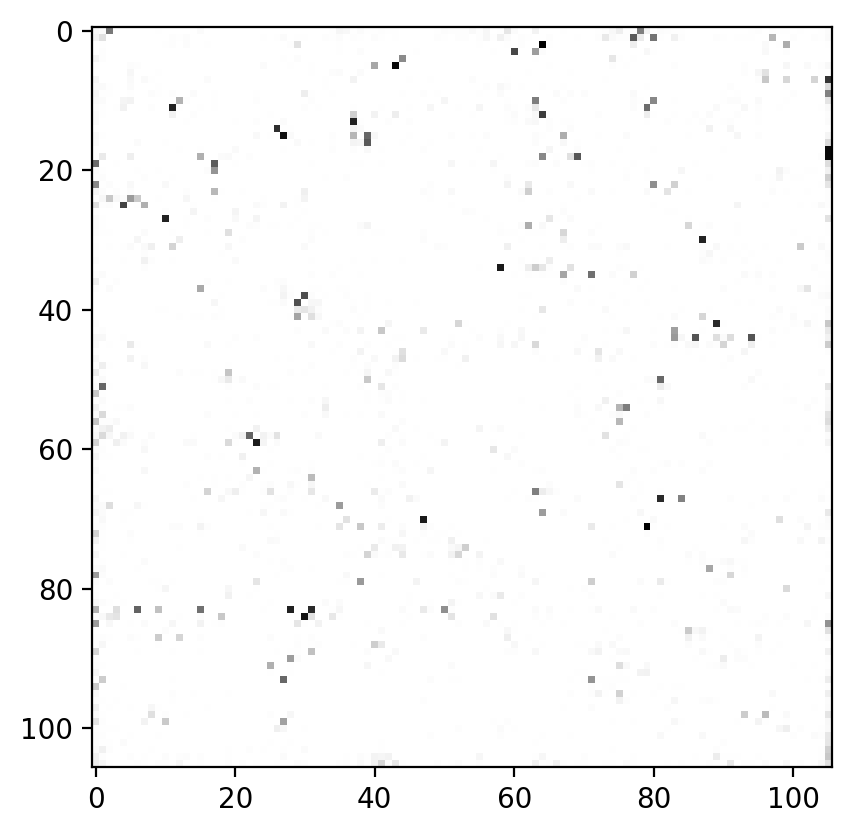

In [55]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(array.reshape(106,106), cmap='Greys',  interpolation='nearest')

plt.show()

In [56]:
image2midi('composition.png')

106 106
0.25 0.5 72
composition.png


/tmp/ipykernel_4715/2329151857.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)


In [24]:


!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!fluidsynth -ni font.sf2 composition.mid -F output.wav -r 44100
from IPython.display import Audio
Audio('output.wav')



E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/bin/bash: fluidsynth: command not found


ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [ ]:
model = Sequential()
n_nodes = 10 * 53 * 53
model.add(Dense(n_nodes, input_dim=latent_dim))
model.add(LeakyReLU(alpha=0.2))
model.add(Reshape((53, 53, 10)))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(1, (7,7) , padding='same',activation = 'sigmoid'))